# Polyssifier

In [38]:
%matplotlib inline
import glob
import numpy as np
import random
import pandas as pd
import seaborn as sns; sns.set()
import os
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt 

from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 
from nilearn import plotting,image 

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from pathlib import Path

from nltools.stats import fdr

from sklearn.metrics import confusion_matrix

from polyssifier import poly

import warnings
warnings.filterwarnings('ignore')


In [2]:
#import data set
df_rest = pd.read_csv("/home/xlajoie/Desktop/Final_restricted.csv")

df_unrest = pd.read_csv("/home/xlajoie/Desktop/Final_unrestricted.csv")


Final_df = pd.merge(df_rest, 
                      df_unrest, 
                      on ='Subject', 
                      how ='inner')
Final_df

,Subject,Age_in_Yrs,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,Race,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100206,27,True,NotTwin,,56037_85858,56037,85858,NaN,White,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,100610,27,True,NotMZ,DZ,52813_82634,52813,82634,NaN,White,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
2,101006,35,True,MZ,,51283_52850_81149,51283,81149,NaN,Black or African Am.,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
3,101309,29,True,NotTwin,,52385_82248,52385,82248,NaN,Black or African Am.,...,5.2,122.25,110.45,0.0,38.6,106.39,104.39,1.80,0.0,1.80
4,102008,24,True,NotTwin,,52018_81882,52018,81882,NaN,White,...,6.0,122.25,110.45,0.0,50.1,67.48,65.31,1.80,0.0,1.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,990366,22,True,MZ,,56064_85885,56064,85885,NaN,White,...,4.4,108.79,97.19,1.0,52.6,93.82,92.63,1.80,0.0,1.80
670,991267,30,True,NotTwin,,51639_81503,51639,81503,NaN,White,...,2.8,122.25,111.41,1.0,46.6,83.23,81.55,1.84,0.0,1.84
671,992673,33,True,NotTwin,,56143_85963,56143,85963,NaN,White,...,3.6,122.25,111.41,1.0,38.6,101.63,99.26,1.80,0.0,1.80
672,993675,29,True,NotTwin,,55800_85621,55800,85621,NaN,White,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76


In [3]:
# Filter left-handers (include >=50 handedness) 
Final_df = Final_df[Final_df["Handedness"] >= 50].reset_index()

# transform M and F with 0 and 1 
Final_df.rename(columns={"Subject": "subject_label"}, inplace=True)
Final_df["Gender"] = Final_df["Gender"].replace({"M": 0, "F": 1})
Final_df

,index,subject_label,Age_in_Yrs,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,0,100206,27,True,NotTwin,,56037_85858,56037,85858,NaN,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,1,100610,27,True,NotMZ,DZ,52813_82634,52813,82634,NaN,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
2,2,101006,35,True,MZ,,51283_52850_81149,51283,81149,NaN,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
3,4,102008,24,True,NotTwin,,52018_81882,52018,81882,NaN,...,6.0,122.25,110.45,0.0,50.1,67.48,65.31,1.80,0.0,1.80
4,7,102513,30,True,NotTwin,,56077_85897,56077,85897,NaN,...,5.2,108.79,98.04,2.0,54.3,84.07,82.37,1.92,0.0,1.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,669,990366,22,True,MZ,,56064_85885,56064,85885,NaN,...,4.4,108.79,97.19,1.0,52.6,93.82,92.63,1.80,0.0,1.80
566,670,991267,30,True,NotTwin,,51639_81503,51639,81503,NaN,...,2.8,122.25,111.41,1.0,46.6,83.23,81.55,1.84,0.0,1.84
567,671,992673,33,True,NotTwin,,56143_85963,56143,85963,NaN,...,3.6,122.25,111.41,1.0,38.6,101.63,99.26,1.80,0.0,1.80
568,672,993675,29,True,NotTwin,,55800_85621,55800,85621,NaN,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76


In [4]:
print("hommes = ", Final_df["Gender"].value_counts()[0])
print("femmes = ", Final_df["Gender"].value_counts()[1])

hommes =  264
femmes =  306


In [6]:
def img4d2vector(img_path, masker):
    img_masked = masker.fit_transform(img_path)  #fait une moyenne par label 
    return img_masked.flatten()  #devient 1 vecteur

def vector2img4d(vector, masker):
    data_2d = vector.reshape(4, -1) # 8
    return masker.inverse_transform(data_2d)   #remettre dans espace MNI that we can plot with nilearn

In [86]:
def run_poly(df_boot, data, seed):
#     df_bootstrap = pd.DataFrame()
#     for j in range(0, len(df_boot)):
#         index = random.randint(0, len(df_boot)-1)
#         frames = [df_bootstrap, df_boot[index:index+1]]
#         df_bootstrap = pd.concat(frames)

#     df_bootstrap = df_bootstrap.drop(df_bootstrap.columns[0], axis=1)

    # print(df_bootstrap["Gender"])  # should have the whole list

    x_correl = []
    nb_subjects = len(df_boot)
    subject_label = df_boot["subject_label"][:nb_subjects]

    x_correl = []
    for sub in subject_label:
        for seed_name in seed:
            x_correl.append(data[sub, seed_name])
    
    x_correl = np.array(x_correl)
    x_correl = x_correl.reshape(len(df_boot), len(seed)*148) # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds))
    

    y_sex = df_boot["Gender"][:nb_subjects]  # maybe list(df["Gender"])

    coef = poly(x_correl, y_sex, n_folds=10)
    

    return coef

In [8]:
df_boot = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [9]:
atlas_dest = datasets.fetch_atlas_destrieux_2009(legacy_format=False)
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_dest["maps"])

In [11]:
labels = atlas_dest["labels"].drop([0,42,117])
labels = labels.reset_index()
labels

,index,name
0,1,L G_and_S_frontomargin
1,2,L G_and_S_occipital_inf
2,3,L G_and_S_paracentral
3,4,L G_and_S_subcentral
4,5,L G_and_S_transv_frontopol
...,...,...
143,146,R S_suborbital
144,147,R S_subparietal
145,148,R S_temporal_inf
146,149,R S_temporal_sup


In [38]:
names = labels["name"]
names = names.to_numpy()

In [47]:
brains_region = np.c_[coordinates, names]
pd.DataFrame(brains_region).to_csv("/home/xlajoie/Desktop/sex_diff/brains_region.csv", header=None, index=None)

In [79]:
x,y = run_poly(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

0      0
1      0
2      1
3      0
4      0
      ..
565    0
566    0
567    1
568    1
569    1
Name: Gender, Length: 570, dtype: int64

In [80]:
m = []
f = []

for i in range(0, len(y)):
    if (y[i] == 1):
        f.append(1)
        m.append(0)
    elif (y[i] == 0):
        f.append(0)
        m.append(1)
        
        

In [101]:
design = np.asarray(f)
design = np.c_[design, np.asarray(m)]

In [102]:
pd.DataFrame(design).to_csv("/home/xlajoie/Desktop/sex_diff/design.csv", header=None, index=None)

In [55]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}_{seed_name}_voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)

data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path = img_tpl.format(seed_name=seed, participant_id=sub)
        data[(sub, seed)] = img4d2vector(img_path, masker)
        
        


100%|█████████████████████████████████████████| 570/570 [05:30<00:00,  1.73it/s]


In [27]:
save_x_correl = run_poly(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

In [36]:
x_correl_to_save = save_x_correl.reshape(570,148,8)

In [54]:
path_tpl = "/home/xlajoie/Desktop/correlation_matrix/participant_{id}.csv"
for i in range(0, len(x_correl_to_save)):
    df = pd.DataFrame(x_correl_to_save[i], columns = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])
    df.to_csv(path_tpl.format(id=i+1))


In [85]:
run_polyssifier = run(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

NameError: name 'run' is not defined

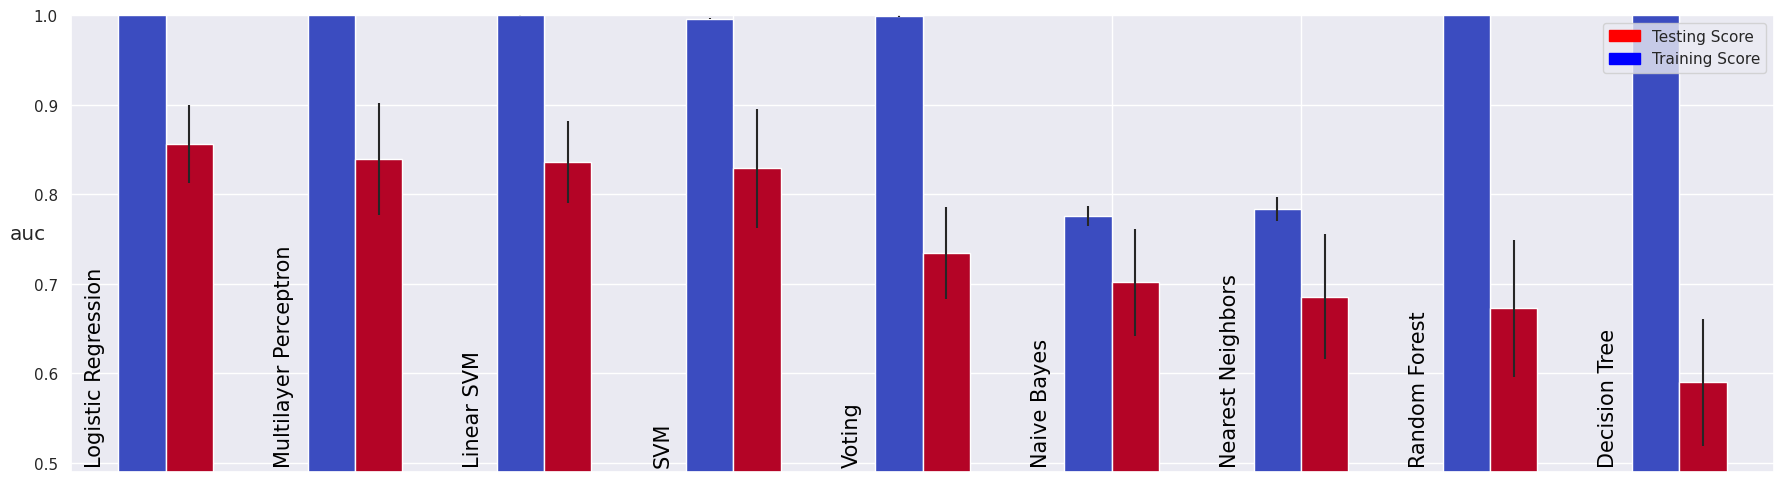

In [14]:
run_polyssifier.plot_scores()

2023-03-23 16:11:21,657 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-23 16:11:21,965 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-23 16:11:22,258 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-23 16:11:22,580 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


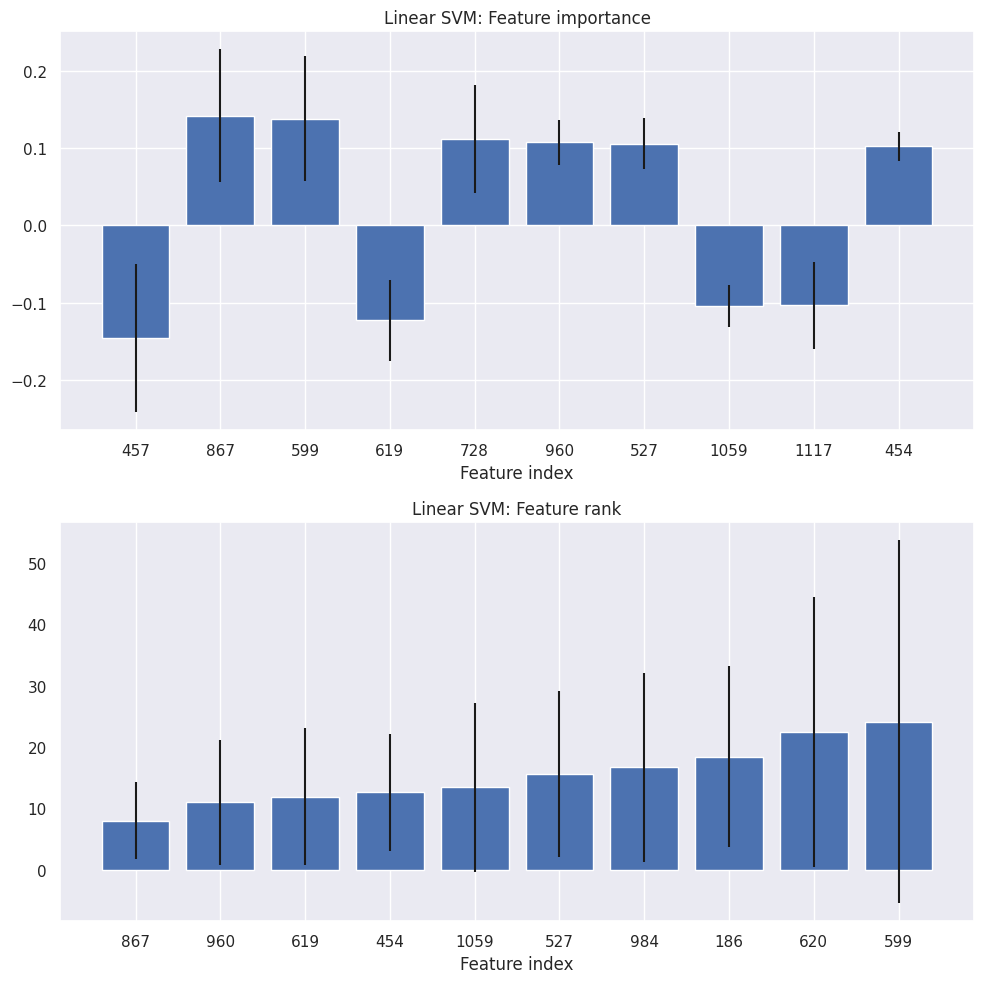

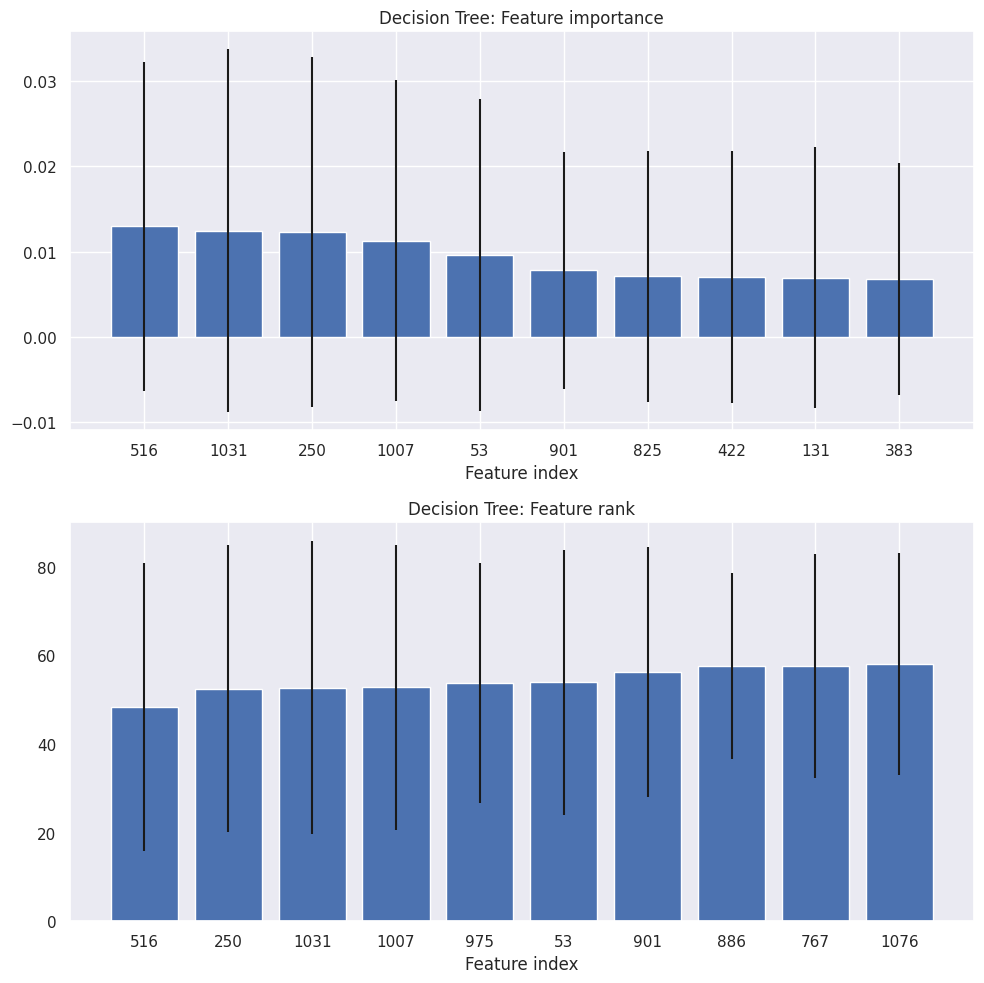

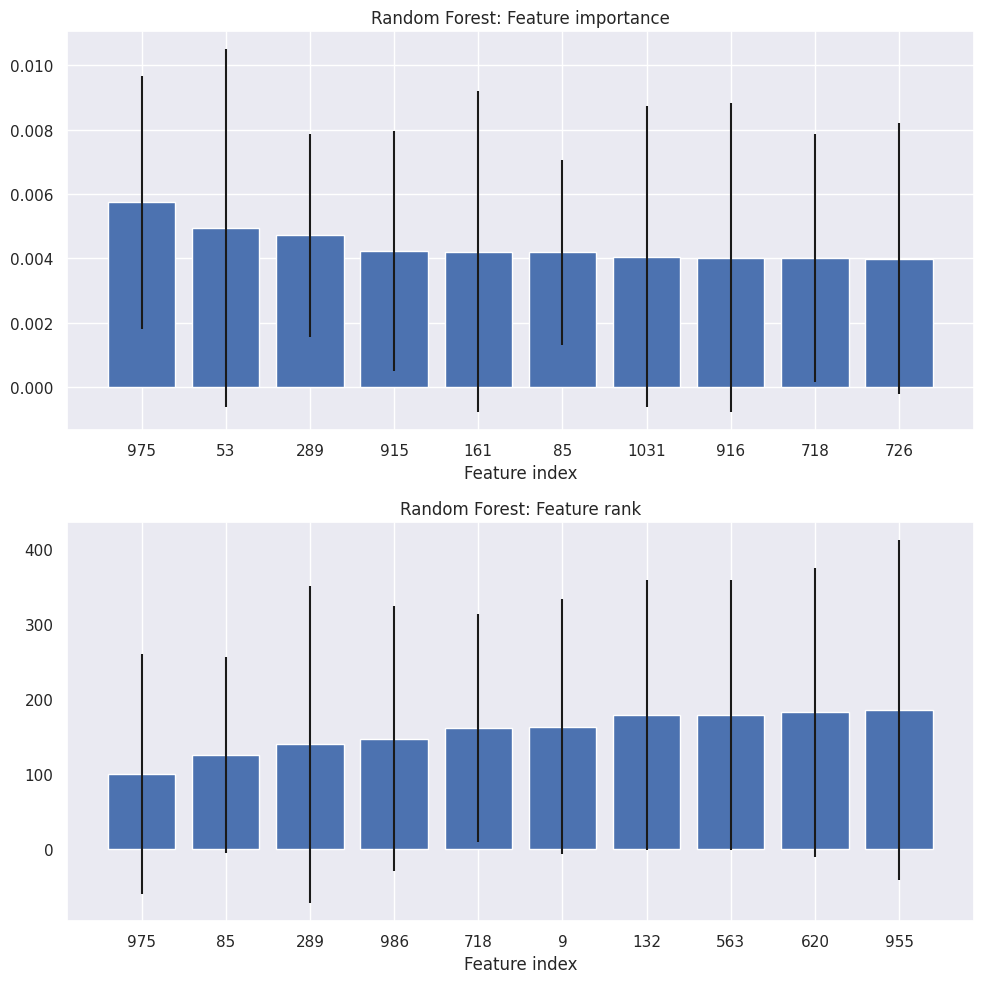

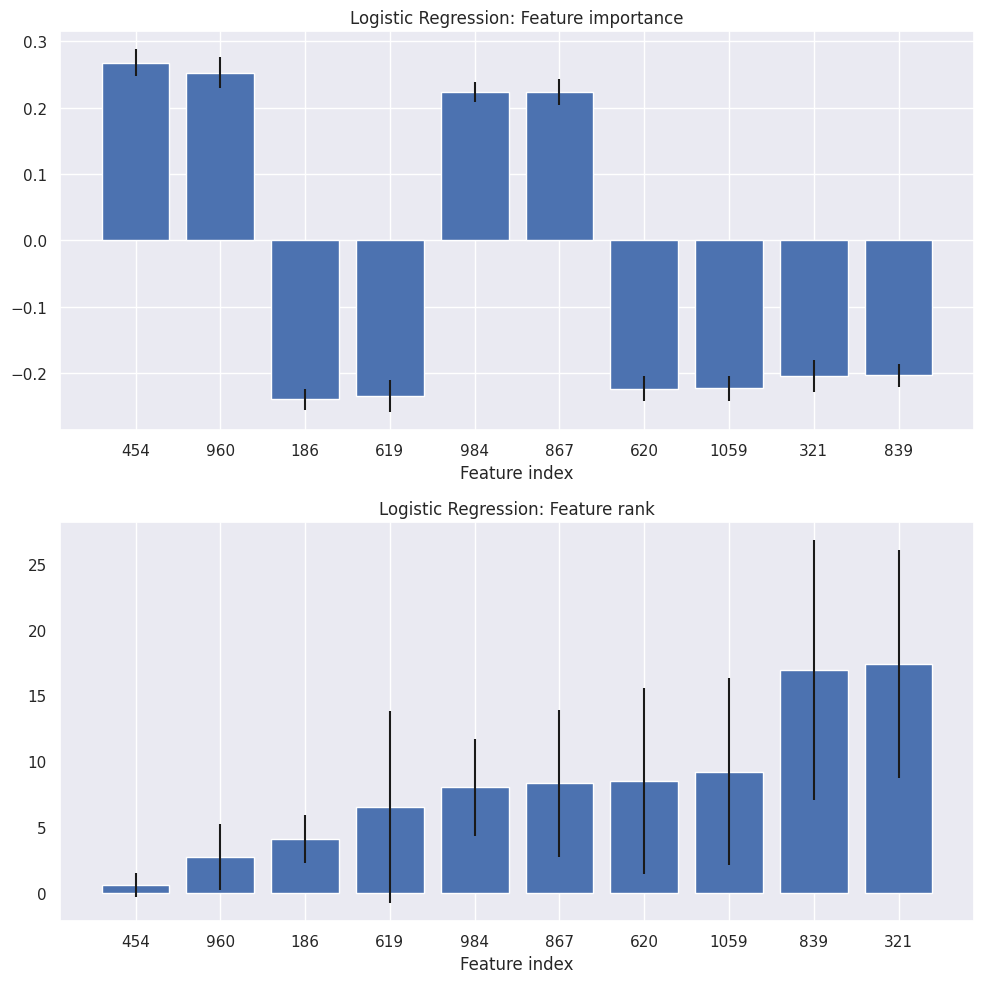

In [15]:
run_polyssifier.plot_features(ntop=10)

# Logistic model regression

In [5]:
df_boot = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}_{seed_name}_voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)

data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path = img_tpl.format(seed_name=seed, participant_id=sub)
        data[(sub, seed)] = img4d2vector(img_path, masker)
        

/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/nilearn/datasets/atlas.py:288: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)
100%|█████████████████████████████████████████| 570/570 [02:17<00:00,  4.15it/s]


In [15]:
def machine_learning_logistic(x, y):
    # split the sample o training/test with a 80/20 % ratio 
    # and stratify sex by class, also shuffle the data
    X_train, X_test, y_train, y_test = train_test_split( 
                                                        x,  # x 
                                                        y,  # y 
                                                        test_size = 0.2, # 80%/20% split 
                                                        shuffle = True,  #shuffle dataset before splitting
                                                        stratify = y,  # keep distribution of sex_class consistent between train and test sets
                                                        random_state = 123) #same shuffle each time 

    print('train:', len(X_train),'test:', len(X_test))
    
    
    score = []
    model = LogisticRegression(random_state = 123)
    score.append(cross_val_score(model, X_train, y_train, cv=10, n_jobs = 3))
    print(score)
    
    
    model.fit(X_train,y_train) #fit the model/ train the model
    y_pred = model.predict(X_test)

    #calculate the model accuracy
    acc_test = model.score(X_test, y_test)
    acc_train = model.score(X_train, y_train) 

    #compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    df_result = pd.DataFrame(data=[[tp, fn],[fp,tn]], index= ["Femme", "Homme"], columns = ["Femme", "Homme"])
    df_result = df_result.rename_axis("actual class")
    df_result = df_result.rename_axis("predicted class", axis="columns")
    print(df_result)
    
    # print results
    print('accuracy test (r2) =', acc_test)
    print('accuracy train (r2) =', acc_train)
    
    return {
        "len_X_train": len(X_train),
        "len_X_test": len(X_test),
        "score": score,
        "confusion_matrix": df_result,
        "acc_test": acc_test,
        "acc_train": acc_train,
        "model": model,
    }

In [16]:
def run_logistic(df_boot, data, seed):

    # print(df_bootstrap["Gender"])  # should have the whole list

    x_correl = []
    nb_subjects = len(df_boot)
    subject_label = df_boot["subject_label"][:nb_subjects]

    x_correl = []
    for sub in tqdm(subject_label):
        for seed_name in seed:
            x_correl.append(data[sub, seed_name])

    x_correl = np.array(x_correl)
    x_correl = x_correl.reshape(len(df_boot), len(seed)*148)  # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds))


    y_sex = df_boot["Gender"][:nb_subjects]  # maybe list(df["Gender"])

    coef = machine_learning_logistic(x_correl, y_sex)

    return x_correl

In [17]:
run_logistic = run(df_boot, data, SEEDS)

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 340757.31it/s]

train: 456 test: 114


[array([0.93478261, 0.7826087 , 0.82608696, 0.73913043, 0.7173913 ,
       0.65217391, 0.8       , 0.77777778, 0.77777778, 0.71111111])]
predicted class  Femme  Homme
actual class                 
Femme               41     20
Homme               14     39
accuracy test (r2) = 0.7017543859649122
accuracy train (r2) = 1.0


/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

# Polyssifier seed by seed

In [8]:
df_boot = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}_{seed_name}_voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)

data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path = img_tpl.format(seed_name=seed, participant_id=sub)
        data[(sub, seed)] = img4d2vector(img_path, masker)

/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/nilearn/datasets/atlas.py:288: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)
100%|█████████████████████████████████████████| 570/570 [02:13<00:00,  4.28it/s]


## opIFG_L

100%|████████████████████████████████████| 570/570 [00:00<00:00, 1214813.66it/s]
2023-03-28 11:17:35,653 - polyssifier - INFO - Detected 2 classes in label
2023-03-28 11:17:35,653 - polyssifier - INFO - Building classifiers ...
2023-03-28 11:17:35,658 - polyssifier - INFO - Initialization, done.
2023-03-28 11:17:35,672 - polyssifier - INFO - Training Multilayer Perceptron 0
2023-03-28 11:17:38,709 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.87, 3.04 sec
2023-03-28 11:17:38,712 - polyssifier - INFO - Training Multilayer Perceptron 1
2023-03-28 11:17:41,484 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.85, 2.77 sec
2023-03-28 11:17:41,486 - polyssifier - INFO - Training Multilayer Perceptron 2
2023-03-28 11:17:44,381 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.89, 2.89 sec
2023-03-28 11:17:44,384 - polyssifier - INFO - Training Multilayer Perceptron 3
2023-03-28 11:17:47,122 - polyssifier - INFO - Multilayer P

predict proba return shape (57,)


2023-03-28 11:18:16,494 - polyssifier - INFO - Linear SVM                 1: Train 0.86/Test 0.62, 0.71 sec
2023-03-28 11:18:16,497 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2023-03-28 11:18:17,232 - polyssifier - INFO - Linear SVM                 2: Train 0.85/Test 0.82, 0.74 sec
2023-03-28 11:18:17,234 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2023-03-28 11:18:17,959 - polyssifier - INFO - Linear SVM                 3: Train 0.87/Test 0.59, 0.72 sec
2023-03-28 11:18:17,962 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2023-03-28 11:18:18,693 - polyssifier - INFO - Linear SVM                 4: Train 0.86/Test 0.67, 0.73 sec
2023-03-28 11:18:18,698 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2023-03-28 11:18:19,431 - polyssifier - INFO - Linear SVM                 5: Train 0.85/Test 0.66, 0.73 sec
2023-03-28 11:18:19,434 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2023-03-28 11:18:20,166 - polyssifier - INFO - Linear SVM                 6: Train 0.86/Test 0.67, 0.73 sec
2023-03-28 11:18:20,169 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2023-03-28 11:18:20,892 - polyssifier - INFO - Linear SVM                 7: Train 0.86/Test 0.64, 0.72 sec
2023-03-28 11:18:20,895 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2023-03-28 11:18:21,608 - polyssifier - INFO - Linear SVM                 8: Train 0.86/Test 0.66, 0.71 sec
2023-03-28 11:18:21,611 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2023-03-28 11:18:22,335 - polyssifier - INFO - Linear SVM                 9: Train 0.85/Test 0.83, 0.72 sec
2023-03-28 11:18:22,338 - polyssifier - INFO - Training Decision Tree 0
2023-03-28 11:18:22,356 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.59, 0.02 sec
2023-03-28 11:18:22,364 - polyssifier - INFO - Training Decision Tree 1
2023-03-28 11:18:22,382 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.47, 0.02 sec
2023-03-28 11:18:22,385 - polyssifier - INFO - Training Decision Tree 2
2023-03-28 11:18:22,403 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.67, 0.02 sec
2023-03-28 11:18:22,405 - polyssifier - INFO - Training Decision Tree 3
2023-03-28 11:18:22,416 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.60, 0.01 sec
2023-03-28 11:18:22,417 - polyssifier - INFO - Training Decision Tree 4
2023-03-28 11:18:22,428 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.57, 0

predict proba return shape (57,)


2023-03-28 11:18:23,916 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.71, 1.42 sec
2023-03-28 11:18:23,921 - polyssifier - INFO - Training Random Forest 1
2023-03-28 11:18:25,336 - polyssifier - INFO - Random Forest              1: Train 1.00/Test 0.77, 1.41 sec
2023-03-28 11:18:25,340 - polyssifier - INFO - Training Random Forest 2
2023-03-28 11:18:26,748 - polyssifier - INFO - Random Forest              2: Train 1.00/Test 0.67, 1.41 sec
2023-03-28 11:18:26,752 - polyssifier - INFO - Training Random Forest 3
2023-03-28 11:18:28,220 - polyssifier - INFO - Random Forest              3: Train 1.00/Test 0.70, 1.47 sec
2023-03-28 11:18:28,224 - polyssifier - INFO - Training Random Forest 4
2023-03-28 11:18:29,645 - polyssifier - INFO - Random Forest              4: Train 1.00/Test 0.59, 1.42 sec
2023-03-28 11:18:29,650 - polyssifier - INFO - Training Random Forest 5
2023-03-28 11:18:31,073 - polyssifier - INFO - Random Forest              5: Train 1.00/Test 0.74, 1

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.829306  0.058689  0.710918  0.893827
Nearest Neighbors     train  0.791215  0.018828  0.767848  0.827288
                      test   0.715429  0.082641  0.580025  0.830864
SVM                   train  0.967369  0.003880  0.961054  0.973804
                      test   0.796158  0.069991  0.712779  0.887654
Linear SVM            train  0.857805  0.006473  0.847257  0.869275
                      test   0.683520  0.078891  0.591358  0.830025
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.581473  0.062637  0.470370  0.666667
Random Forest         train  0.999983  0.000022  0.999947  1.000000
                      test   0.699517  0.053165  0.591811  0.767901
Logistic Regression   train  0.734662  0.044985  0.705329  0.860943
                      test   0.671967  0.073299 

2023-03-28 11:18:45,237 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-28 11:18:45,686 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-28 11:18:45,977 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-28 11:18:46,282 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


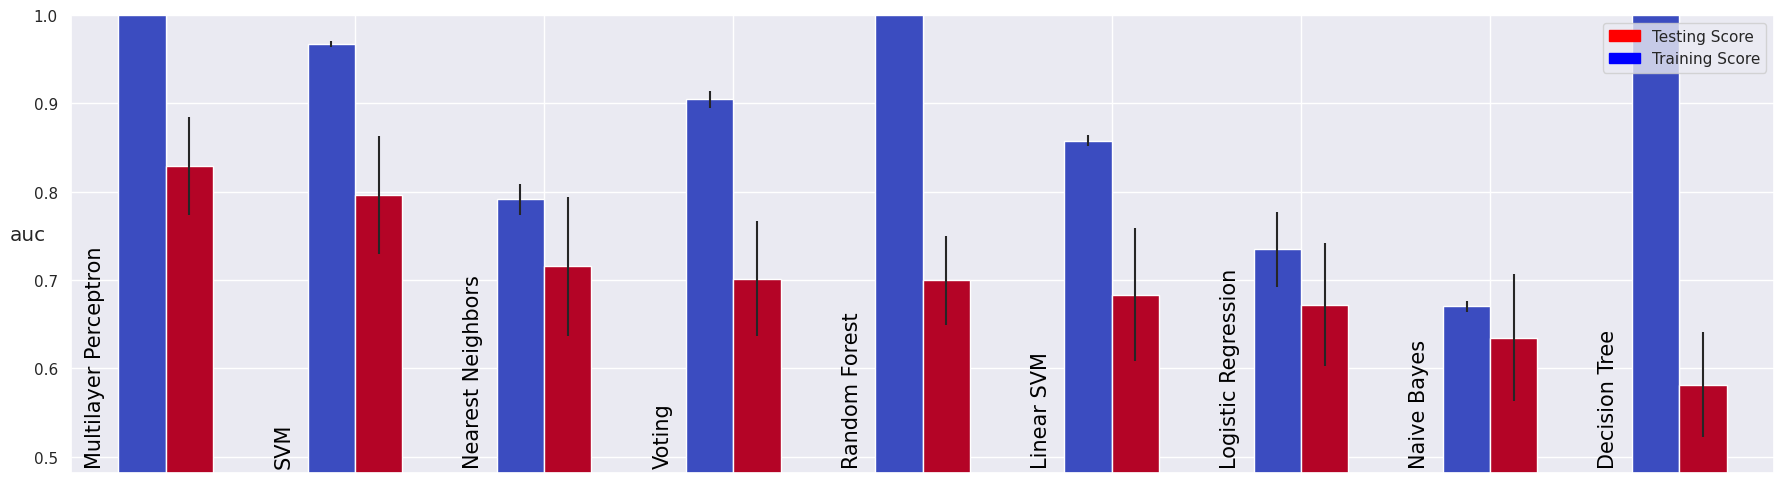

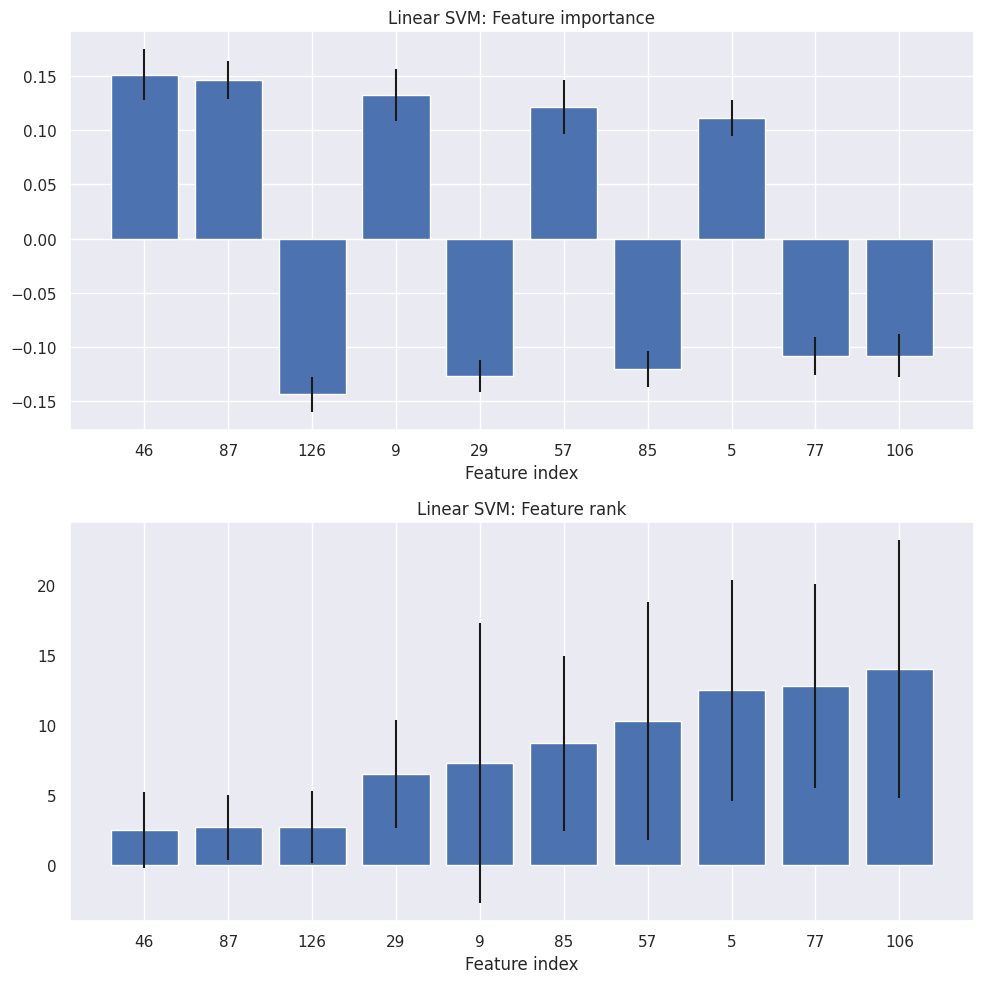

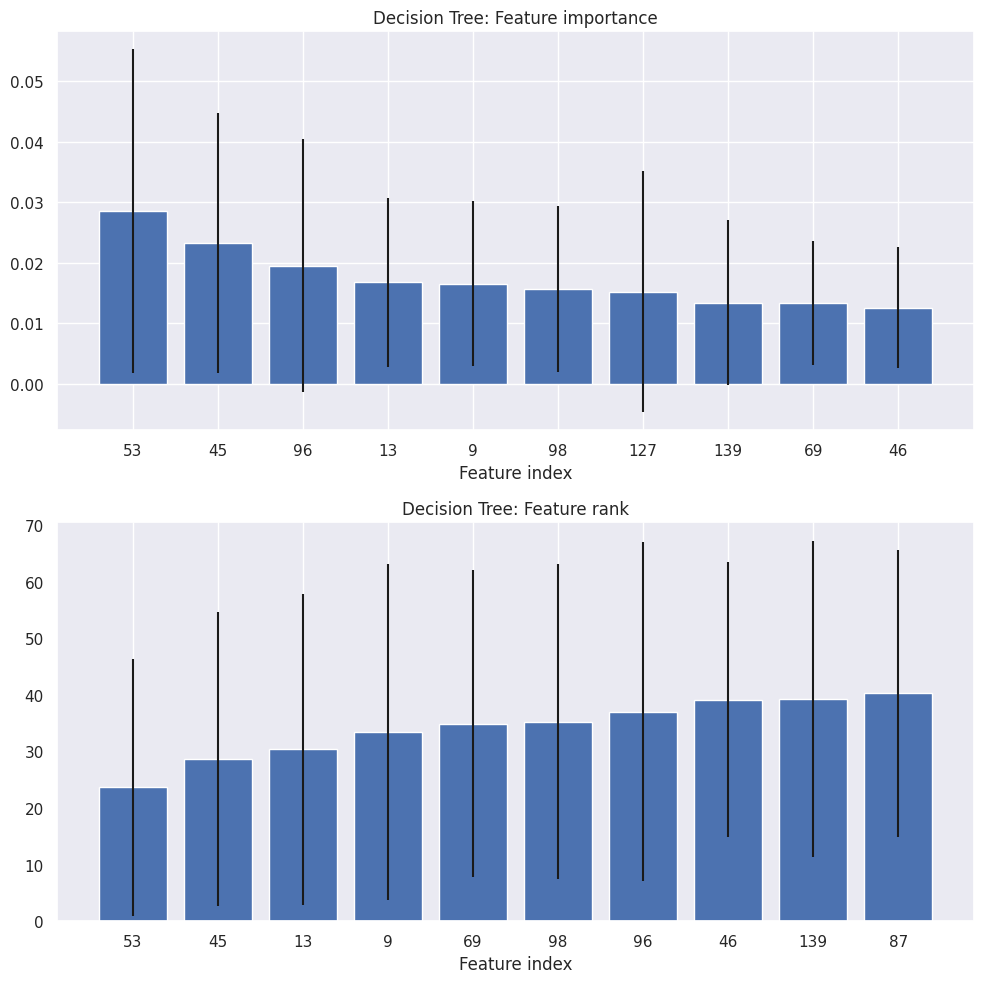

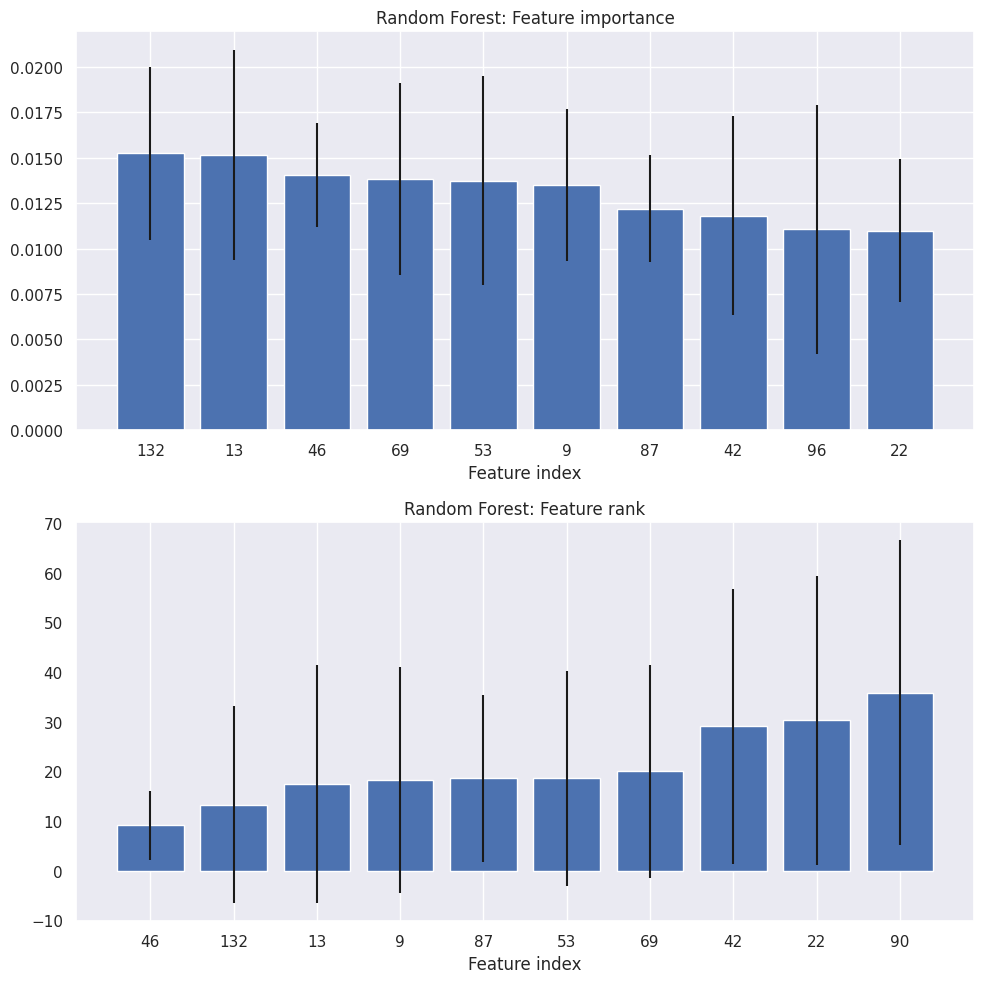

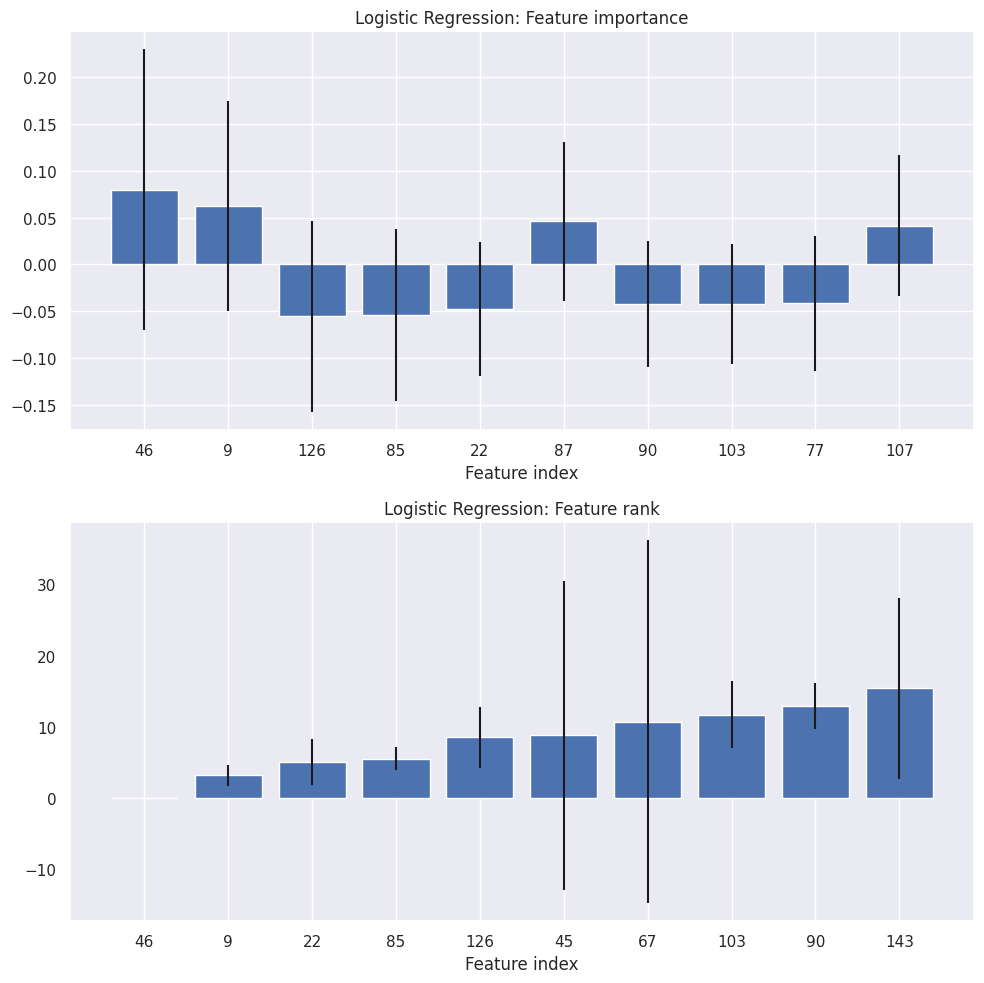

In [12]:
seed = ["opIFG_L"]

run_opIFG_L = run_poly(df_boot, data, seed)
run_opIFG_L.plot_scores()
run_opIFG_L.plot_features(ntop=10)

## Planumtemp_L

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 814012.01it/s]
2023-03-28 11:23:05,195 - polyssifier - INFO - Detected 2 classes in label
2023-03-28 11:23:05,195 - polyssifier - INFO - Building classifiers ...
2023-03-28 11:23:05,202 - polyssifier - INFO - Initialization, done.
2023-03-28 11:23:05,222 - polyssifier - INFO - Training Multilayer Perceptron 0
2023-03-28 11:23:08,134 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.88, 2.91 sec
2023-03-28 11:23:08,136 - polyssifier - INFO - Training Multilayer Perceptron 1
2023-03-28 11:23:11,113 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.75, 2.98 sec
2023-03-28 11:23:11,116 - polyssifier - INFO - Training Multilayer Perceptron 2
2023-03-28 11:23:13,840 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.80, 2.72 sec
2023-03-28 11:23:13,843 - polyssifier - INFO - Training Multilayer Perceptron 3
2023-03-28 11:23:16,938 - polyssifier - INFO - Multilayer P

predict proba return shape (57,)


2023-03-28 11:23:47,998 - polyssifier - INFO - Linear SVM                 1: Train 0.88/Test 0.62, 0.73 sec
2023-03-28 11:23:48,001 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2023-03-28 11:23:48,723 - polyssifier - INFO - Linear SVM                 2: Train 0.87/Test 0.74, 0.72 sec
2023-03-28 11:23:48,726 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2023-03-28 11:23:49,460 - polyssifier - INFO - Linear SVM                 3: Train 0.87/Test 0.70, 0.73 sec
2023-03-28 11:23:49,463 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2023-03-28 11:23:50,173 - polyssifier - INFO - Linear SVM                 4: Train 0.88/Test 0.73, 0.71 sec
2023-03-28 11:23:50,176 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2023-03-28 11:23:50,909 - polyssifier - INFO - Linear SVM                 5: Train 0.87/Test 0.68, 0.73 sec
2023-03-28 11:23:50,911 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2023-03-28 11:23:51,641 - polyssifier - INFO - Linear SVM                 6: Train 0.86/Test 0.75, 0.73 sec
2023-03-28 11:23:51,643 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2023-03-28 11:23:52,355 - polyssifier - INFO - Linear SVM                 7: Train 0.87/Test 0.72, 0.71 sec
2023-03-28 11:23:52,357 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2023-03-28 11:23:53,058 - polyssifier - INFO - Linear SVM                 8: Train 0.88/Test 0.65, 0.70 sec
2023-03-28 11:23:53,061 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2023-03-28 11:23:53,796 - polyssifier - INFO - Linear SVM                 9: Train 0.87/Test 0.68, 0.74 sec
2023-03-28 11:23:53,799 - polyssifier - INFO - Training Decision Tree 0
2023-03-28 11:23:53,813 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.57, 0.01 sec
2023-03-28 11:23:53,816 - polyssifier - INFO - Training Decision Tree 1
2023-03-28 11:23:53,831 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.47, 0.02 sec
2023-03-28 11:23:53,834 - polyssifier - INFO - Training Decision Tree 2
2023-03-28 11:23:53,850 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.54, 0.02 sec
2023-03-28 11:23:53,852 - polyssifier - INFO - Training Decision Tree 3
2023-03-28 11:23:53,866 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.63, 0.01 sec
2023-03-28 11:23:53,868 - polyssifier - INFO - Training Decision Tree 4
2023-03-28 11:23:53,878 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.56, 0

predict proba return shape (57,)


2023-03-28 11:23:55,360 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.81, 1.42 sec
2023-03-28 11:23:55,364 - polyssifier - INFO - Training Random Forest 1
2023-03-28 11:23:56,739 - polyssifier - INFO - Random Forest              1: Train 1.00/Test 0.64, 1.37 sec
2023-03-28 11:23:56,743 - polyssifier - INFO - Training Random Forest 2
2023-03-28 11:23:58,156 - polyssifier - INFO - Random Forest              2: Train 1.00/Test 0.77, 1.41 sec
2023-03-28 11:23:58,160 - polyssifier - INFO - Training Random Forest 3
2023-03-28 11:23:59,576 - polyssifier - INFO - Random Forest              3: Train 1.00/Test 0.84, 1.42 sec
2023-03-28 11:23:59,581 - polyssifier - INFO - Training Random Forest 4
2023-03-28 11:24:01,007 - polyssifier - INFO - Random Forest              4: Train 1.00/Test 0.68, 1.43 sec
2023-03-28 11:24:01,011 - polyssifier - INFO - Training Random Forest 5
2023-03-28 11:24:02,448 - polyssifier - INFO - Random Forest              5: Train 1.00/Test 0.60, 1

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.785701  0.070128  0.656328  0.883951
Nearest Neighbors     train  0.807499  0.010201  0.787456  0.821131
                      test   0.733061  0.068071  0.658809  0.872222
SVM                   train  0.963177  0.002590  0.959679  0.968419
                      test   0.791728  0.069646  0.674938  0.886420
Linear SVM            train  0.870170  0.007944  0.856815  0.882560
                      test   0.714430  0.067192  0.620988  0.865432
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.563540  0.066729  0.453474  0.649504
Random Forest         train  0.999975  0.000036  0.999908  1.000000
                      test   0.701581  0.084260  0.600496  0.840123
Logistic Regression   train  0.880522  0.006256  0.867058  0.889152
                      test   0.721253  0.069402 

2023-03-28 11:24:14,027 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-28 11:24:14,404 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-28 11:24:14,704 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-28 11:24:14,997 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


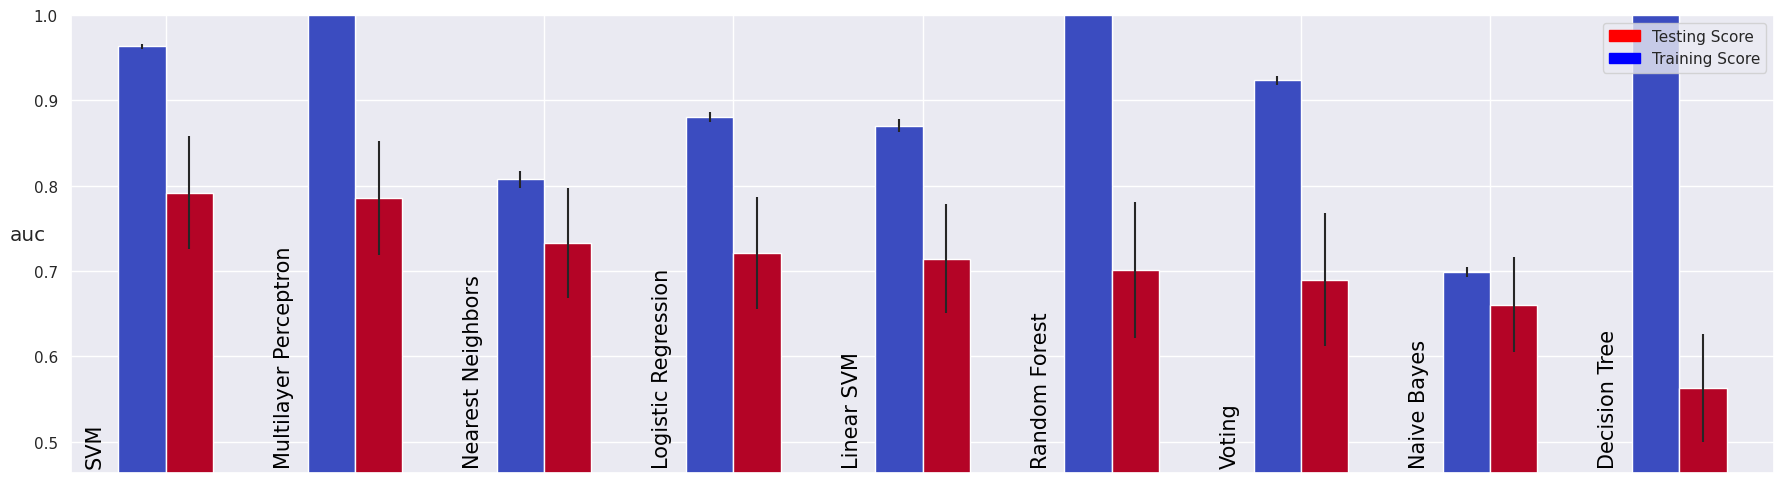

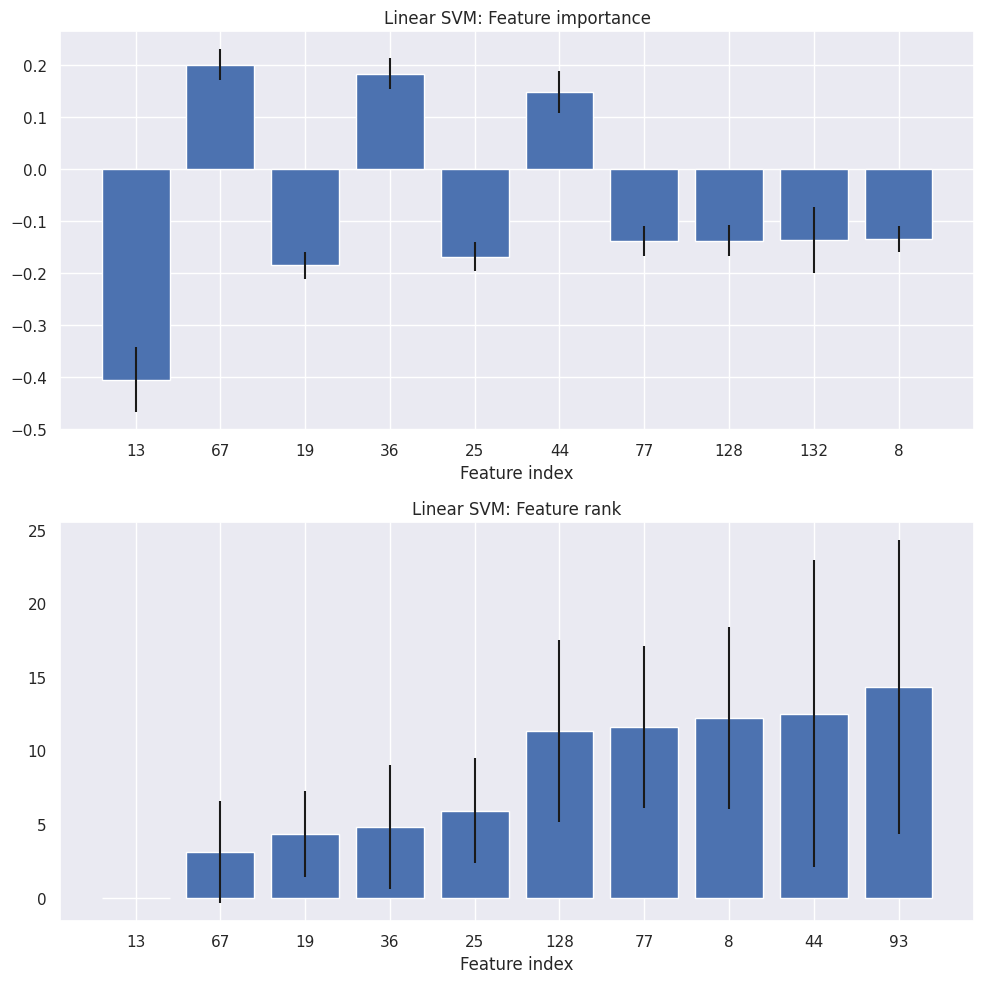

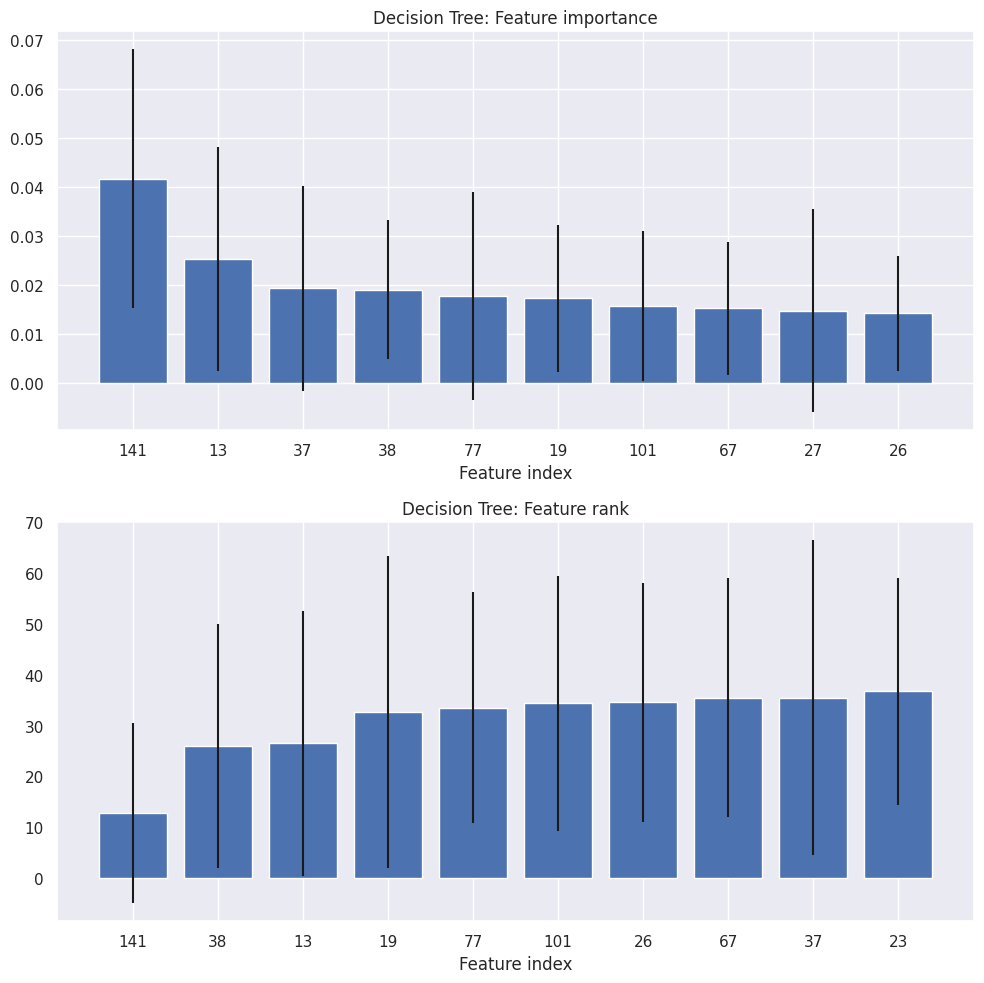

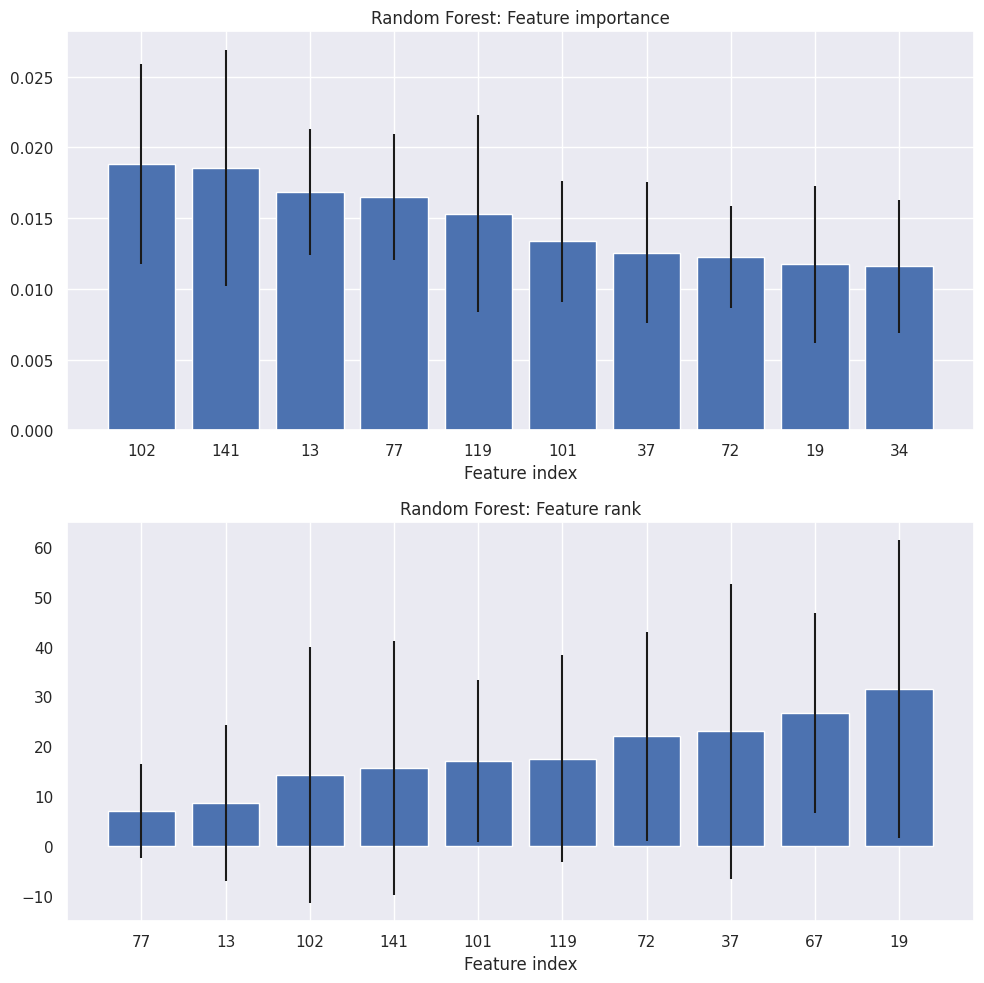

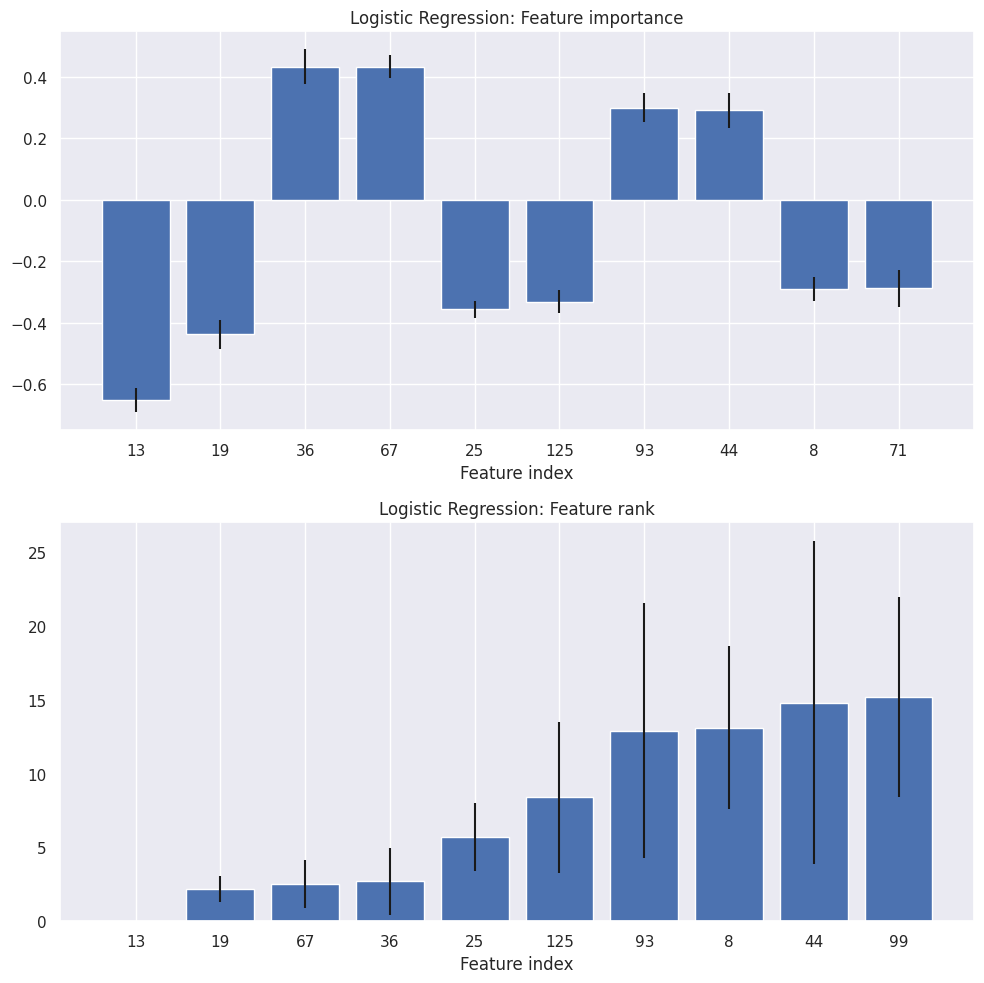

In [13]:
seed = ["planumtemp_L"]

run_planumtemp_L = run_poly(df_boot, data, seed)
run_planumtemp_L.plot_scores()
run_planumtemp_L.plot_features(ntop=10)

## aMTG_L

2023-03-28 11:27:22,022 - polyssifier - INFO - Detected 2 classes in label
2023-03-28 11:27:22,023 - polyssifier - INFO - Building classifiers ...
2023-03-28 11:27:22,026 - polyssifier - INFO - Initialization, done.
2023-03-28 11:27:22,044 - polyssifier - INFO - Training Multilayer Perceptron 0
2023-03-28 11:27:25,173 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.89, 3.13 sec
2023-03-28 11:27:25,176 - polyssifier - INFO - Training Multilayer Perceptron 1
2023-03-28 11:27:28,106 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.87, 2.93 sec
2023-03-28 11:27:28,109 - polyssifier - INFO - Training Multilayer Perceptron 2
2023-03-28 11:27:30,815 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.84, 2.71 sec
2023-03-28 11:27:30,818 - polyssifier - INFO - Training Multilayer Perceptron 3
2023-03-28 11:27:33,586 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.88, 2.77 sec
2023-03-28 11:27:33,589 - polyss

predict proba return shape (57,)


2023-03-28 11:28:01,612 - polyssifier - INFO - Linear SVM                 1: Train 0.85/Test 0.80, 0.78 sec
2023-03-28 11:28:01,615 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2023-03-28 11:28:02,406 - polyssifier - INFO - Linear SVM                 2: Train 0.86/Test 0.72, 0.79 sec
2023-03-28 11:28:02,409 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2023-03-28 11:28:03,313 - polyssifier - INFO - Linear SVM                 3: Train 0.86/Test 0.75, 0.90 sec
2023-03-28 11:28:03,316 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2023-03-28 11:28:04,186 - polyssifier - INFO - Linear SVM                 4: Train 0.86/Test 0.64, 0.87 sec
2023-03-28 11:28:04,189 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2023-03-28 11:28:05,020 - polyssifier - INFO - Linear SVM                 5: Train 0.87/Test 0.71, 0.83 sec
2023-03-28 11:28:05,023 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2023-03-28 11:28:05,730 - polyssifier - INFO - Linear SVM                 6: Train 0.88/Test 0.59, 0.71 sec
2023-03-28 11:28:05,732 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2023-03-28 11:28:06,439 - polyssifier - INFO - Linear SVM                 7: Train 0.86/Test 0.68, 0.71 sec
2023-03-28 11:28:06,442 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2023-03-28 11:28:07,168 - polyssifier - INFO - Linear SVM                 8: Train 0.85/Test 0.79, 0.73 sec
2023-03-28 11:28:07,171 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2023-03-28 11:28:07,878 - polyssifier - INFO - Linear SVM                 9: Train 0.88/Test 0.55, 0.71 sec
2023-03-28 11:28:07,881 - polyssifier - INFO - Training Decision Tree 0
2023-03-28 11:28:07,899 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.68, 0.02 sec
2023-03-28 11:28:07,902 - polyssifier - INFO - Training Decision Tree 1
2023-03-28 11:28:07,920 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.55, 0.02 sec
2023-03-28 11:28:07,923 - polyssifier - INFO - Training Decision Tree 2
2023-03-28 11:28:07,940 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.72, 0.02 sec
2023-03-28 11:28:07,941 - polyssifier - INFO - Training Decision Tree 3
2023-03-28 11:28:07,952 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.63, 0.01 sec
2023-03-28 11:28:07,954 - polyssifier - INFO - Training Decision Tree 4
2023-03-28 11:28:07,964 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.41, 0

predict proba return shape (57,)


2023-03-28 11:28:09,413 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.69, 1.39 sec
2023-03-28 11:28:09,417 - polyssifier - INFO - Training Random Forest 1
2023-03-28 11:28:10,821 - polyssifier - INFO - Random Forest              1: Train 1.00/Test 0.63, 1.40 sec
2023-03-28 11:28:10,825 - polyssifier - INFO - Training Random Forest 2
2023-03-28 11:28:12,223 - polyssifier - INFO - Random Forest              2: Train 1.00/Test 0.85, 1.40 sec
2023-03-28 11:28:12,227 - polyssifier - INFO - Training Random Forest 3
2023-03-28 11:28:13,616 - polyssifier - INFO - Random Forest              3: Train 1.00/Test 0.68, 1.39 sec
2023-03-28 11:28:13,620 - polyssifier - INFO - Training Random Forest 4
2023-03-28 11:28:15,044 - polyssifier - INFO - Random Forest              4: Train 1.00/Test 0.75, 1.42 sec
2023-03-28 11:28:15,049 - polyssifier - INFO - Training Random Forest 5
2023-03-28 11:28:16,461 - polyssifier - INFO - Random Forest              5: Train 1.00/Test 0.76, 1

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.832017  0.063785  0.735732  0.909429
Nearest Neighbors     train  0.844318  0.016814  0.815447  0.879961
                      test   0.730867  0.069770  0.613524  0.826303
SVM                   train  0.985711  0.001980  0.982572  0.989160
                      test   0.823872  0.042775  0.746898  0.879012
Linear SVM            train  0.860186  0.012360  0.846127  0.882842
                      test   0.701956  0.086297  0.545906  0.802469
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.587117  0.095741  0.408809  0.716667
Random Forest         train  0.999932  0.000096  0.999786  1.000000
                      test   0.715953  0.063610  0.630864  0.853086
Logistic Regression   train  0.868469  0.008116  0.858069  0.883040
                      test   0.698126  0.078182 

2023-03-28 11:28:27,840 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-28 11:28:28,197 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-28 11:28:28,654 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-28 11:28:28,994 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


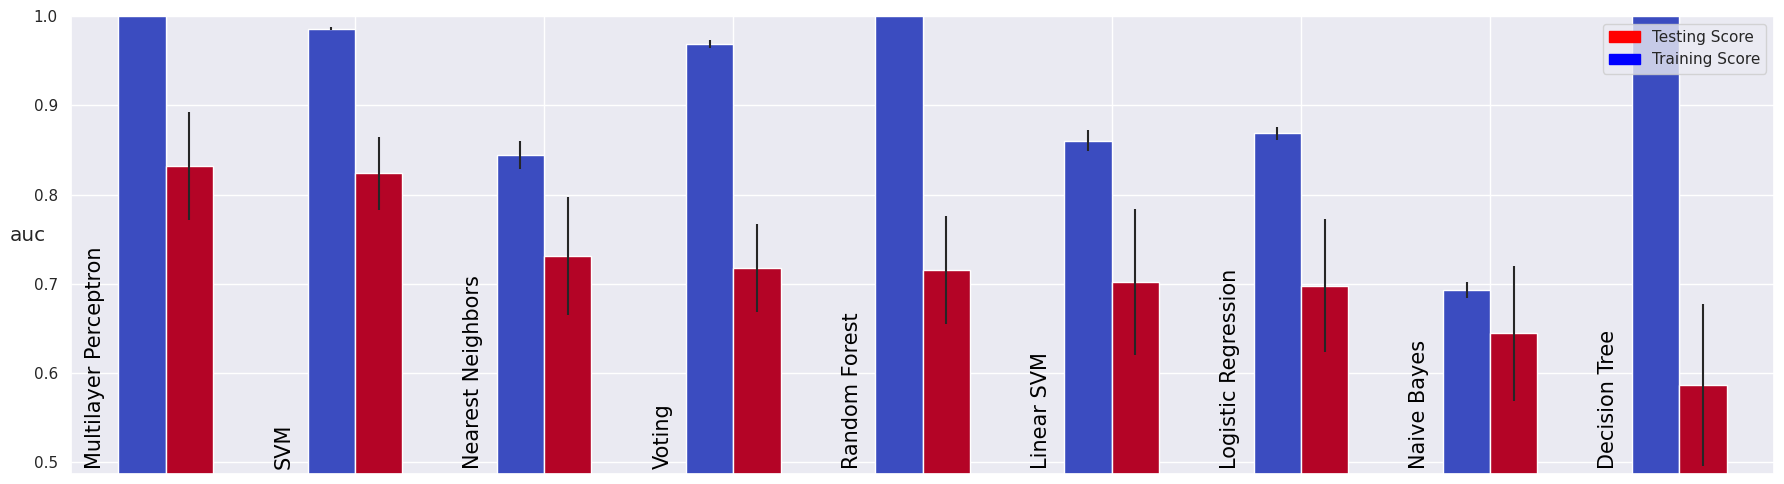

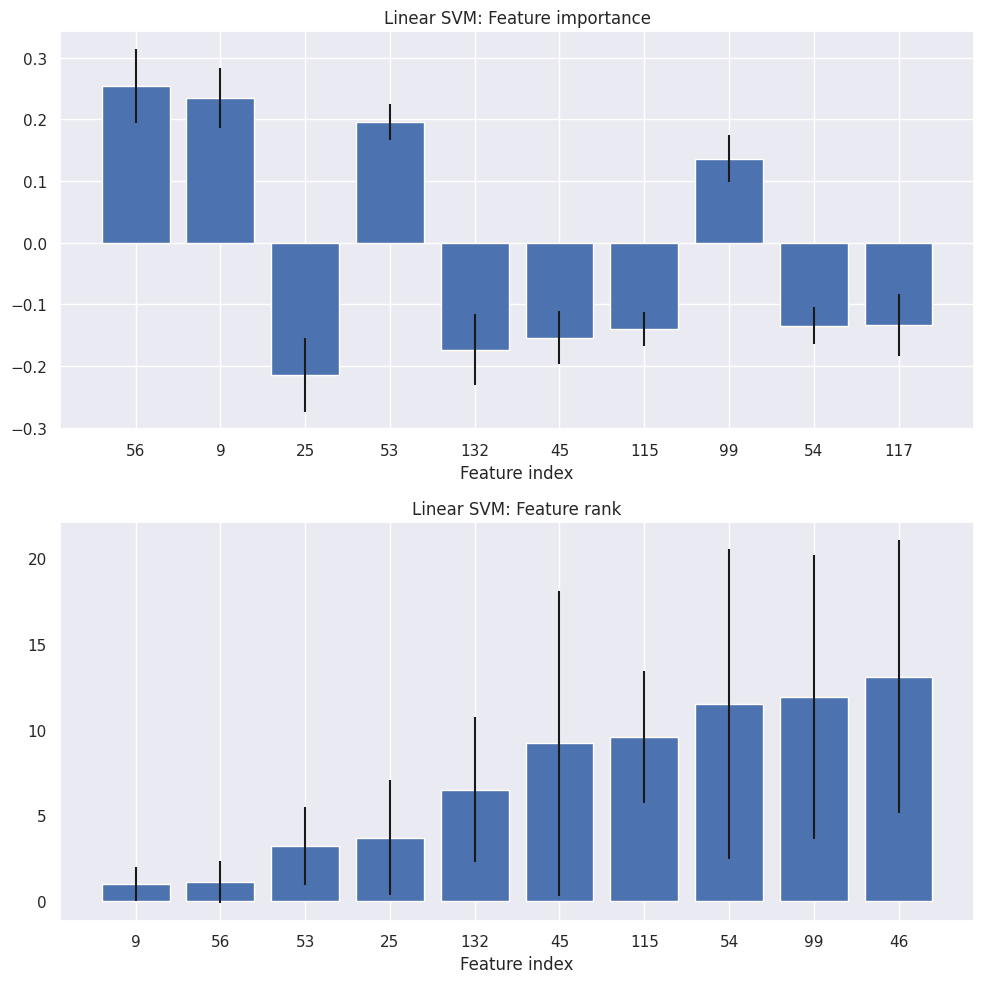

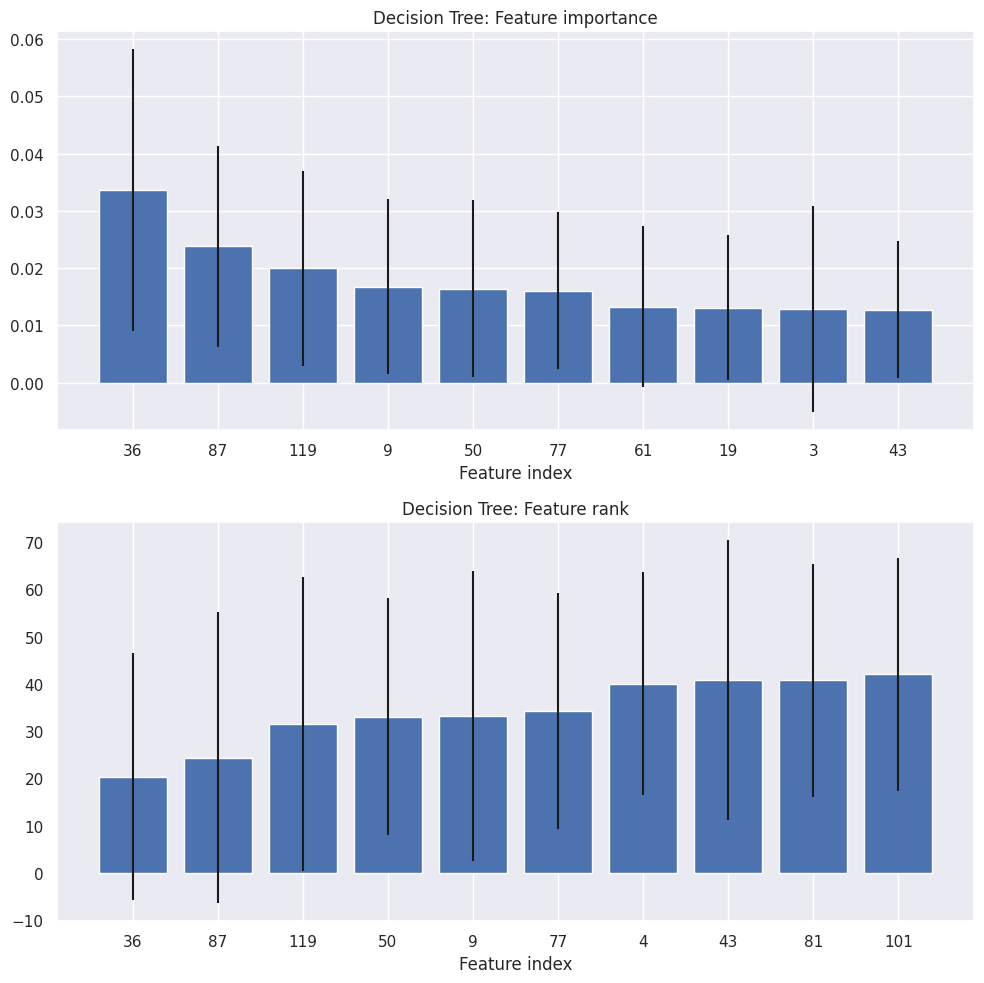

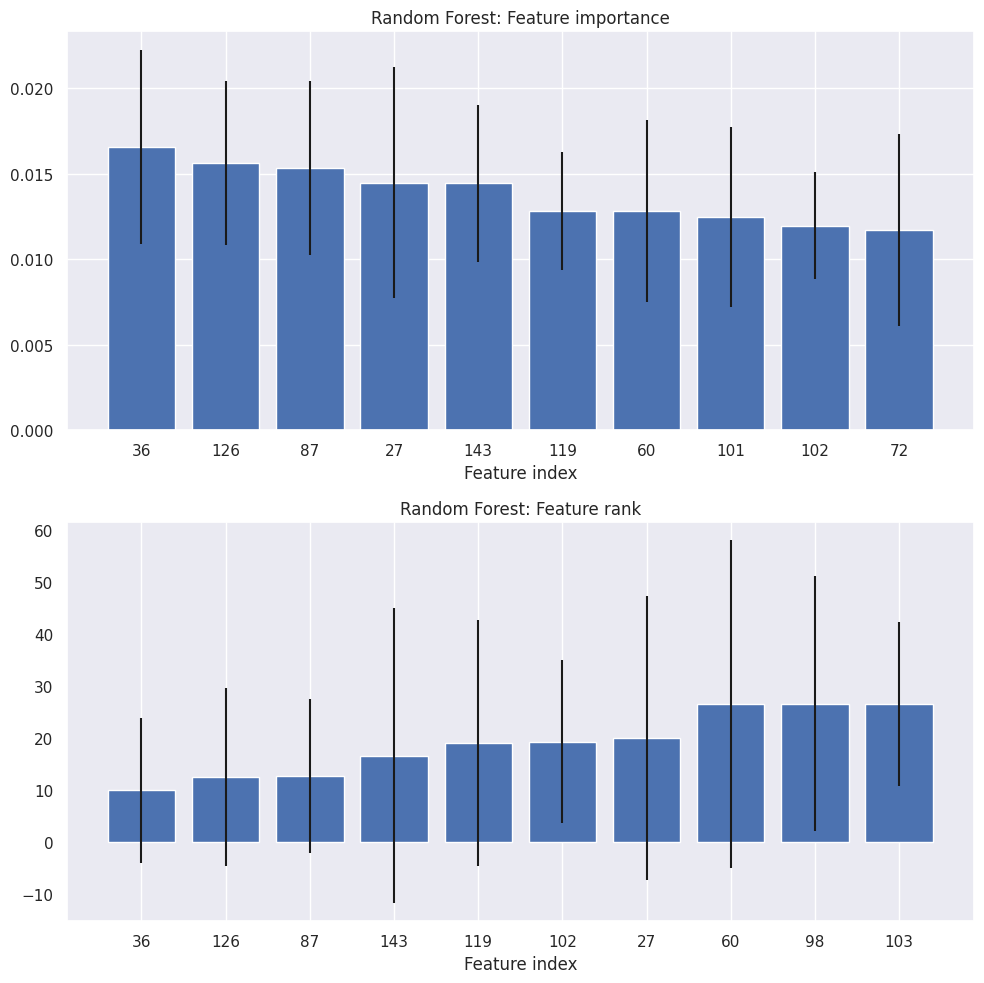

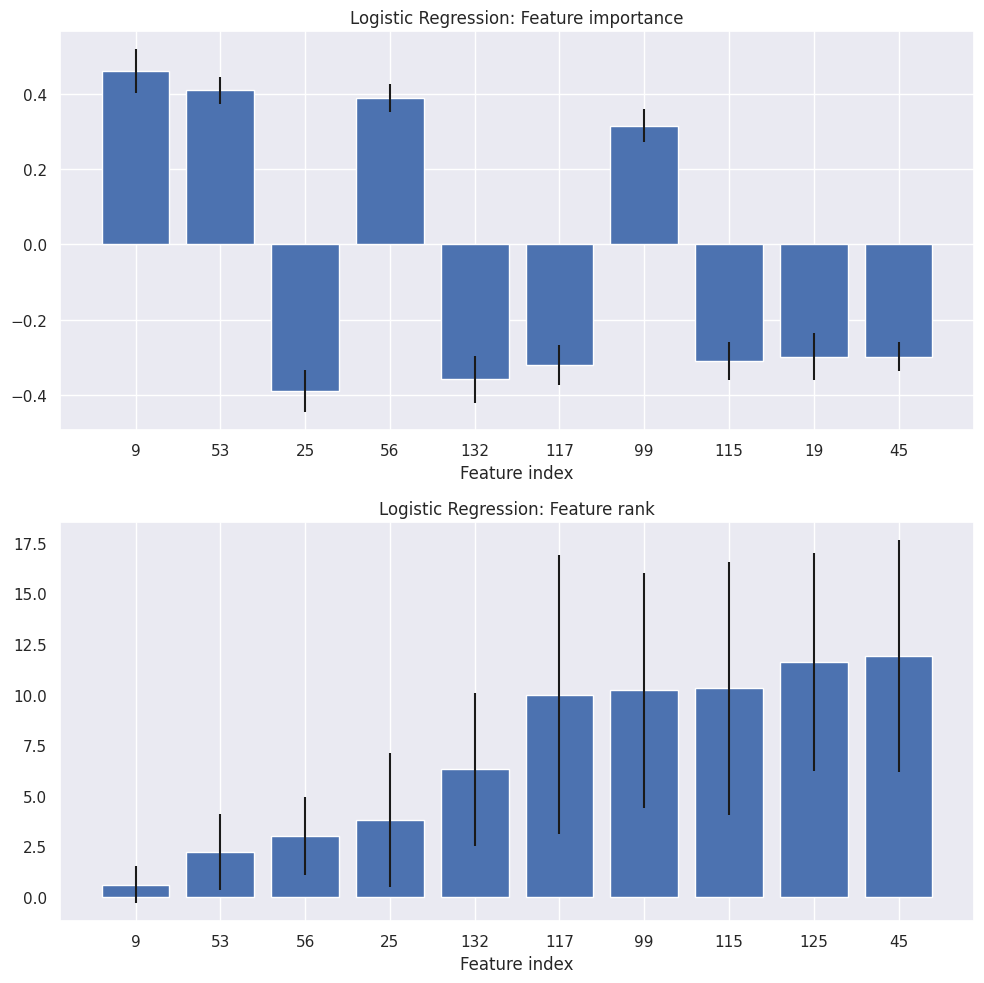

In [17]:
seed = ["aMTG_L"]

run_aMTG_L = run_poly(df_boot, data, seed)
run_aMTG_L.plot_scores()
run_aMTG_L.plot_features(ntop=10)

## pIFG_L

2023-03-28 11:30:00,759 - polyssifier - INFO - Detected 2 classes in label
2023-03-28 11:30:00,760 - polyssifier - INFO - Building classifiers ...
2023-03-28 11:30:00,766 - polyssifier - INFO - Initialization, done.
2023-03-28 11:30:00,783 - polyssifier - INFO - Training Multilayer Perceptron 0
2023-03-28 11:30:03,579 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.88, 2.80 sec
2023-03-28 11:30:03,581 - polyssifier - INFO - Training Multilayer Perceptron 1
2023-03-28 11:30:06,328 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.83, 2.75 sec
2023-03-28 11:30:06,331 - polyssifier - INFO - Training Multilayer Perceptron 2
2023-03-28 11:30:09,149 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.89, 2.82 sec
2023-03-28 11:30:09,152 - polyssifier - INFO - Training Multilayer Perceptron 3
2023-03-28 11:30:11,876 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.91, 2.72 sec
2023-03-28 11:30:11,878 - polyss

predict proba return shape (57,)


2023-03-28 11:30:40,439 - polyssifier - INFO - Linear SVM                 1: Train 0.84/Test 0.77, 0.74 sec
2023-03-28 11:30:40,442 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2023-03-28 11:30:41,166 - polyssifier - INFO - Linear SVM                 2: Train 0.86/Test 0.73, 0.72 sec
2023-03-28 11:30:41,168 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2023-03-28 11:30:41,881 - polyssifier - INFO - Linear SVM                 3: Train 0.86/Test 0.74, 0.71 sec
2023-03-28 11:30:41,883 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2023-03-28 11:30:42,572 - polyssifier - INFO - Linear SVM                 4: Train 0.88/Test 0.68, 0.69 sec
2023-03-28 11:30:42,574 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2023-03-28 11:30:43,267 - polyssifier - INFO - Linear SVM                 5: Train 0.87/Test 0.61, 0.69 sec
2023-03-28 11:30:43,270 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2023-03-28 11:30:43,981 - polyssifier - INFO - Linear SVM                 6: Train 0.86/Test 0.78, 0.71 sec
2023-03-28 11:30:43,984 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2023-03-28 11:30:44,688 - polyssifier - INFO - Linear SVM                 7: Train 0.86/Test 0.68, 0.70 sec
2023-03-28 11:30:44,691 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2023-03-28 11:30:45,407 - polyssifier - INFO - Linear SVM                 8: Train 0.86/Test 0.56, 0.72 sec
2023-03-28 11:30:45,409 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2023-03-28 11:30:46,115 - polyssifier - INFO - Linear SVM                 9: Train 0.85/Test 0.72, 0.71 sec
2023-03-28 11:30:46,118 - polyssifier - INFO - Training Decision Tree 0
2023-03-28 11:30:46,135 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.65, 0.02 sec
2023-03-28 11:30:46,138 - polyssifier - INFO - Training Decision Tree 1
2023-03-28 11:30:46,157 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.65, 0.02 sec
2023-03-28 11:30:46,160 - polyssifier - INFO - Training Decision Tree 2
2023-03-28 11:30:46,176 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.60, 0.02 sec
2023-03-28 11:30:46,178 - polyssifier - INFO - Training Decision Tree 3
2023-03-28 11:30:46,189 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.63, 0.01 sec
2023-03-28 11:30:46,190 - polyssifier - INFO - Training Decision Tree 4
2023-03-28 11:30:46,200 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.46, 0

predict proba return shape (57,)


2023-03-28 11:30:47,664 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.69, 1.40 sec
2023-03-28 11:30:47,668 - polyssifier - INFO - Training Random Forest 1
2023-03-28 11:30:49,131 - polyssifier - INFO - Random Forest              1: Train 1.00/Test 0.57, 1.46 sec
2023-03-28 11:30:49,135 - polyssifier - INFO - Training Random Forest 2
2023-03-28 11:30:50,549 - polyssifier - INFO - Random Forest              2: Train 1.00/Test 0.83, 1.41 sec
2023-03-28 11:30:50,554 - polyssifier - INFO - Training Random Forest 3
2023-03-28 11:30:51,967 - polyssifier - INFO - Random Forest              3: Train 1.00/Test 0.76, 1.41 sec
2023-03-28 11:30:51,971 - polyssifier - INFO - Training Random Forest 4
2023-03-28 11:30:53,396 - polyssifier - INFO - Random Forest              4: Train 1.00/Test 0.52, 1.43 sec
2023-03-28 11:30:53,401 - polyssifier - INFO - Training Random Forest 5
2023-03-28 11:30:54,819 - polyssifier - INFO - Random Forest              5: Train 1.00/Test 0.58, 1

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.858803  0.051311  0.774194  0.921836
Nearest Neighbors     train  0.821296  0.031886  0.788617  0.870604
                      test   0.701388  0.087438  0.563275  0.865385
SVM                   train  0.973535  0.002502  0.970298  0.979259
                      test   0.824434  0.065332  0.729529  0.920596
Linear SVM            train  0.860058  0.010123  0.841482  0.876975
                      test   0.701492  0.071951  0.557072  0.779156
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.616237  0.066459  0.463400  0.691067
Random Forest         train  0.999976  0.000040  0.999878  1.000000
                      test   0.674142  0.100041  0.522333  0.833333
Logistic Regression   train  0.868294  0.006430  0.856632  0.877876
                      test   0.709669  0.071217 

2023-03-28 11:31:06,379 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-28 11:31:06,670 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-28 11:31:06,963 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-28 11:31:07,259 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


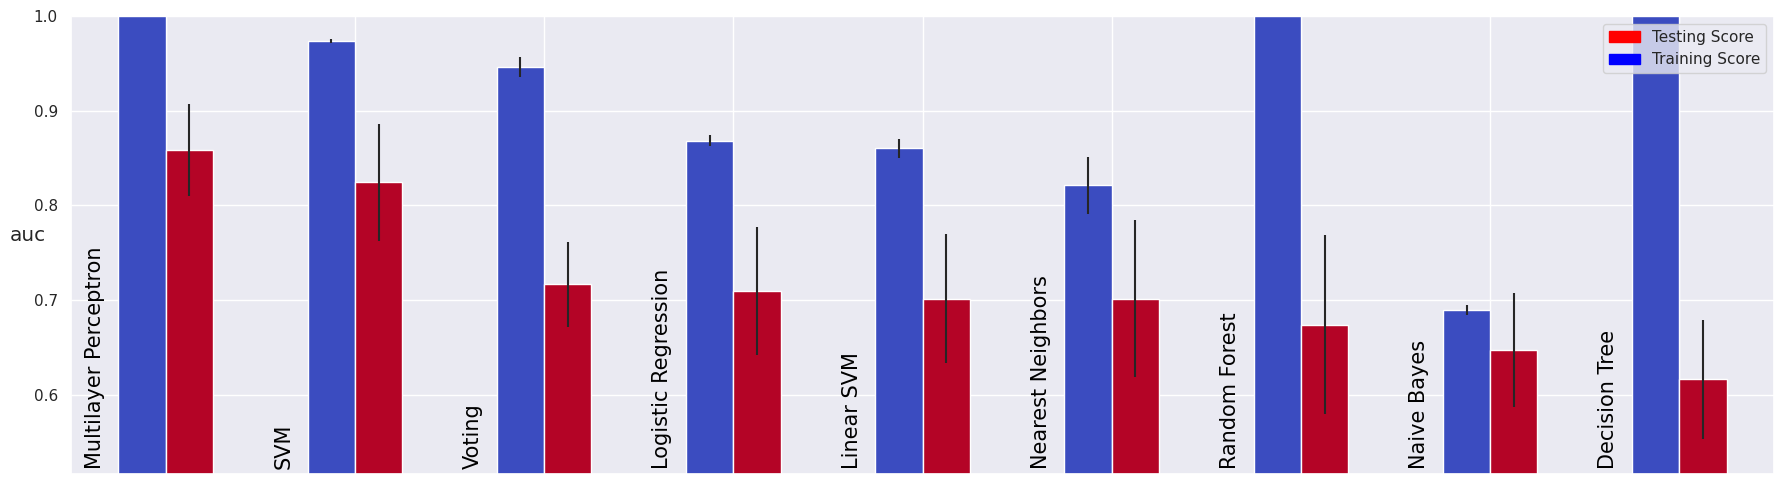

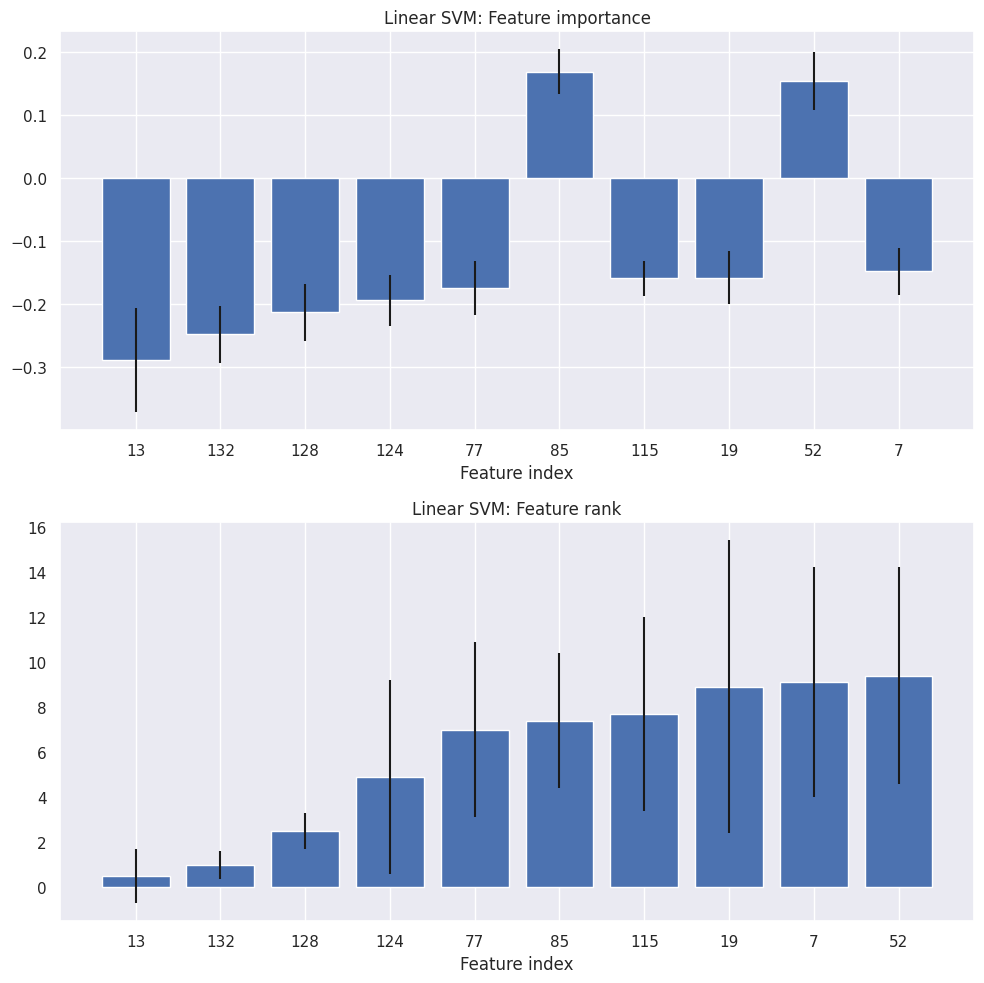

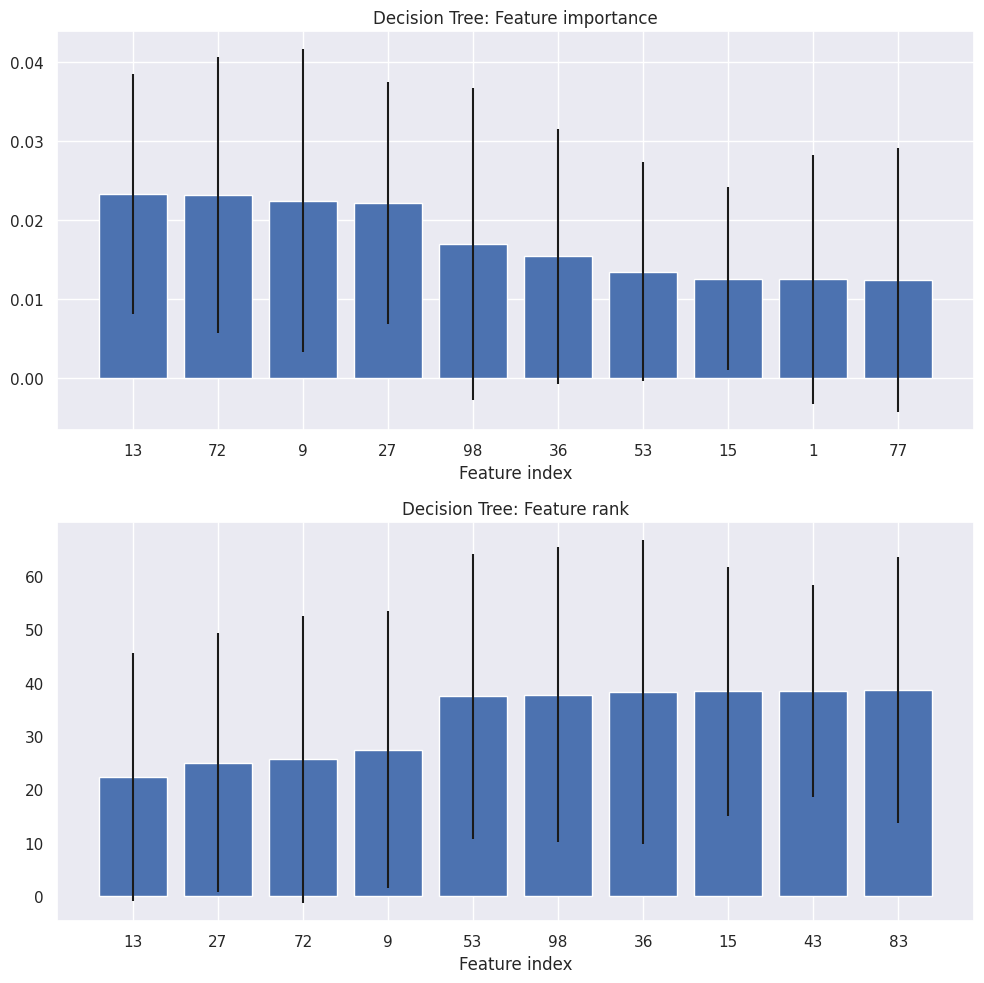

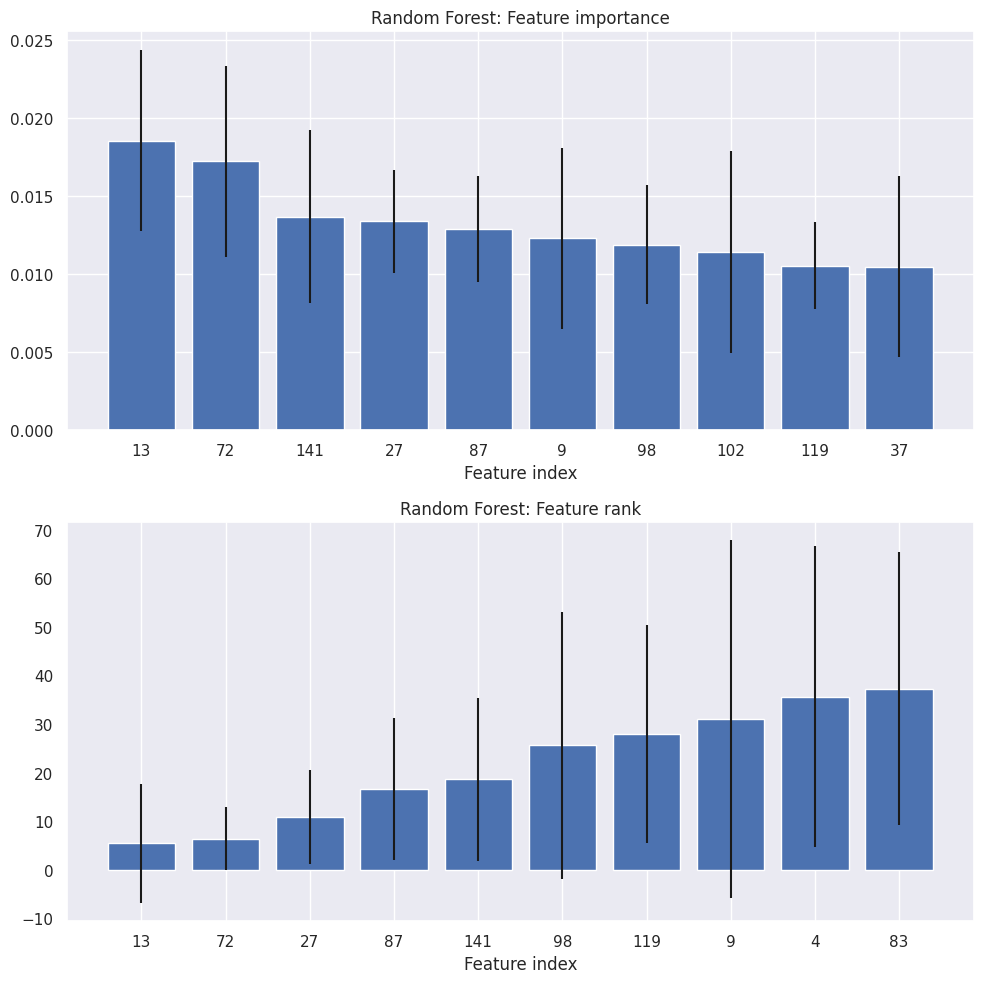

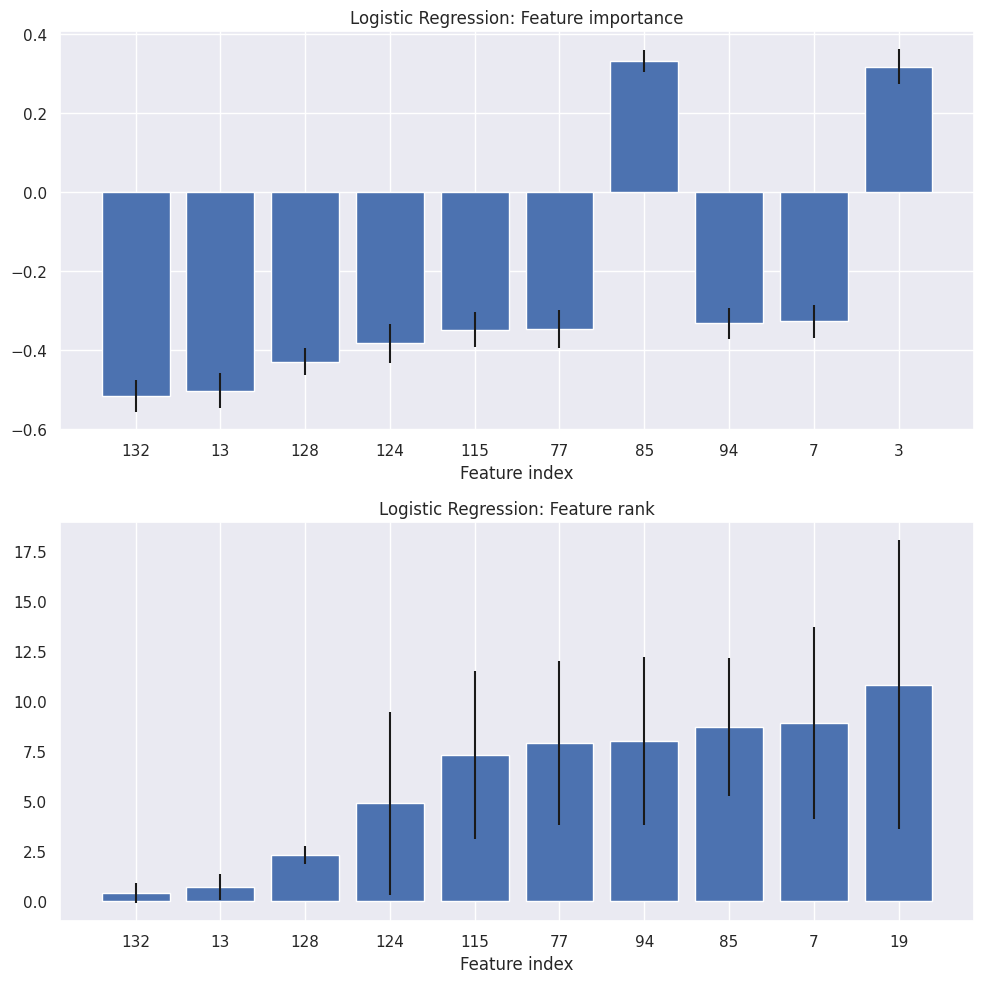

In [18]:
seed = ["pITG_L"]

run_pITG_L = run_poly(df_boot, data, seed)
run_pITG_L.plot_scores()
run_pITG_L.plot_features(ntop=10)

## opIFG_R

2023-03-28 11:32:15,548 - polyssifier - INFO - Detected 2 classes in label
2023-03-28 11:32:15,549 - polyssifier - INFO - Building classifiers ...
2023-03-28 11:32:15,553 - polyssifier - INFO - Initialization, done.
2023-03-28 11:32:15,570 - polyssifier - INFO - Training Multilayer Perceptron 0
2023-03-28 11:32:18,434 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.85, 2.86 sec
2023-03-28 11:32:18,437 - polyssifier - INFO - Training Multilayer Perceptron 1
2023-03-28 11:32:21,479 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.82, 3.04 sec
2023-03-28 11:32:21,481 - polyssifier - INFO - Training Multilayer Perceptron 2
2023-03-28 11:32:24,932 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.91, 3.45 sec
2023-03-28 11:32:24,935 - polyssifier - INFO - Training Multilayer Perceptron 3
2023-03-28 11:32:28,255 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.87, 3.32 sec
2023-03-28 11:32:28,258 - polyss

predict proba return shape (57,)


2023-03-28 11:32:59,099 - polyssifier - INFO - Linear SVM                 1: Train 0.89/Test 0.77, 0.68 sec
2023-03-28 11:32:59,102 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2023-03-28 11:32:59,811 - polyssifier - INFO - Linear SVM                 2: Train 0.89/Test 0.81, 0.71 sec
2023-03-28 11:32:59,814 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2023-03-28 11:33:00,519 - polyssifier - INFO - Linear SVM                 3: Train 0.88/Test 0.88, 0.71 sec
2023-03-28 11:33:00,522 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2023-03-28 11:33:01,230 - polyssifier - INFO - Linear SVM                 4: Train 0.89/Test 0.71, 0.71 sec
2023-03-28 11:33:01,233 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2023-03-28 11:33:01,920 - polyssifier - INFO - Linear SVM                 5: Train 0.89/Test 0.80, 0.69 sec
2023-03-28 11:33:01,923 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2023-03-28 11:33:02,593 - polyssifier - INFO - Linear SVM                 6: Train 0.90/Test 0.64, 0.67 sec
2023-03-28 11:33:02,596 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2023-03-28 11:33:03,308 - polyssifier - INFO - Linear SVM                 7: Train 0.88/Test 0.77, 0.71 sec
2023-03-28 11:33:03,311 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2023-03-28 11:33:03,994 - polyssifier - INFO - Linear SVM                 8: Train 0.89/Test 0.74, 0.68 sec
2023-03-28 11:33:03,997 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2023-03-28 11:33:04,726 - polyssifier - INFO - Linear SVM                 9: Train 0.88/Test 0.82, 0.73 sec
2023-03-28 11:33:04,729 - polyssifier - INFO - Training Decision Tree 0
2023-03-28 11:33:04,748 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.61, 0.02 sec
2023-03-28 11:33:04,753 - polyssifier - INFO - Training Decision Tree 1
2023-03-28 11:33:04,771 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.58, 0.02 sec
2023-03-28 11:33:04,776 - polyssifier - INFO - Training Decision Tree 2
2023-03-28 11:33:04,792 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.65, 0.02 sec
2023-03-28 11:33:04,793 - polyssifier - INFO - Training Decision Tree 3
2023-03-28 11:33:04,805 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.63, 0.01 sec
2023-03-28 11:33:04,807 - polyssifier - INFO - Training Decision Tree 4
2023-03-28 11:33:04,821 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.52, 0

predict proba return shape (57,)


2023-03-28 11:33:06,285 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.77, 1.40 sec
2023-03-28 11:33:06,289 - polyssifier - INFO - Training Random Forest 1
2023-03-28 11:33:07,723 - polyssifier - INFO - Random Forest              1: Train 1.00/Test 0.73, 1.43 sec
2023-03-28 11:33:07,728 - polyssifier - INFO - Training Random Forest 2
2023-03-28 11:33:09,157 - polyssifier - INFO - Random Forest              2: Train 1.00/Test 0.85, 1.43 sec
2023-03-28 11:33:09,161 - polyssifier - INFO - Training Random Forest 3
2023-03-28 11:33:10,587 - polyssifier - INFO - Random Forest              3: Train 1.00/Test 0.85, 1.43 sec
2023-03-28 11:33:10,591 - polyssifier - INFO - Training Random Forest 4
2023-03-28 11:33:11,976 - polyssifier - INFO - Random Forest              4: Train 1.00/Test 0.66, 1.39 sec
2023-03-28 11:33:11,981 - polyssifier - INFO - Training Random Forest 5
2023-03-28 11:33:13,388 - polyssifier - INFO - Random Forest              5: Train 1.00/Test 0.67, 1

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.850771  0.042492  0.779156  0.906173
Nearest Neighbors     train  0.827327  0.016856  0.812070  0.858312
                      test   0.746157  0.067742  0.616005  0.833747
SVM                   train  0.972966  0.001575  0.970449  0.975157
                      test   0.854406  0.048396  0.804938  0.953086
Linear SVM            train  0.890006  0.006691  0.880688  0.903652
                      test   0.765790  0.068219  0.635236  0.883951
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.603119  0.041387  0.524194  0.665633
Random Forest         train  0.999939  0.000107  0.999656  1.000000
                      test   0.757097  0.067842  0.657568  0.851852
Logistic Regression   train  0.893874  0.005575  0.883141  0.904034
                      test   0.757627  0.068540 

2023-03-28 11:33:25,623 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-28 11:33:25,916 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-28 11:33:26,309 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-28 11:33:26,599 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


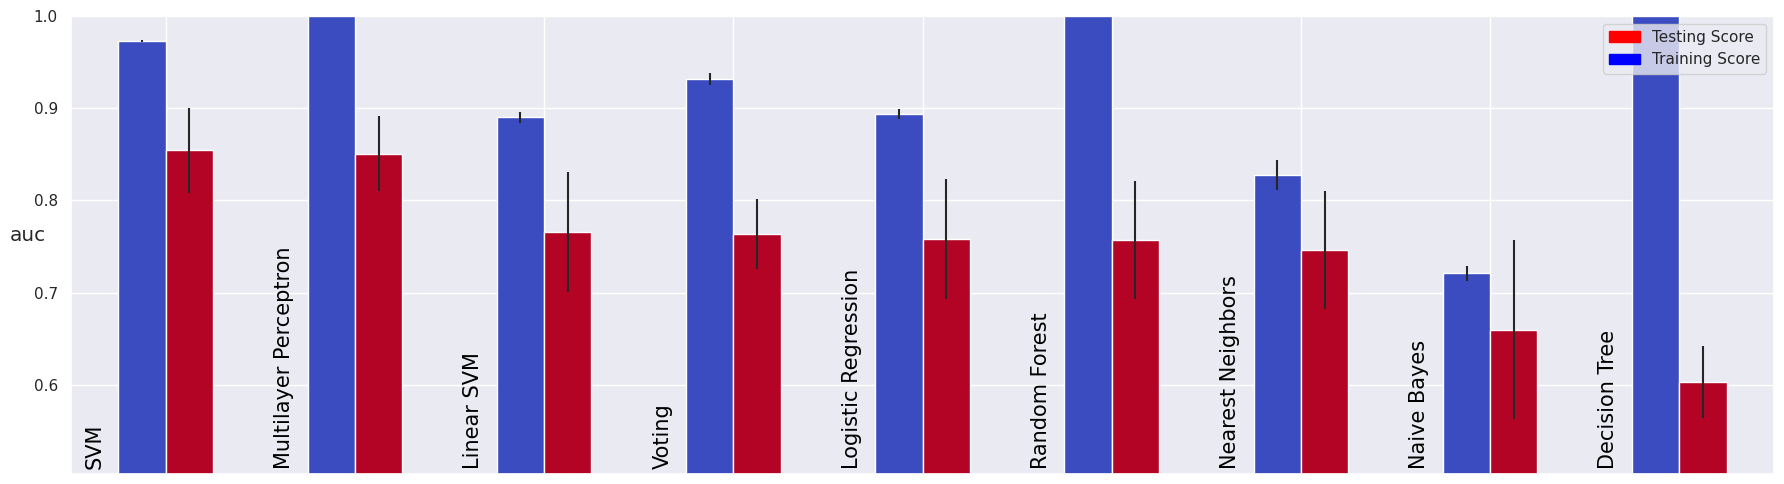

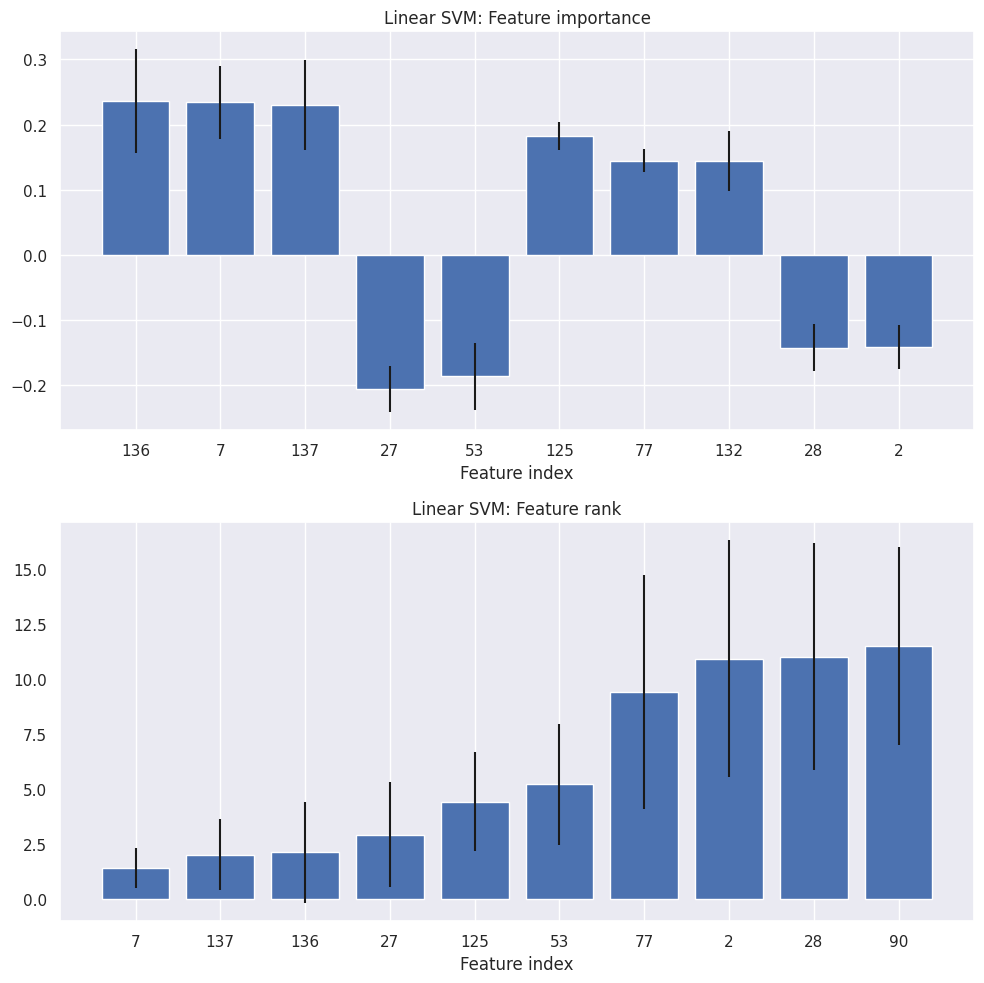

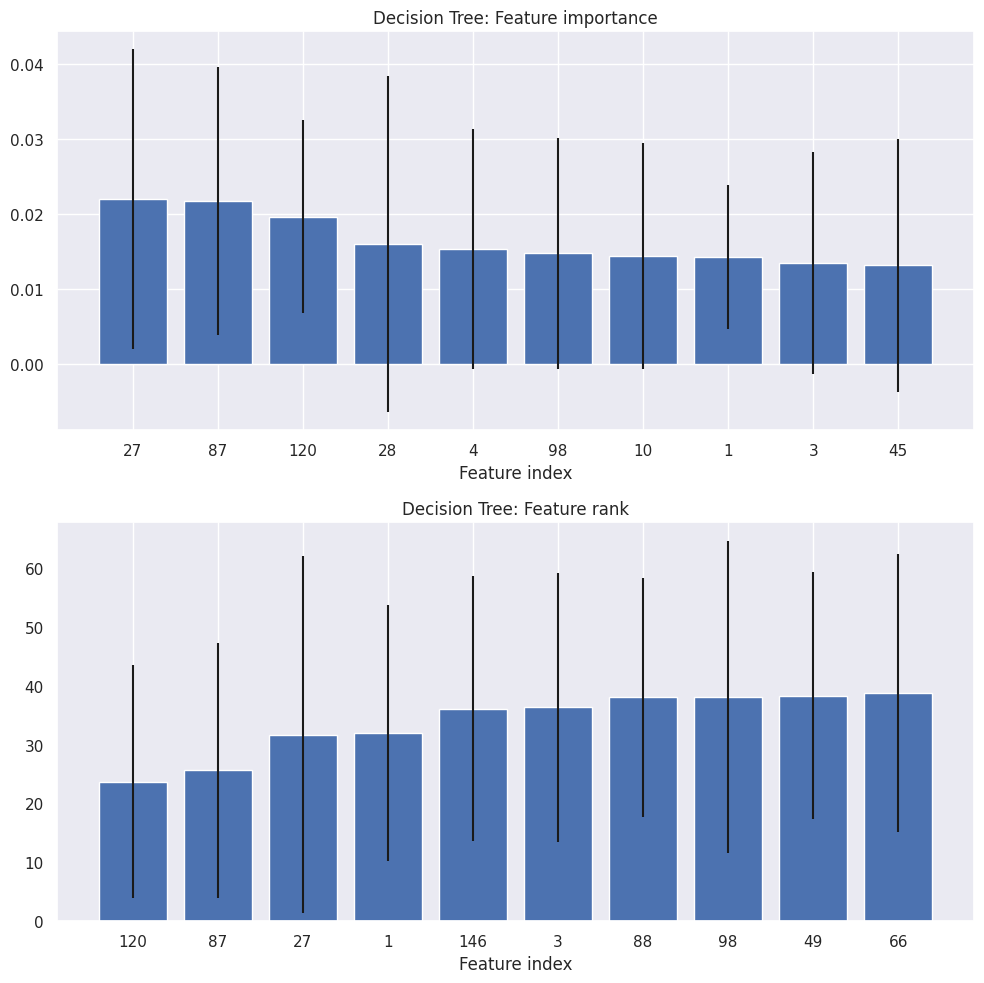

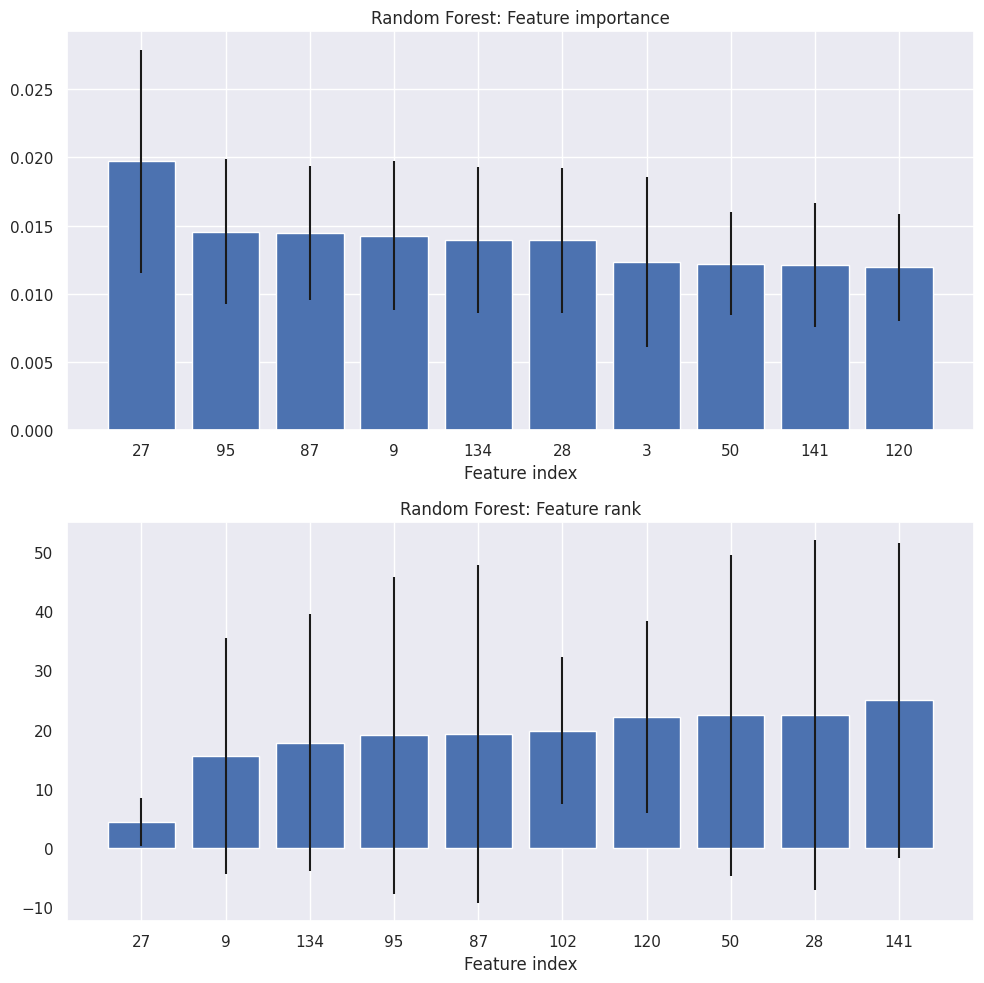

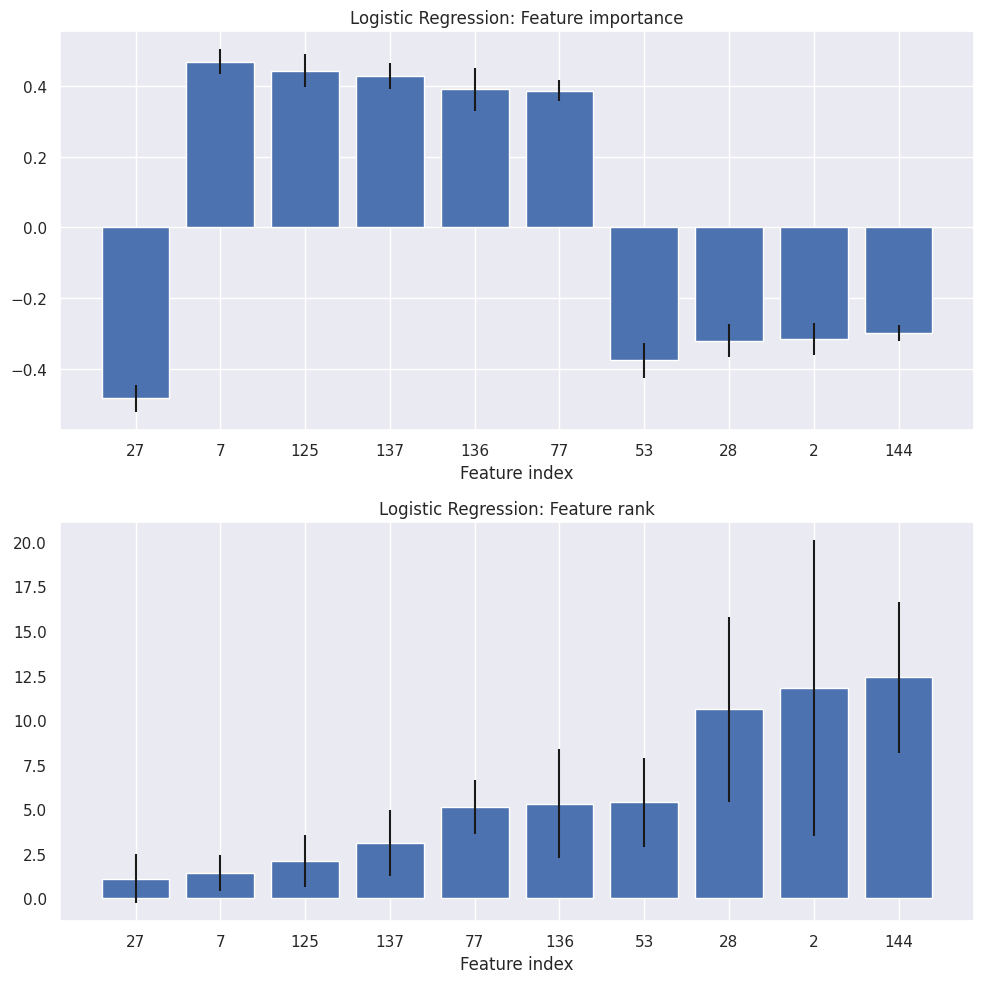

In [19]:
seed = ["opIFG_R"]

run_opIFG_R = run_poly(df_boot, data, seed)
run_opIFG_R.plot_scores()
run_opIFG_R.plot_features(ntop=10)

## planumtemp_R

2023-03-28 11:34:36,304 - polyssifier - INFO - Detected 2 classes in label
2023-03-28 11:34:36,305 - polyssifier - INFO - Building classifiers ...
2023-03-28 11:34:36,312 - polyssifier - INFO - Initialization, done.
2023-03-28 11:34:36,332 - polyssifier - INFO - Training Multilayer Perceptron 0
2023-03-28 11:34:39,019 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.86, 2.69 sec
2023-03-28 11:34:39,024 - polyssifier - INFO - Training Multilayer Perceptron 1
2023-03-28 11:34:42,111 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.83, 3.09 sec
2023-03-28 11:34:42,114 - polyssifier - INFO - Training Multilayer Perceptron 2
2023-03-28 11:34:44,924 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.83, 2.81 sec
2023-03-28 11:34:44,927 - polyssifier - INFO - Training Multilayer Perceptron 3
2023-03-28 11:34:47,643 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.79, 2.72 sec
2023-03-28 11:34:47,656 - polyss

predict proba return shape (57,)


2023-03-28 11:35:15,733 - polyssifier - INFO - Linear SVM                 1: Train 0.91/Test 0.81, 0.69 sec
2023-03-28 11:35:15,735 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2023-03-28 11:35:16,401 - polyssifier - INFO - Linear SVM                 2: Train 0.91/Test 0.80, 0.67 sec
2023-03-28 11:35:16,403 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2023-03-28 11:35:17,096 - polyssifier - INFO - Linear SVM                 3: Train 0.92/Test 0.78, 0.69 sec
2023-03-28 11:35:17,098 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2023-03-28 11:35:17,788 - polyssifier - INFO - Linear SVM                 4: Train 0.90/Test 0.81, 0.69 sec
2023-03-28 11:35:17,791 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2023-03-28 11:35:18,446 - polyssifier - INFO - Linear SVM                 5: Train 0.91/Test 0.75, 0.66 sec
2023-03-28 11:35:18,449 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2023-03-28 11:35:19,131 - polyssifier - INFO - Linear SVM                 6: Train 0.92/Test 0.73, 0.68 sec
2023-03-28 11:35:19,133 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2023-03-28 11:35:19,830 - polyssifier - INFO - Linear SVM                 7: Train 0.90/Test 0.74, 0.70 sec
2023-03-28 11:35:19,833 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2023-03-28 11:35:20,513 - polyssifier - INFO - Linear SVM                 8: Train 0.91/Test 0.73, 0.68 sec
2023-03-28 11:35:20,516 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2023-03-28 11:35:21,177 - polyssifier - INFO - Linear SVM                 9: Train 0.91/Test 0.79, 0.66 sec
2023-03-28 11:35:21,180 - polyssifier - INFO - Training Decision Tree 0
2023-03-28 11:35:21,198 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.59, 0.02 sec
2023-03-28 11:35:21,201 - polyssifier - INFO - Training Decision Tree 1
2023-03-28 11:35:21,218 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.63, 0.02 sec
2023-03-28 11:35:21,221 - polyssifier - INFO - Training Decision Tree 2
2023-03-28 11:35:21,240 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.56, 0.02 sec
2023-03-28 11:35:21,242 - polyssifier - INFO - Training Decision Tree 3
2023-03-28 11:35:21,253 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.54, 0.01 sec
2023-03-28 11:35:21,255 - polyssifier - INFO - Training Decision Tree 4
2023-03-28 11:35:21,267 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.58, 0

predict proba return shape (57,)


2023-03-28 11:35:22,740 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.74, 1.41 sec
2023-03-28 11:35:22,745 - polyssifier - INFO - Training Random Forest 1
2023-03-28 11:35:24,158 - polyssifier - INFO - Random Forest              1: Train 1.00/Test 0.63, 1.41 sec
2023-03-28 11:35:24,162 - polyssifier - INFO - Training Random Forest 2
2023-03-28 11:35:25,571 - polyssifier - INFO - Random Forest              2: Train 1.00/Test 0.65, 1.41 sec
2023-03-28 11:35:25,575 - polyssifier - INFO - Training Random Forest 3
2023-03-28 11:35:26,976 - polyssifier - INFO - Random Forest              3: Train 1.00/Test 0.64, 1.40 sec
2023-03-28 11:35:26,981 - polyssifier - INFO - Training Random Forest 4
2023-03-28 11:35:28,401 - polyssifier - INFO - Random Forest              4: Train 1.00/Test 0.71, 1.42 sec
2023-03-28 11:35:28,405 - polyssifier - INFO - Training Random Forest 5
2023-03-28 11:35:29,770 - polyssifier - INFO - Random Forest              5: Train 1.00/Test 0.62, 1

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.843462  0.047525  0.761787  0.900744
Nearest Neighbors     train  0.796030  0.005813  0.784339  0.801871
                      test   0.720021  0.078798  0.625310  0.849256
SVM                   train  0.978836  0.001687  0.976883  0.981624
                      test   0.838401  0.041189  0.788889  0.909429
Linear SVM            train  0.908662  0.005144  0.901589  0.916241
                      test   0.780025  0.040288  0.730769  0.851852
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.613857  0.047430  0.542593  0.687965
Random Forest         train  0.999627  0.000666  0.997913  1.000000
                      test   0.670641  0.065914  0.546526  0.749380
Logistic Regression   train  0.909660  0.003937  0.903657  0.916272
                      test   0.783247  0.043422 

2023-03-28 11:35:41,326 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-28 11:35:41,613 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-28 11:35:41,899 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-28 11:35:42,201 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


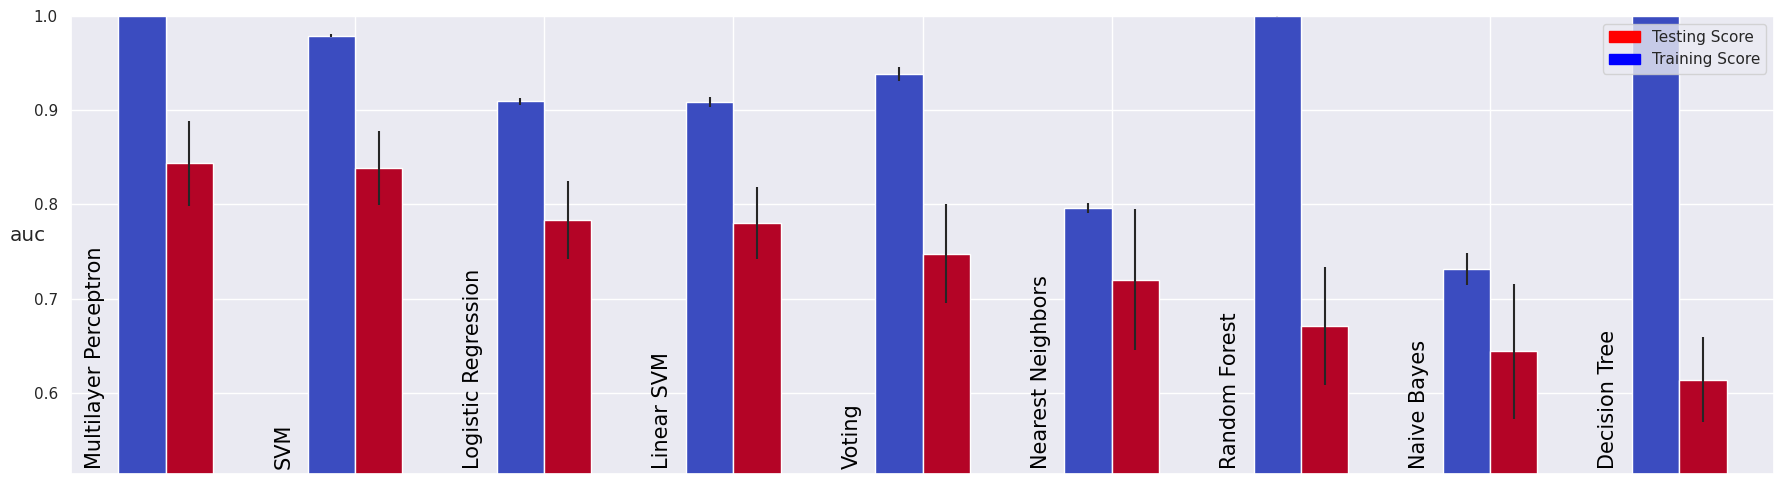

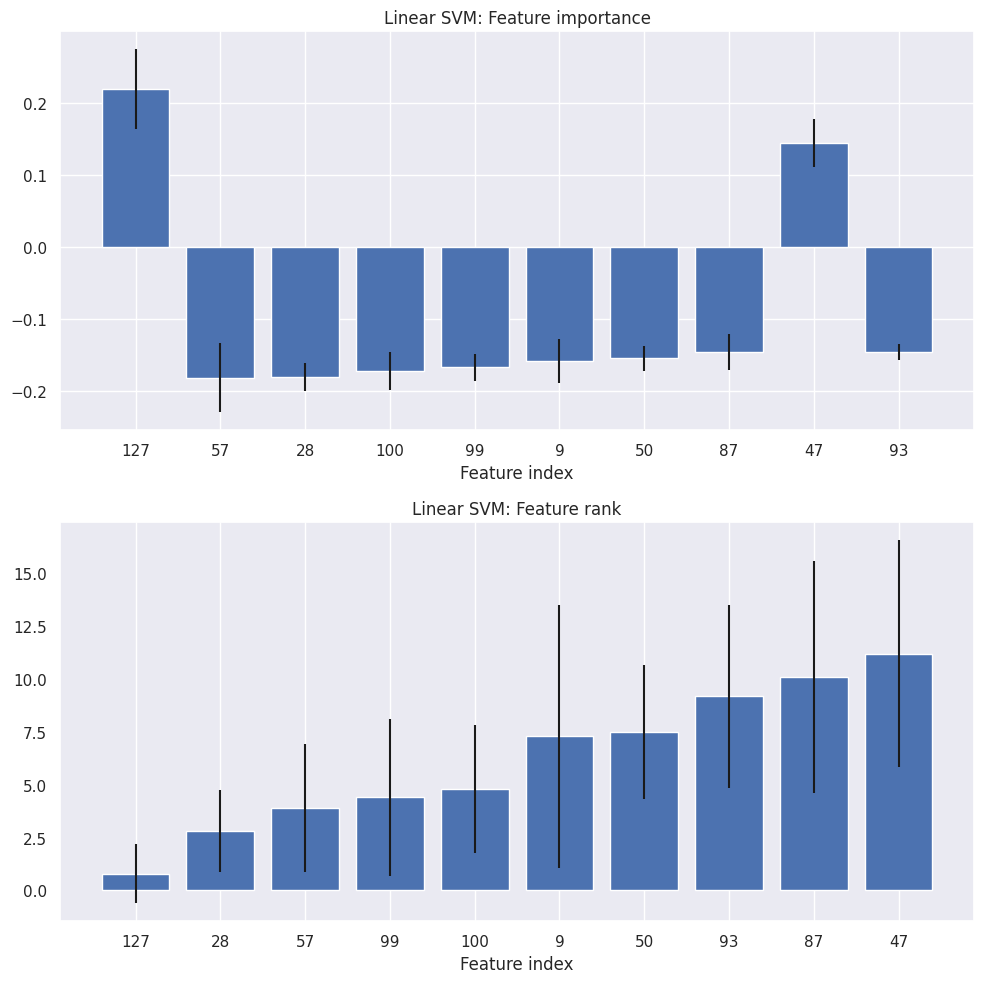

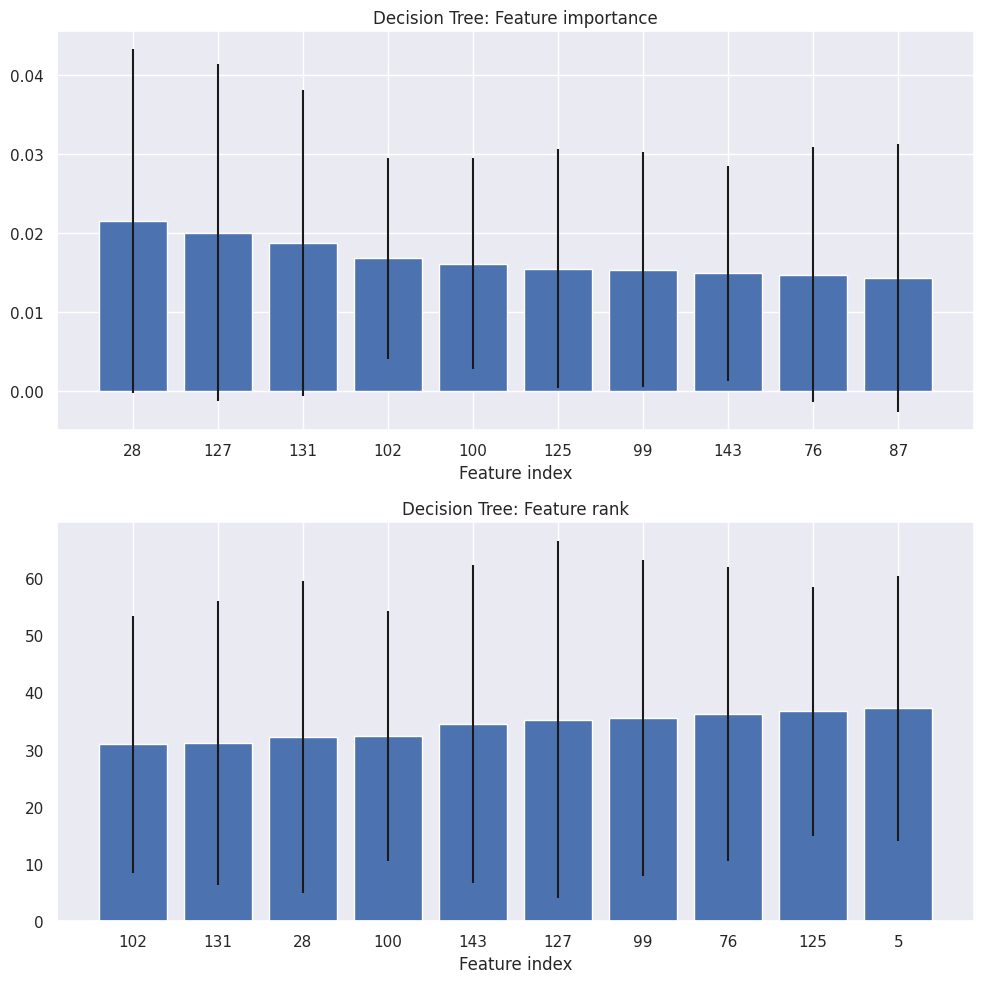

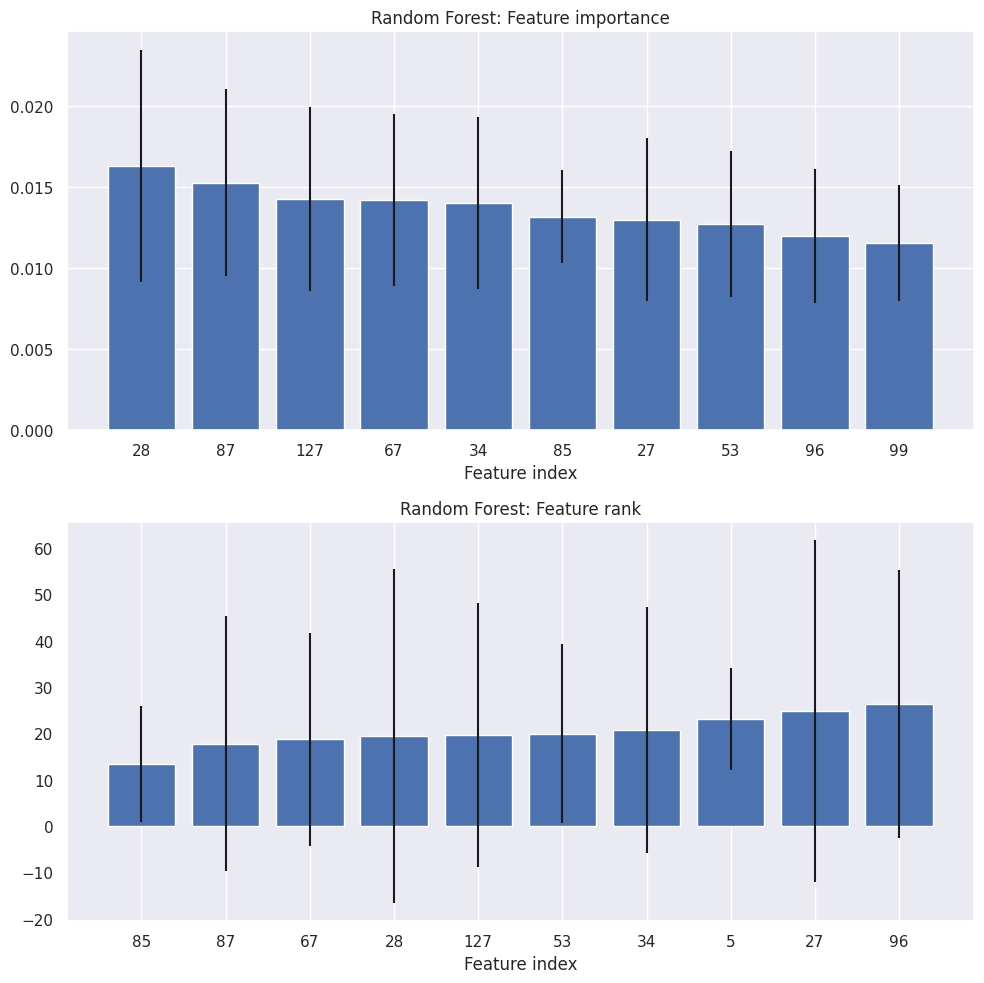

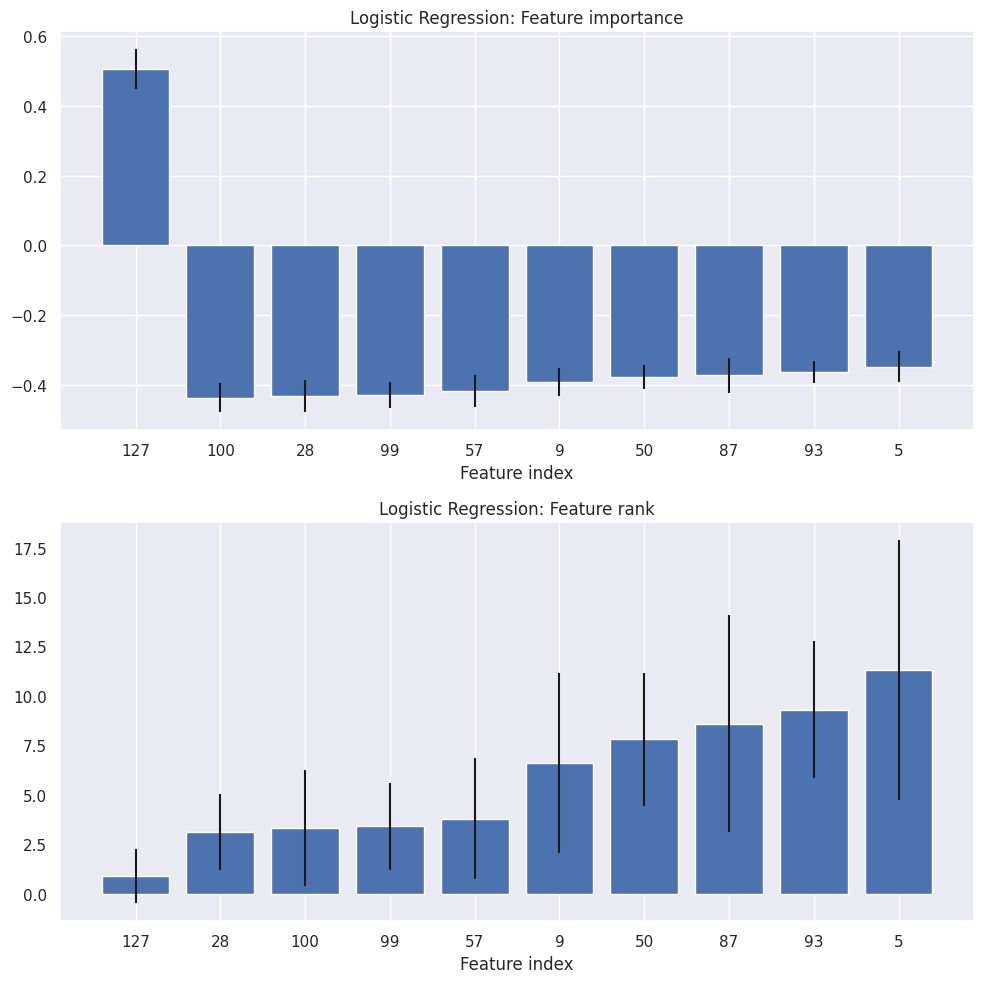

In [20]:
seed = ["planumtemp_R"]

run_planumtemp_R = run_poly(df_boot, data, seed)
run_planumtemp_R.plot_scores()
run_planumtemp_R.plot_features(ntop=10)

## aMTG_R

2023-03-28 11:42:48,637 - polyssifier - INFO - Detected 2 classes in label
2023-03-28 11:42:48,637 - polyssifier - INFO - Building classifiers ...
2023-03-28 11:42:48,641 - polyssifier - INFO - Initialization, done.
2023-03-28 11:42:48,659 - polyssifier - INFO - Training Multilayer Perceptron 0
2023-03-28 11:42:51,191 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.90, 2.53 sec
2023-03-28 11:42:51,194 - polyssifier - INFO - Training Multilayer Perceptron 1
2023-03-28 11:42:53,618 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.89, 2.42 sec
2023-03-28 11:42:53,620 - polyssifier - INFO - Training Multilayer Perceptron 2
2023-03-28 11:42:55,983 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.94, 2.36 sec
2023-03-28 11:42:55,986 - polyssifier - INFO - Training Multilayer Perceptron 3
2023-03-28 11:42:58,599 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.93, 2.61 sec
2023-03-28 11:42:58,602 - polyss

predict proba return shape (57,)


2023-03-28 11:43:25,183 - polyssifier - INFO - Linear SVM                 1: Train 0.92/Test 0.86, 0.66 sec
2023-03-28 11:43:25,185 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2023-03-28 11:43:25,833 - polyssifier - INFO - Linear SVM                 2: Train 0.92/Test 0.87, 0.65 sec
2023-03-28 11:43:25,835 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2023-03-28 11:43:26,466 - polyssifier - INFO - Linear SVM                 3: Train 0.92/Test 0.91, 0.63 sec
2023-03-28 11:43:26,468 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2023-03-28 11:43:27,129 - polyssifier - INFO - Linear SVM                 4: Train 0.93/Test 0.78, 0.66 sec
2023-03-28 11:43:27,131 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2023-03-28 11:43:27,789 - polyssifier - INFO - Linear SVM                 5: Train 0.93/Test 0.86, 0.66 sec
2023-03-28 11:43:27,791 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2023-03-28 11:43:28,446 - polyssifier - INFO - Linear SVM                 6: Train 0.92/Test 0.88, 0.65 sec
2023-03-28 11:43:28,448 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2023-03-28 11:43:29,100 - polyssifier - INFO - Linear SVM                 7: Train 0.93/Test 0.79, 0.65 sec
2023-03-28 11:43:29,102 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2023-03-28 11:43:29,775 - polyssifier - INFO - Linear SVM                 8: Train 0.93/Test 0.79, 0.67 sec
2023-03-28 11:43:29,777 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2023-03-28 11:43:30,424 - polyssifier - INFO - Linear SVM                 9: Train 0.93/Test 0.81, 0.65 sec
2023-03-28 11:43:30,426 - polyssifier - INFO - Training Decision Tree 0
2023-03-28 11:43:30,443 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.64, 0.02 sec
2023-03-28 11:43:30,445 - polyssifier - INFO - Training Decision Tree 1
2023-03-28 11:43:30,463 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.47, 0.02 sec
2023-03-28 11:43:30,465 - polyssifier - INFO - Training Decision Tree 2
2023-03-28 11:43:30,483 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.51, 0.02 sec
2023-03-28 11:43:30,485 - polyssifier - INFO - Training Decision Tree 3
2023-03-28 11:43:30,497 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.56, 0.01 sec
2023-03-28 11:43:30,499 - polyssifier - INFO - Training Decision Tree 4
2023-03-28 11:43:30,510 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.61, 0

predict proba return shape (57,)


2023-03-28 11:43:31,949 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.69, 1.38 sec
2023-03-28 11:43:31,954 - polyssifier - INFO - Training Random Forest 1
2023-03-28 11:43:33,326 - polyssifier - INFO - Random Forest              1: Train 1.00/Test 0.59, 1.37 sec
2023-03-28 11:43:33,330 - polyssifier - INFO - Training Random Forest 2
2023-03-28 11:43:34,713 - polyssifier - INFO - Random Forest              2: Train 1.00/Test 0.76, 1.38 sec
2023-03-28 11:43:34,718 - polyssifier - INFO - Training Random Forest 3
2023-03-28 11:43:36,112 - polyssifier - INFO - Random Forest              3: Train 1.00/Test 0.85, 1.39 sec
2023-03-28 11:43:36,117 - polyssifier - INFO - Training Random Forest 4
2023-03-28 11:43:37,497 - polyssifier - INFO - Random Forest              4: Train 1.00/Test 0.75, 1.38 sec
2023-03-28 11:43:37,502 - polyssifier - INFO - Training Random Forest 5
2023-03-28 11:43:38,907 - polyssifier - INFO - Random Forest              5: Train 1.00/Test 0.59, 1

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.890251  0.034268  0.838710  0.938272
Nearest Neighbors     train  0.813383  0.008939  0.798724  0.826194
                      test   0.740643  0.078660  0.632134  0.907568
SVM                   train  0.988527  0.001307  0.986631  0.990542
                      test   0.880030  0.043810  0.818519  0.956576
Linear SVM            train  0.926738  0.005256  0.918043  0.933705
                      test   0.831555  0.048848  0.772840  0.909877
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.592898  0.062607  0.472222  0.681762
Random Forest         train  0.999992  0.000021  0.999931  1.000000
                      test   0.723379  0.094354  0.587469  0.877171
Logistic Regression   train  0.927998  0.004548  0.922109  0.933140
                      test   0.838985  0.043673 

2023-03-28 11:43:50,175 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-28 11:43:50,467 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-28 11:43:50,899 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-28 11:43:51,187 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


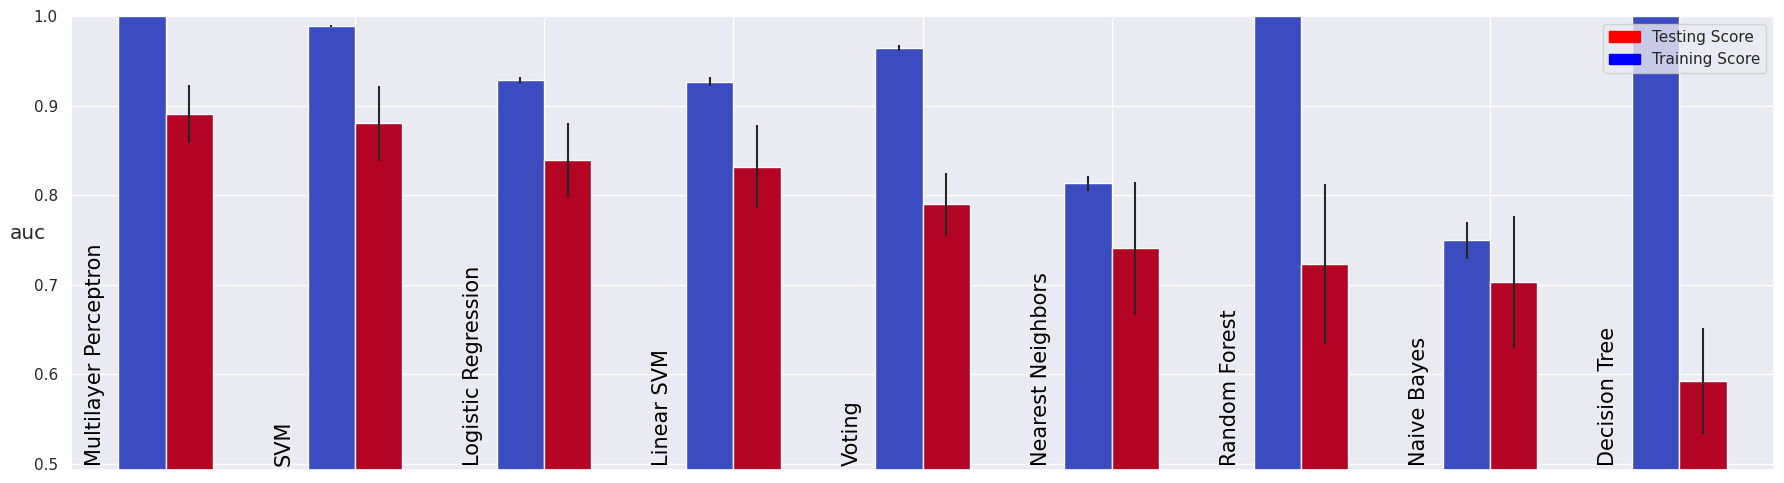

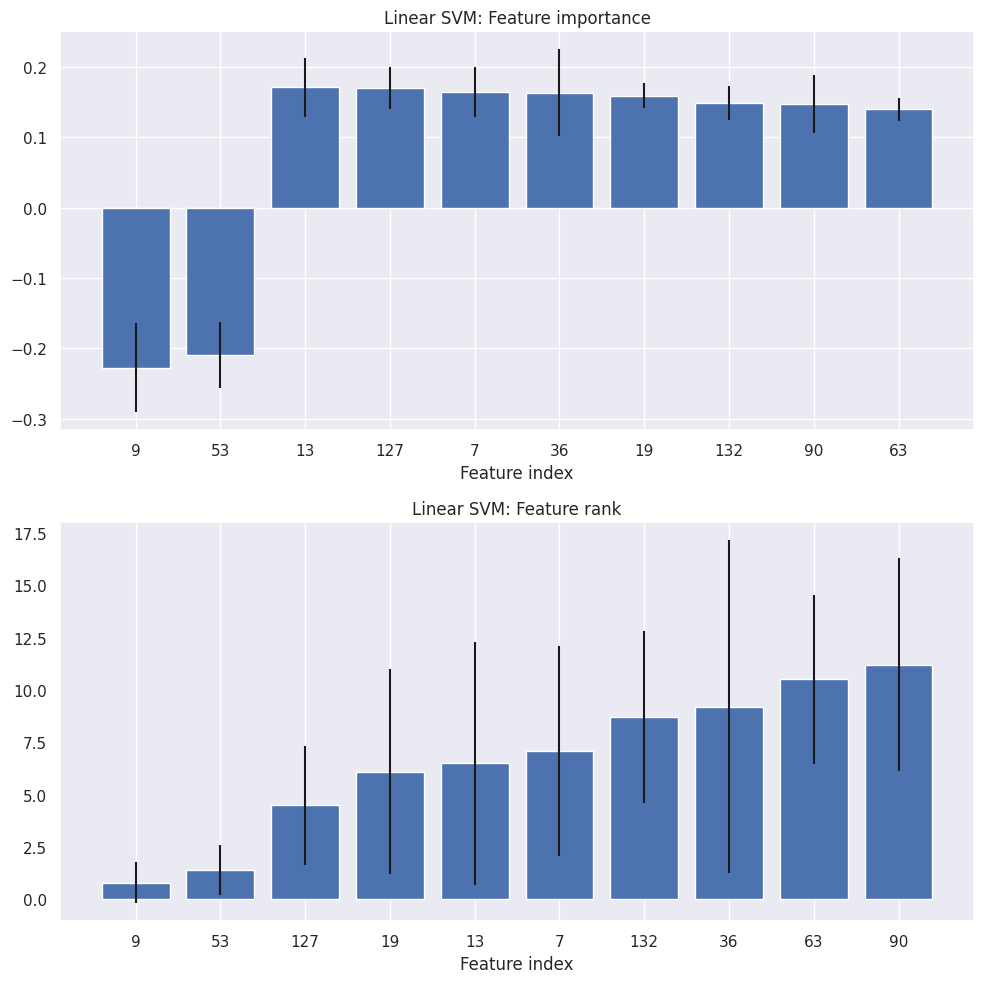

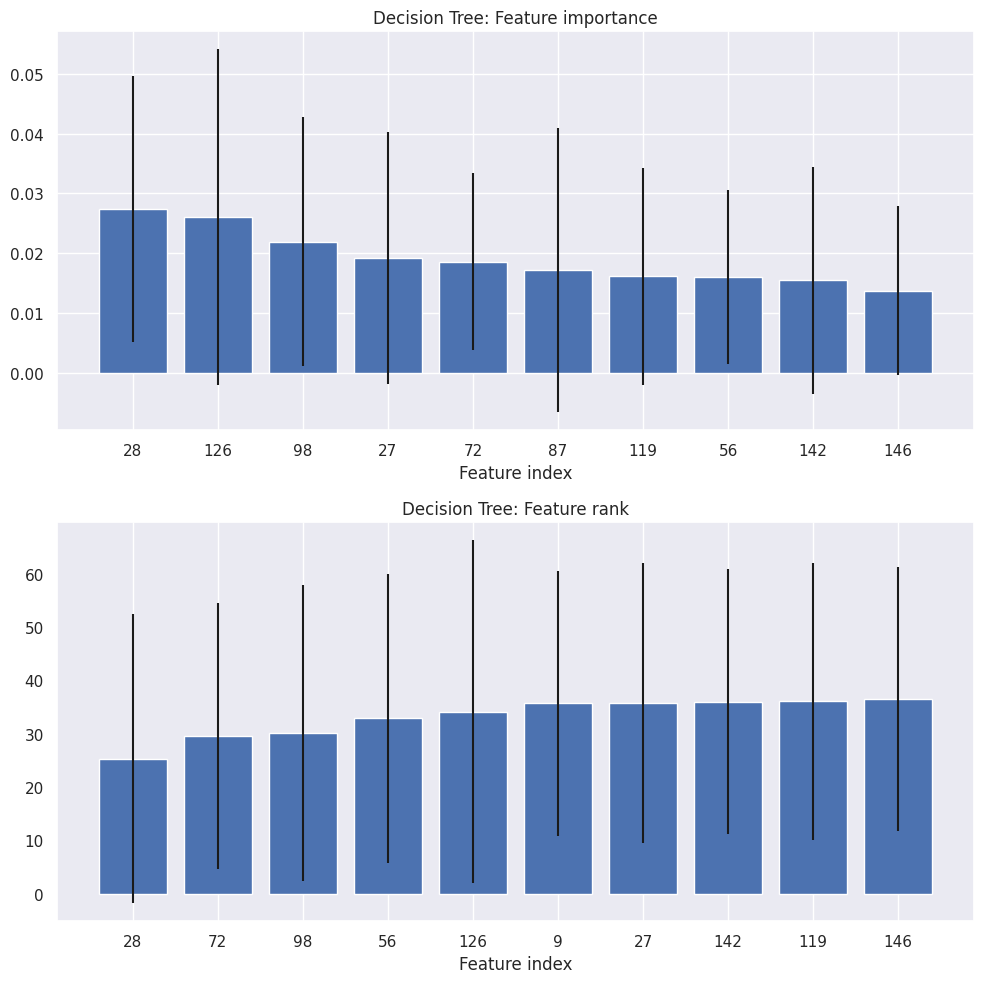

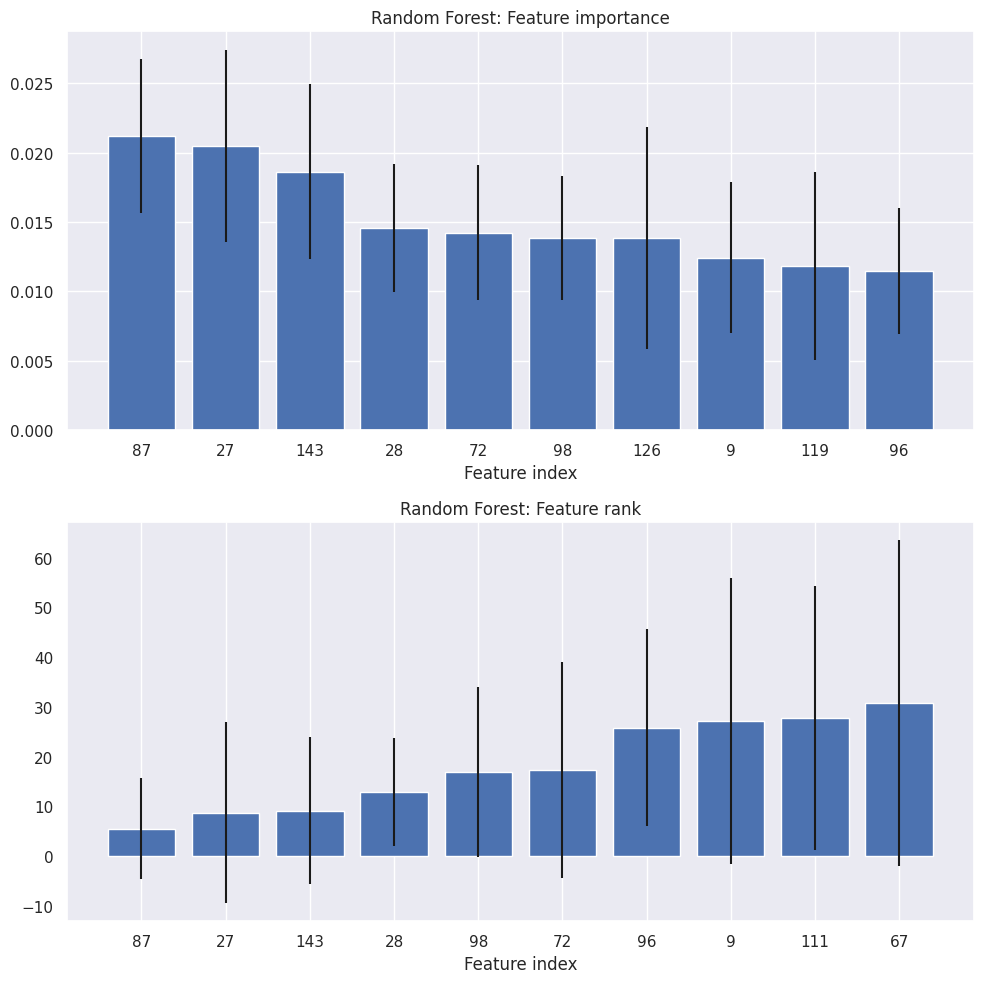

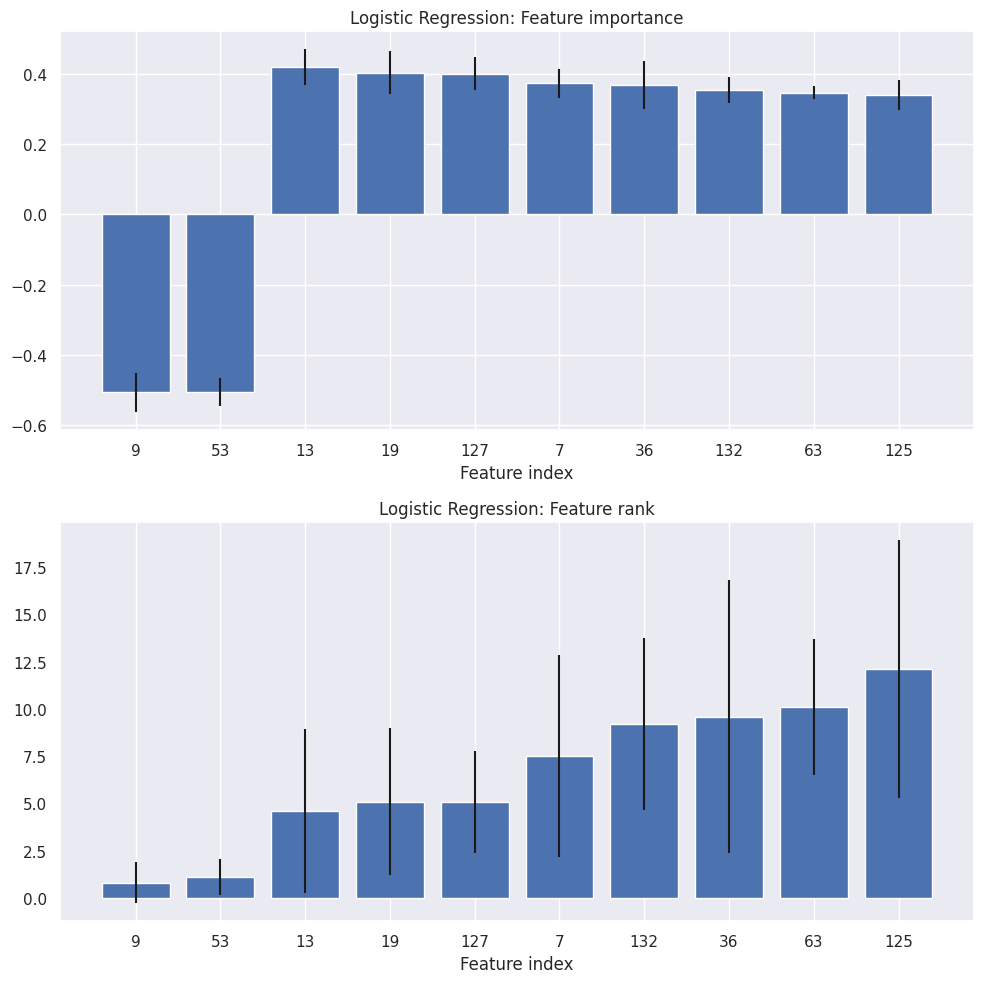

In [21]:
seed = ["aMTG_R"]

run_aMTG_R = run_poly(df_boot, data, seed)
run_aMTG_R.plot_scores()
run_aMTG_R.plot_features(ntop=10)

## pITG_R

2023-03-28 11:45:37,645 - polyssifier - INFO - Detected 2 classes in label
2023-03-28 11:45:37,646 - polyssifier - INFO - Building classifiers ...
2023-03-28 11:45:37,650 - polyssifier - INFO - Initialization, done.
2023-03-28 11:45:37,669 - polyssifier - INFO - Training Multilayer Perceptron 0
2023-03-28 11:45:40,793 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.86, 3.12 sec
2023-03-28 11:45:40,796 - polyssifier - INFO - Training Multilayer Perceptron 1
2023-03-28 11:45:43,695 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.89, 2.90 sec
2023-03-28 11:45:43,698 - polyssifier - INFO - Training Multilayer Perceptron 2
2023-03-28 11:45:46,510 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.79, 2.81 sec
2023-03-28 11:45:46,513 - polyssifier - INFO - Training Multilayer Perceptron 3
2023-03-28 11:45:49,315 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.90, 2.80 sec
2023-03-28 11:45:49,317 - polyss

predict proba return shape (57,)


2023-03-28 11:46:17,218 - polyssifier - INFO - Linear SVM                 1: Train 0.78/Test 0.61, 0.78 sec
2023-03-28 11:46:17,220 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2023-03-28 11:46:17,961 - polyssifier - INFO - Linear SVM                 2: Train 0.63/Test 0.52, 0.74 sec
2023-03-28 11:46:17,963 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2023-03-28 11:46:18,715 - polyssifier - INFO - Linear SVM                 3: Train 0.77/Test 0.66, 0.75 sec
2023-03-28 11:46:18,717 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2023-03-28 11:46:19,417 - polyssifier - INFO - Linear SVM                 4: Train 0.61/Test 0.53, 0.70 sec
2023-03-28 11:46:19,419 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2023-03-28 11:46:20,100 - polyssifier - INFO - Linear SVM                 5: Train 0.62/Test 0.46, 0.68 sec
2023-03-28 11:46:20,102 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2023-03-28 11:46:20,853 - polyssifier - INFO - Linear SVM                 6: Train 0.79/Test 0.55, 0.75 sec
2023-03-28 11:46:20,856 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2023-03-28 11:46:21,625 - polyssifier - INFO - Linear SVM                 7: Train 0.79/Test 0.54, 0.77 sec
2023-03-28 11:46:21,628 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2023-03-28 11:46:22,393 - polyssifier - INFO - Linear SVM                 8: Train 0.78/Test 0.55, 0.77 sec
2023-03-28 11:46:22,396 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2023-03-28 11:46:23,082 - polyssifier - INFO - Linear SVM                 9: Train 0.63/Test 0.56, 0.69 sec
2023-03-28 11:46:23,084 - polyssifier - INFO - Training Decision Tree 0
2023-03-28 11:46:23,099 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.56, 0.01 sec
2023-03-28 11:46:23,102 - polyssifier - INFO - Training Decision Tree 1
2023-03-28 11:46:23,119 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.53, 0.02 sec
2023-03-28 11:46:23,122 - polyssifier - INFO - Training Decision Tree 2
2023-03-28 11:46:23,137 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.47, 0.02 sec
2023-03-28 11:46:23,140 - polyssifier - INFO - Training Decision Tree 3
2023-03-28 11:46:23,153 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.49, 0.01 sec
2023-03-28 11:46:23,155 - polyssifier - INFO - Training Decision Tree 4
2023-03-28 11:46:23,168 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.61, 0

predict proba return shape (57,)


2023-03-28 11:46:24,710 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.63, 1.48 sec
2023-03-28 11:46:24,715 - polyssifier - INFO - Training Random Forest 1
2023-03-28 11:46:26,156 - polyssifier - INFO - Random Forest              1: Train 1.00/Test 0.63, 1.44 sec
2023-03-28 11:46:26,161 - polyssifier - INFO - Training Random Forest 2
2023-03-28 11:46:27,588 - polyssifier - INFO - Random Forest              2: Train 1.00/Test 0.65, 1.43 sec
2023-03-28 11:46:27,592 - polyssifier - INFO - Training Random Forest 3
2023-03-28 11:46:29,036 - polyssifier - INFO - Random Forest              3: Train 1.00/Test 0.73, 1.44 sec
2023-03-28 11:46:29,041 - polyssifier - INFO - Training Random Forest 4
2023-03-28 11:46:30,509 - polyssifier - INFO - Random Forest              4: Train 1.00/Test 0.61, 1.47 sec
2023-03-28 11:46:30,514 - polyssifier - INFO - Training Random Forest 5
2023-03-28 11:46:31,976 - polyssifier - INFO - Random Forest              5: Train 1.00/Test 0.58, 1

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.820753  0.051285  0.725806  0.895062
Nearest Neighbors     train  0.836226  0.007714  0.825584  0.848770
                      test   0.720643  0.087432  0.553970  0.859801
SVM                   train  0.970933  0.002981  0.965320  0.975523
                      test   0.800727  0.065319  0.648883  0.866005
Linear SVM            train  0.722418  0.089421  0.612116  0.835978
                      test   0.547501  0.057322  0.462779  0.664198
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.543029  0.073086  0.472222  0.710918
Random Forest         train  0.999930  0.000131  0.999564  1.000000
                      test   0.646148  0.094117  0.510546  0.826303
Logistic Regression   train  0.644143  0.003993  0.637834  0.651398
                      test   0.594500  0.053436 

2023-03-28 11:46:43,779 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-28 11:46:44,069 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-28 11:46:44,364 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-28 11:46:44,661 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


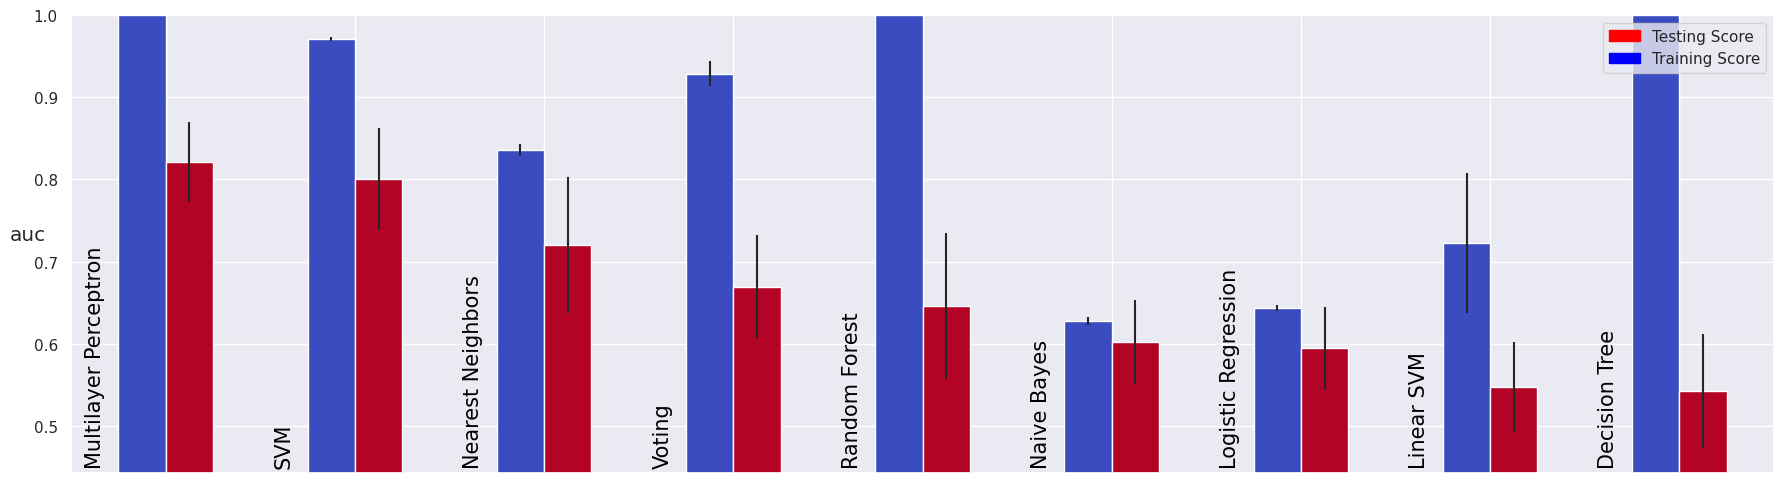

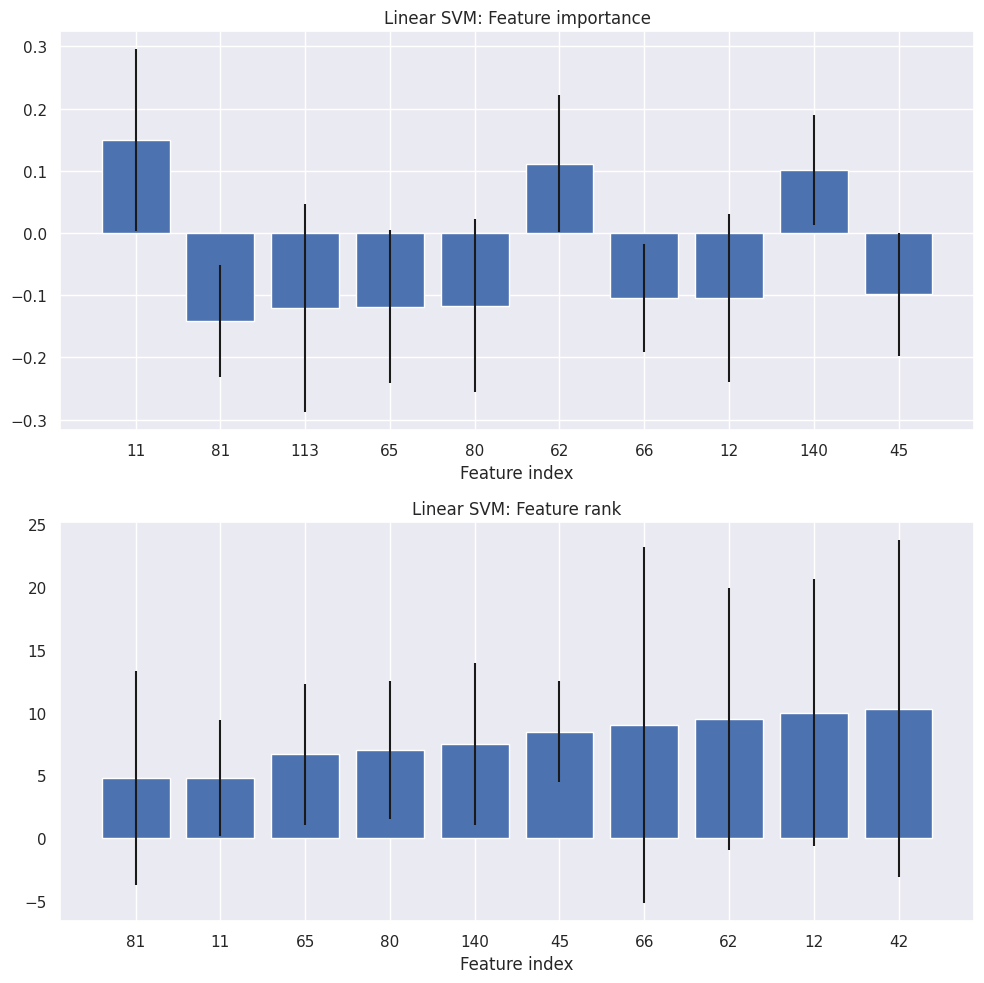

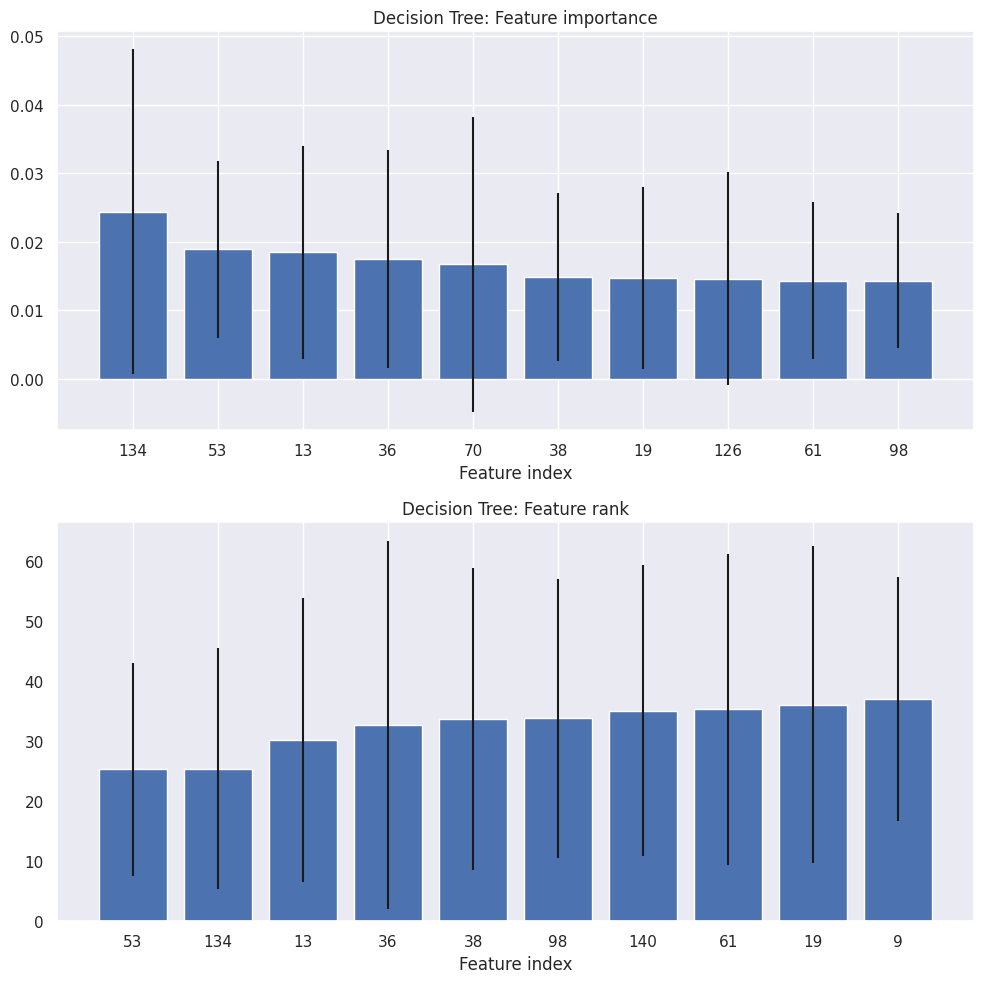

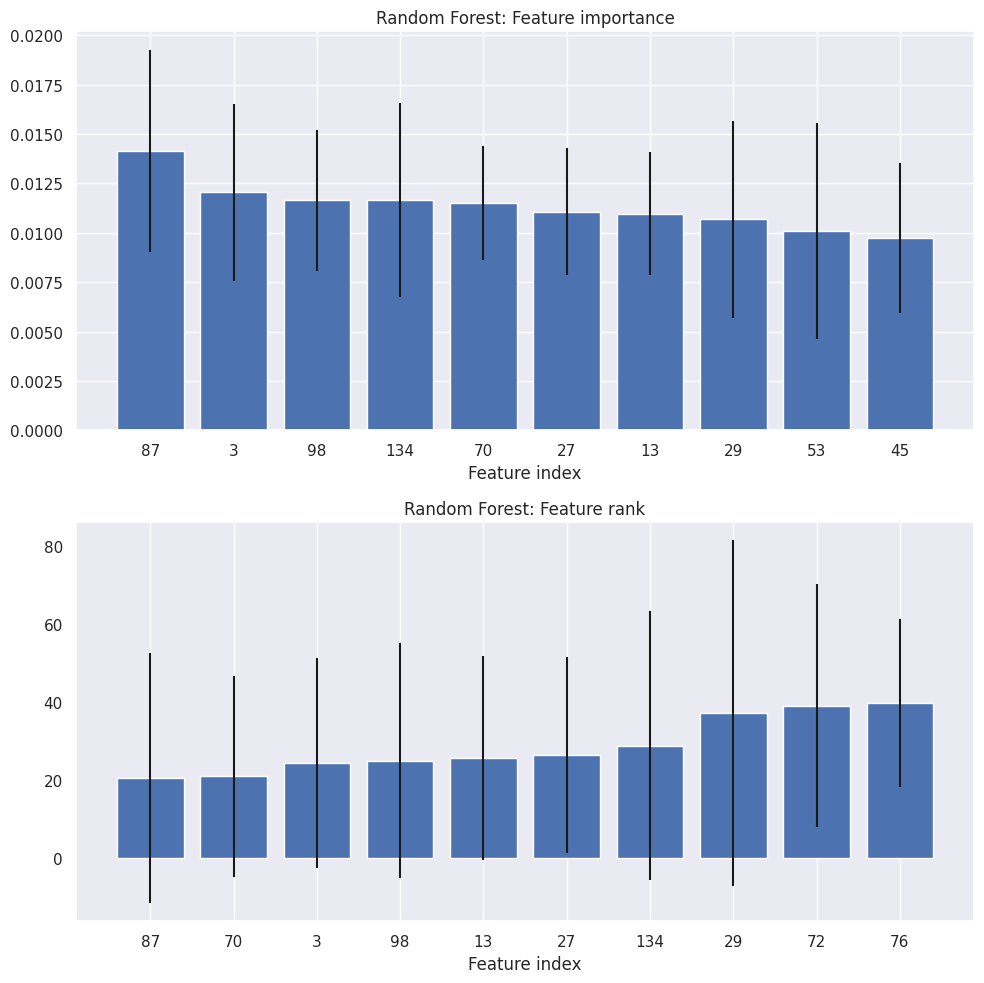

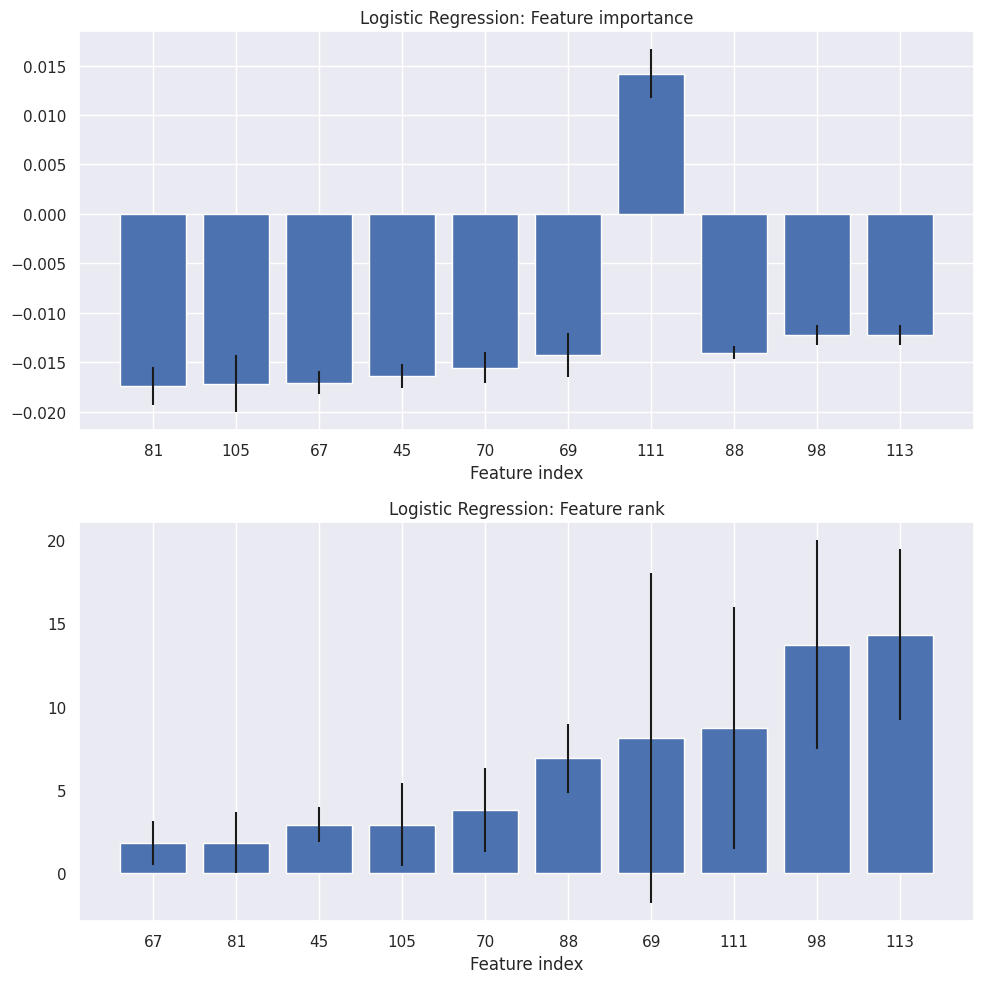

In [22]:
seed = ["pITG_R"]

run_pITG_R = run_poly(df_boot, data, seed)
run_pITG_R.plot_scores()
run_pITG_R.plot_features(ntop=10)

## All left

2023-03-28 11:48:02,902 - polyssifier - INFO - Detected 2 classes in label
2023-03-28 11:48:02,903 - polyssifier - INFO - Building classifiers ...
2023-03-28 11:48:02,907 - polyssifier - INFO - Initialization, done.
2023-03-28 11:48:02,932 - polyssifier - INFO - Training Multilayer Perceptron 0
2023-03-28 11:48:05,160 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.84, 2.23 sec
2023-03-28 11:48:05,166 - polyssifier - INFO - Training Multilayer Perceptron 1
2023-03-28 11:48:07,362 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.83, 2.20 sec
2023-03-28 11:48:07,368 - polyssifier - INFO - Training Multilayer Perceptron 2
2023-03-28 11:48:09,763 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.92, 2.39 sec
2023-03-28 11:48:09,768 - polyssifier - INFO - Training Multilayer Perceptron 3
2023-03-28 11:48:12,331 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.87, 2.56 sec
2023-03-28 11:48:12,335 - polyss

predict proba return shape (57,)


2023-03-28 11:49:00,165 - polyssifier - INFO - Linear SVM                 1: Train 0.99/Test 0.82, 4.36 sec
2023-03-28 11:49:00,169 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2023-03-28 11:49:04,413 - polyssifier - INFO - Linear SVM                 2: Train 1.00/Test 0.76, 4.24 sec
2023-03-28 11:49:04,417 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2023-03-28 11:49:09,553 - polyssifier - INFO - Linear SVM                 3: Train 1.00/Test 0.78, 5.14 sec
2023-03-28 11:49:09,558 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2023-03-28 11:49:14,192 - polyssifier - INFO - Linear SVM                 4: Train 1.00/Test 0.77, 4.63 sec
2023-03-28 11:49:14,196 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2023-03-28 11:49:18,896 - polyssifier - INFO - Linear SVM                 5: Train 1.00/Test 0.76, 4.70 sec
2023-03-28 11:49:18,901 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2023-03-28 11:49:23,333 - polyssifier - INFO - Linear SVM                 6: Train 1.00/Test 0.78, 4.43 sec
2023-03-28 11:49:23,337 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2023-03-28 11:49:27,859 - polyssifier - INFO - Linear SVM                 7: Train 1.00/Test 0.74, 4.52 sec
2023-03-28 11:49:27,865 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2023-03-28 11:49:32,378 - polyssifier - INFO - Linear SVM                 8: Train 1.00/Test 0.71, 4.51 sec
2023-03-28 11:49:32,383 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2023-03-28 11:49:37,243 - polyssifier - INFO - Linear SVM                 9: Train 1.00/Test 0.78, 4.86 sec
2023-03-28 11:49:37,248 - polyssifier - INFO - Training Decision Tree 0
2023-03-28 11:49:37,278 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.58, 0.03 sec
2023-03-28 11:49:37,284 - polyssifier - INFO - Training Decision Tree 1
2023-03-28 11:49:37,311 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.58, 0.03 sec
2023-03-28 11:49:37,315 - polyssifier - INFO - Training Decision Tree 2
2023-03-28 11:49:37,335 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.52, 0.02 sec
2023-03-28 11:49:37,340 - polyssifier - INFO - Training Decision Tree 3
2023-03-28 11:49:37,359 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.62, 0.02 sec
2023-03-28 11:49:37,363 - polyssifier - INFO - Training Decision Tree 4
2023-03-28 11:49:37,381 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.53, 0

predict proba return shape (57,)


2023-03-28 11:49:37,450 - polyssifier - INFO - Decision Tree              7: Train 1.00/Test 0.48, 0.02 sec
2023-03-28 11:49:37,455 - polyssifier - INFO - Training Decision Tree 8
2023-03-28 11:49:37,473 - polyssifier - INFO - Decision Tree              8: Train 1.00/Test 0.62, 0.02 sec
2023-03-28 11:49:37,477 - polyssifier - INFO - Training Decision Tree 9
2023-03-28 11:49:37,495 - polyssifier - INFO - Decision Tree              9: Train 1.00/Test 0.52, 0.02 sec
2023-03-28 11:49:37,499 - polyssifier - INFO - Training Random Forest 0
2023-03-28 11:49:39,642 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.74, 2.14 sec
2023-03-28 11:49:39,648 - polyssifier - INFO - Training Random Forest 1
2023-03-28 11:49:41,805 - polyssifier - INFO - Random Forest              1: Train 1.00/Test 0.62, 2.16 sec
2023-03-28 11:49:41,812 - polyssifier - INFO - Training Random Forest 2
2023-03-28 11:49:43,978 - polyssifier - INFO - Random Forest              2: Train 1.00/Test 0.74, 2

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.824213  0.055281  0.728288  0.918519
Nearest Neighbors     train  0.782451  0.015272  0.762612  0.816295
                      test   0.697053  0.054714  0.617901  0.813580
SVM                   train  0.989386  0.001292  0.988037  0.992254
                      test   0.793347  0.076337  0.702233  0.884615
Linear SVM            train  0.997880  0.004093  0.986287  0.999633
                      test   0.776928  0.045989  0.705955  0.875309
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.570323  0.053808  0.475806  0.643300
Random Forest         train  0.999963  0.000048  0.999862  1.000000
                      test   0.705235  0.055480  0.620370  0.774814
Logistic Regression   train  0.984144  0.047415  0.849202  0.999710
                      test   0.770899  0.051335 

2023-03-28 11:50:06,953 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-28 11:50:07,358 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-28 11:50:07,656 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-28 11:50:07,941 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


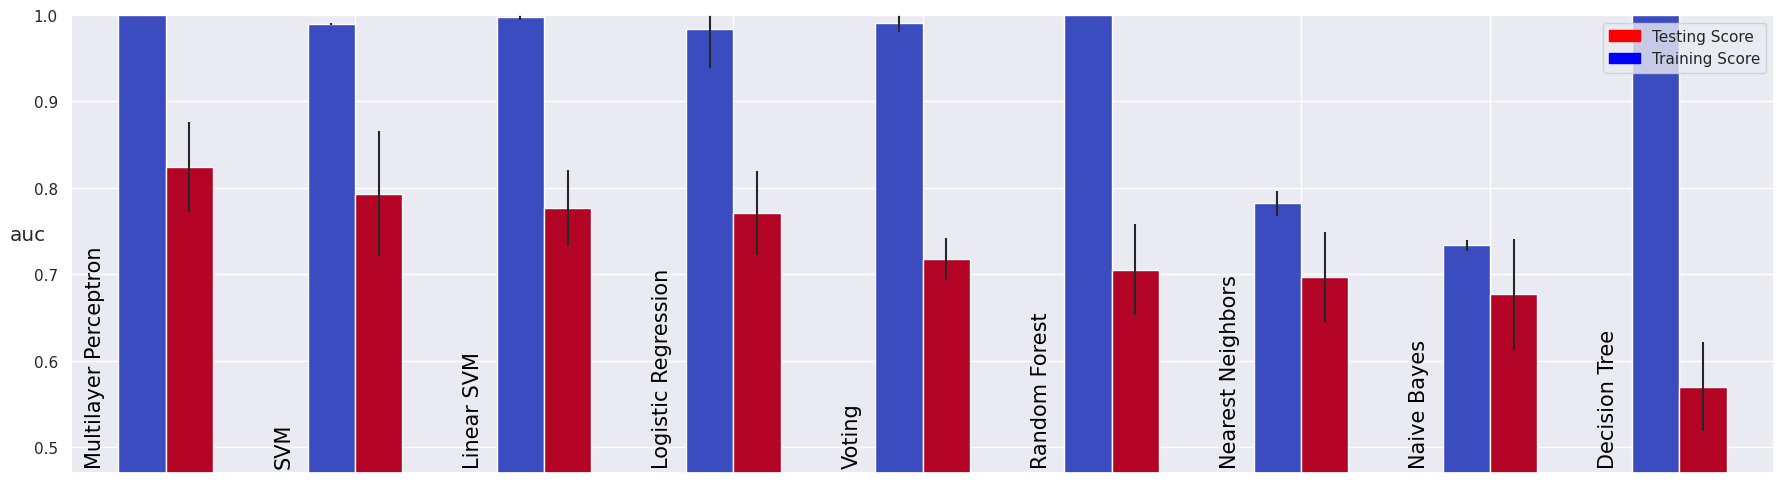

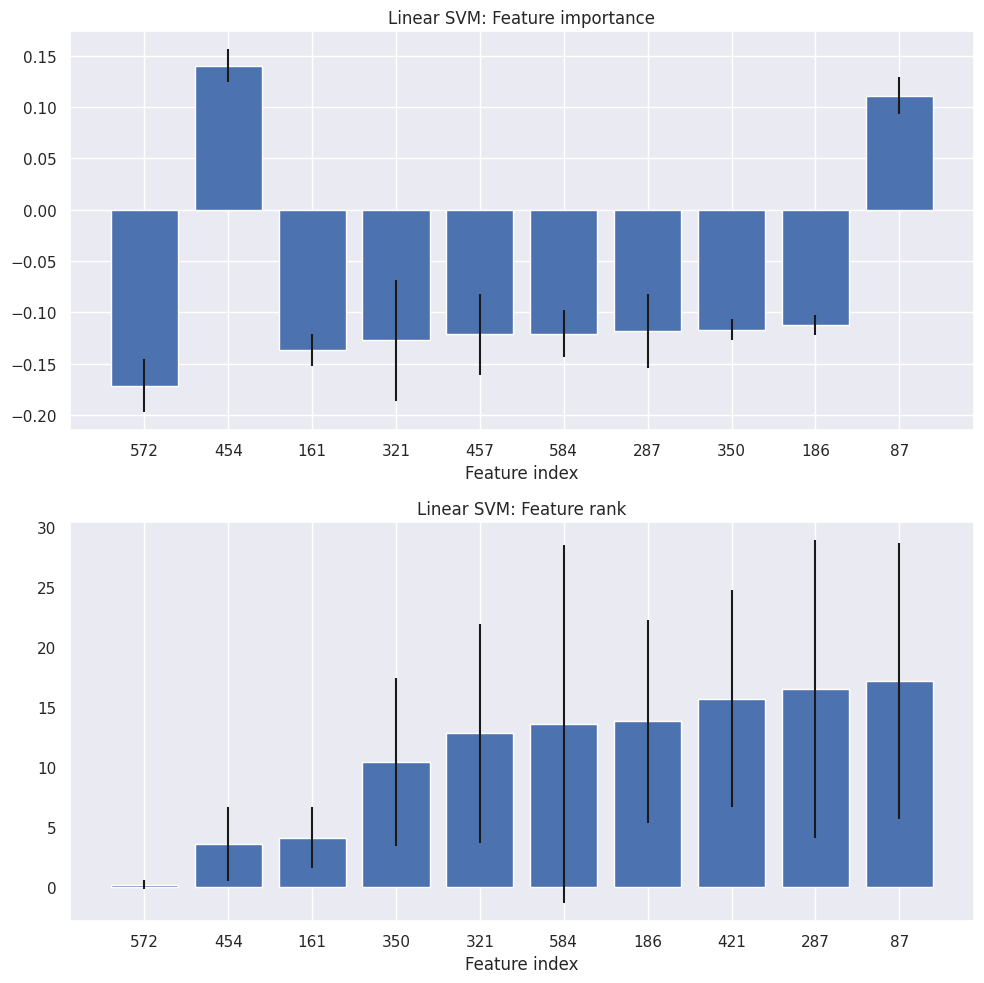

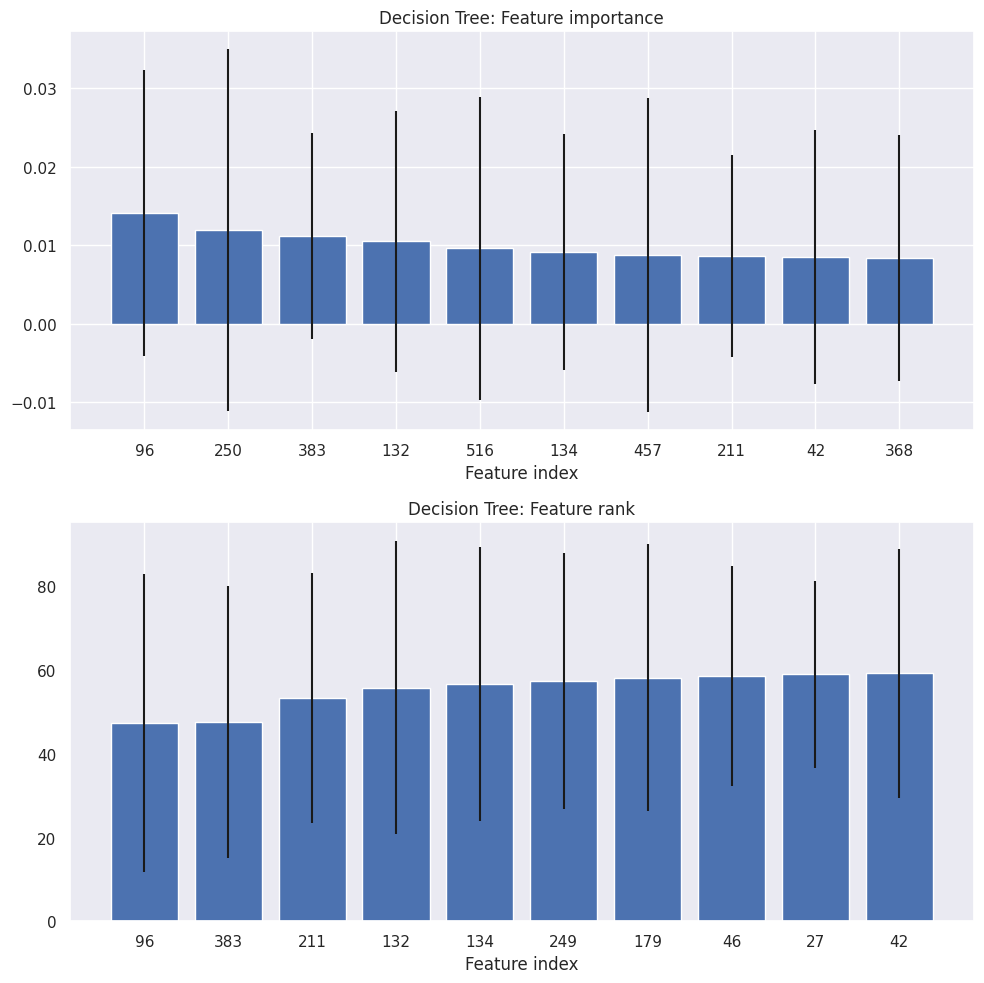

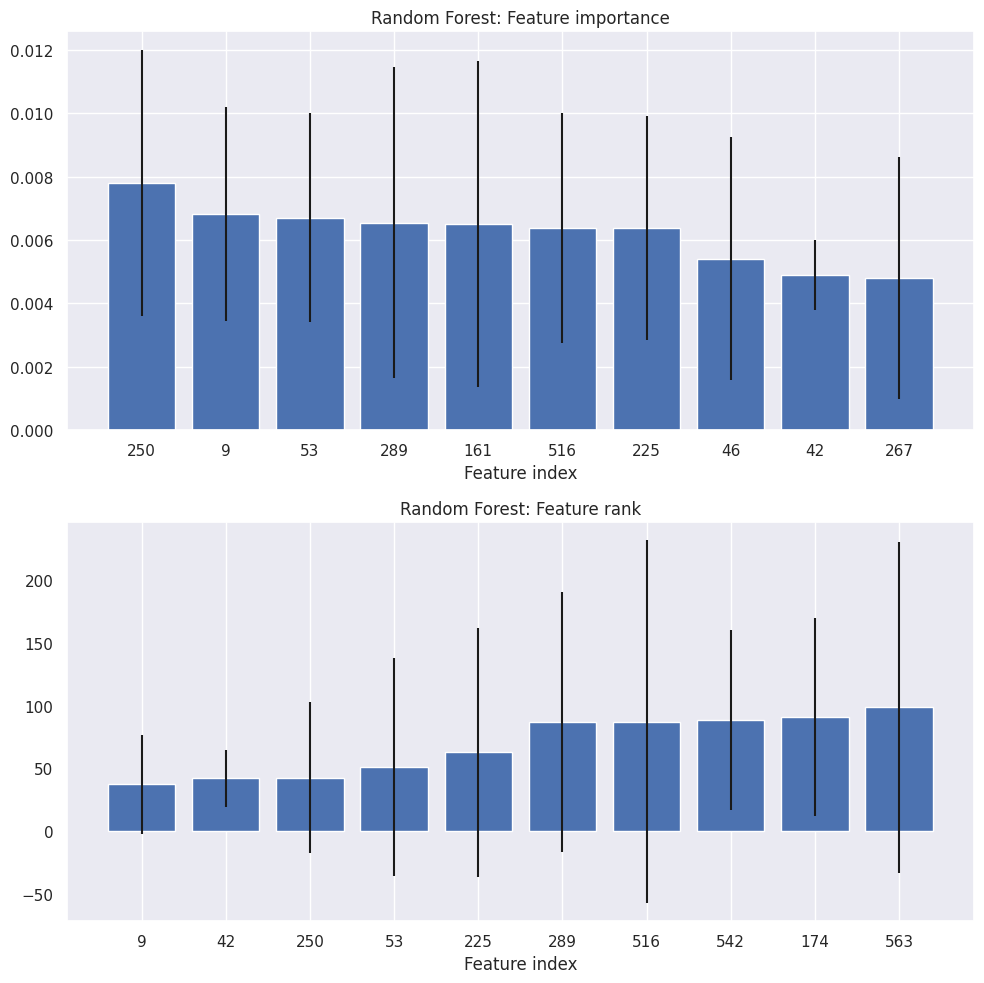

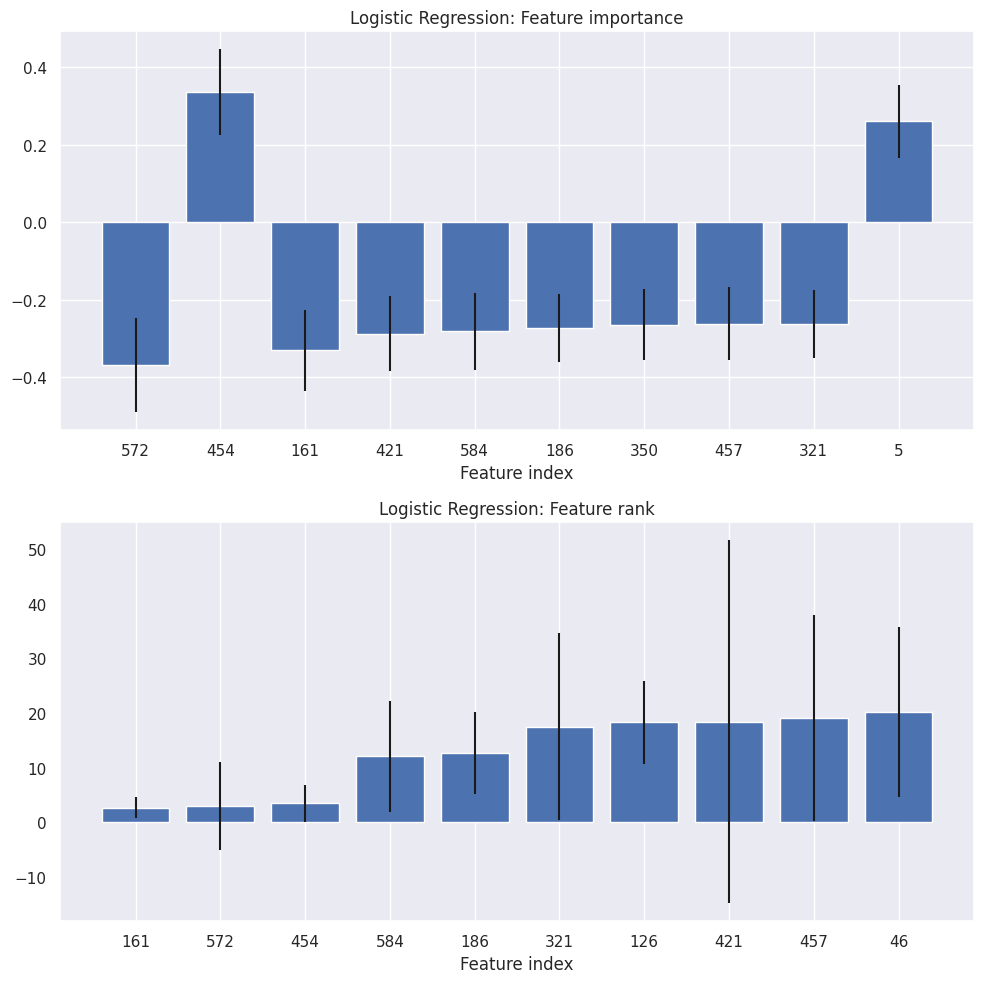

In [23]:
seed = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L"]

run_all_L = run_poly(df_boot, data, seed)
run_all_L.plot_scores()
run_all_L.plot_features(ntop=10)

## All right

2023-03-28 11:51:05,295 - polyssifier - INFO - Detected 2 classes in label
2023-03-28 11:51:05,295 - polyssifier - INFO - Building classifiers ...
2023-03-28 11:51:05,299 - polyssifier - INFO - Initialization, done.
2023-03-28 11:51:05,324 - polyssifier - INFO - Training Multilayer Perceptron 0
2023-03-28 11:51:07,658 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.88, 2.33 sec
2023-03-28 11:51:07,664 - polyssifier - INFO - Training Multilayer Perceptron 1
2023-03-28 11:51:09,651 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.88, 1.99 sec
2023-03-28 11:51:09,657 - polyssifier - INFO - Training Multilayer Perceptron 2
2023-03-28 11:51:11,678 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.92, 2.02 sec
2023-03-28 11:51:11,684 - polyssifier - INFO - Training Multilayer Perceptron 3
2023-03-28 11:51:13,696 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.87, 2.01 sec
2023-03-28 11:51:13,701 - polyss

predict proba return shape (57,)


2023-03-28 11:51:57,151 - polyssifier - INFO - Linear SVM                 1: Train 1.00/Test 0.86, 5.01 sec
2023-03-28 11:51:57,156 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2023-03-28 11:52:01,709 - polyssifier - INFO - Linear SVM                 2: Train 1.00/Test 0.85, 4.55 sec
2023-03-28 11:52:01,713 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2023-03-28 11:52:06,559 - polyssifier - INFO - Linear SVM                 3: Train 1.00/Test 0.93, 4.85 sec
2023-03-28 11:52:06,563 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2023-03-28 11:52:11,082 - polyssifier - INFO - Linear SVM                 4: Train 1.00/Test 0.85, 4.52 sec
2023-03-28 11:52:11,086 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2023-03-28 11:52:15,966 - polyssifier - INFO - Linear SVM                 5: Train 1.00/Test 0.86, 4.88 sec
2023-03-28 11:52:15,971 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2023-03-28 11:52:20,931 - polyssifier - INFO - Linear SVM                 6: Train 1.00/Test 0.89, 4.96 sec
2023-03-28 11:52:20,936 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2023-03-28 11:52:26,515 - polyssifier - INFO - Linear SVM                 7: Train 1.00/Test 0.86, 5.58 sec
2023-03-28 11:52:26,520 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2023-03-28 11:52:31,122 - polyssifier - INFO - Linear SVM                 8: Train 1.00/Test 0.84, 4.60 sec
2023-03-28 11:52:31,128 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2023-03-28 11:52:35,757 - polyssifier - INFO - Linear SVM                 9: Train 1.00/Test 0.87, 4.63 sec
2023-03-28 11:52:35,762 - polyssifier - INFO - Training Decision Tree 0
2023-03-28 11:52:35,788 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.52, 0.03 sec
2023-03-28 11:52:35,793 - polyssifier - INFO - Training Decision Tree 1
2023-03-28 11:52:35,824 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.58, 0.03 sec
2023-03-28 11:52:35,828 - polyssifier - INFO - Training Decision Tree 2
2023-03-28 11:52:35,847 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.49, 0.02 sec
2023-03-28 11:52:35,851 - polyssifier - INFO - Training Decision Tree 3
2023-03-28 11:52:35,871 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.58, 0.02 sec
2023-03-28 11:52:35,875 - polyssifier - INFO - Training Decision Tree 4
2023-03-28 11:52:35,893 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.50, 0

predict proba return shape (57,)


2023-03-28 11:52:35,958 - polyssifier - INFO - Decision Tree              7: Train 1.00/Test 0.46, 0.02 sec
2023-03-28 11:52:35,963 - polyssifier - INFO - Training Decision Tree 8
2023-03-28 11:52:35,981 - polyssifier - INFO - Decision Tree              8: Train 1.00/Test 0.59, 0.02 sec
2023-03-28 11:52:35,986 - polyssifier - INFO - Training Decision Tree 9
2023-03-28 11:52:36,004 - polyssifier - INFO - Decision Tree              9: Train 1.00/Test 0.49, 0.02 sec
2023-03-28 11:52:36,008 - polyssifier - INFO - Training Random Forest 0
2023-03-28 11:52:38,147 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.62, 2.14 sec
2023-03-28 11:52:38,154 - polyssifier - INFO - Training Random Forest 1
2023-03-28 11:52:40,316 - polyssifier - INFO - Random Forest              1: Train 1.00/Test 0.71, 2.16 sec
2023-03-28 11:52:40,323 - polyssifier - INFO - Training Random Forest 2
2023-03-28 11:52:42,447 - polyssifier - INFO - Random Forest              2: Train 1.00/Test 0.74, 2

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.863873  0.047224  0.761787  0.933002
Nearest Neighbors     train  0.831995  0.020836  0.811724  0.871887
                      test   0.720719  0.054792  0.645161  0.786420
SVM                   train  0.996217  0.000610  0.995215  0.996944
                      test   0.850652  0.048098  0.794045  0.937965
Linear SVM            train  0.999737  0.000466  0.998426  1.000000
                      test   0.870213  0.025012  0.837469  0.928395
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.530874  0.046086  0.459677  0.585608
Random Forest         train  0.999942  0.000096  0.999702  1.000000
                      test   0.703123  0.049136  0.622222  0.761728
Logistic Regression   train  0.999849  0.000106  0.999694  1.000000
                      test   0.876016  0.034686 

2023-03-28 11:53:05,212 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-28 11:53:05,512 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-28 11:53:05,841 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-28 11:53:06,128 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


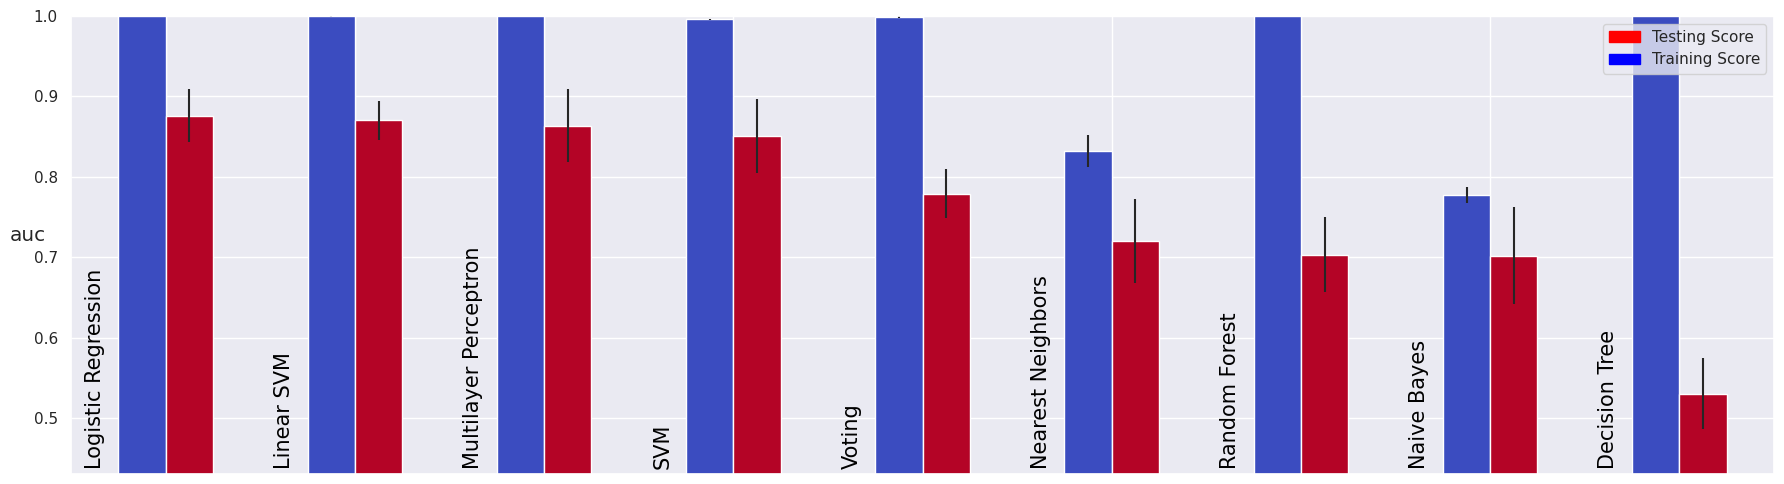

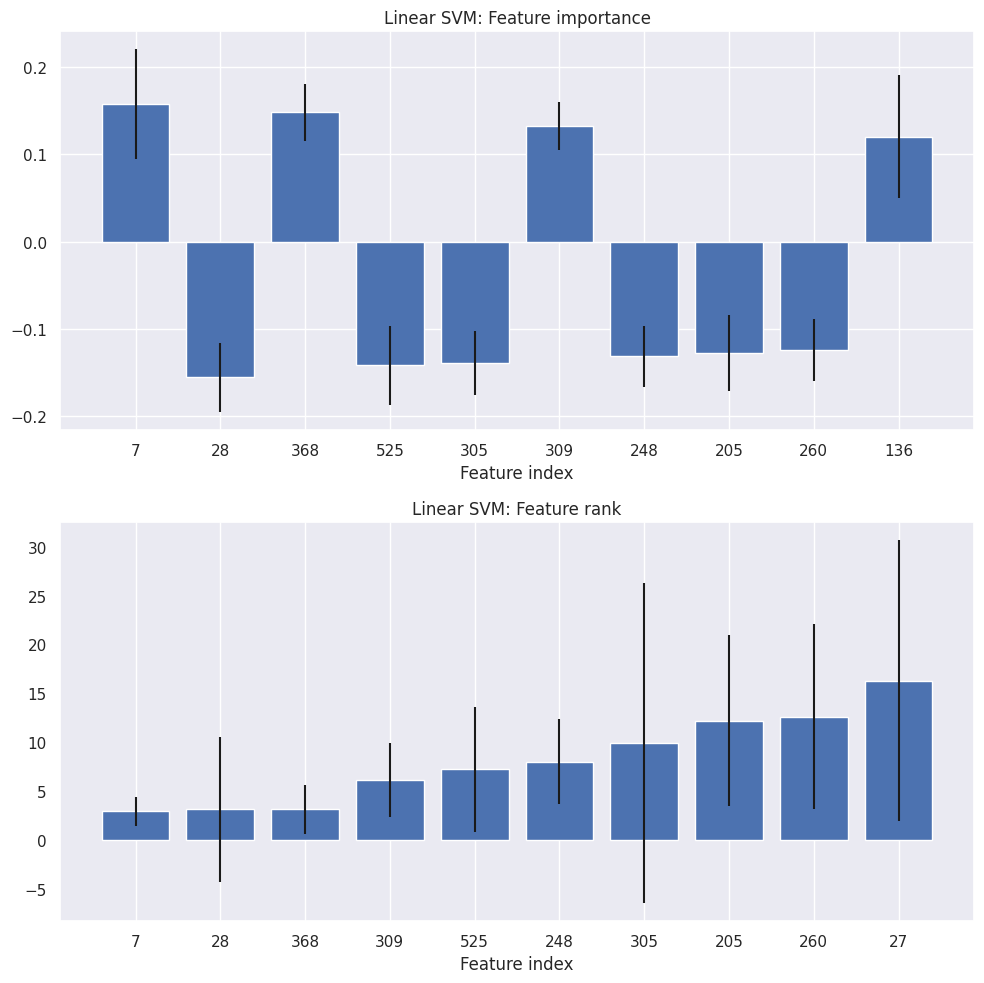

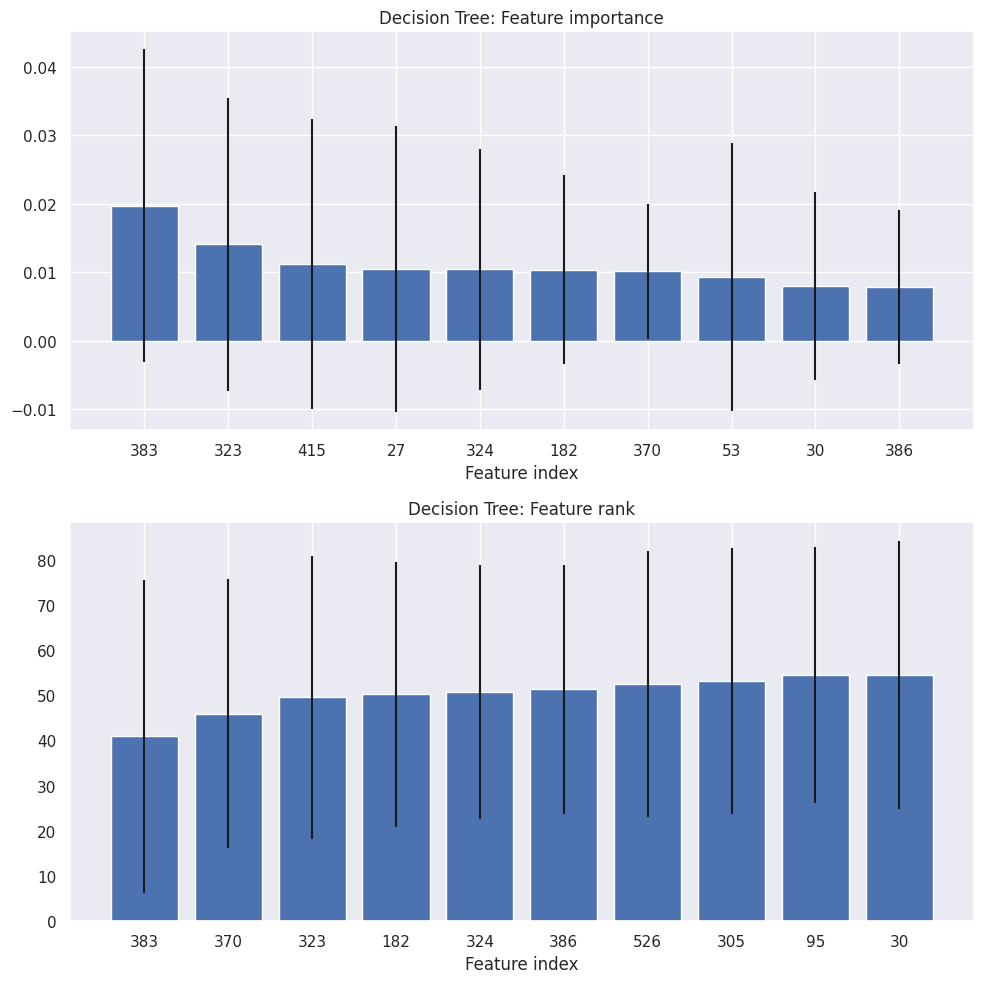

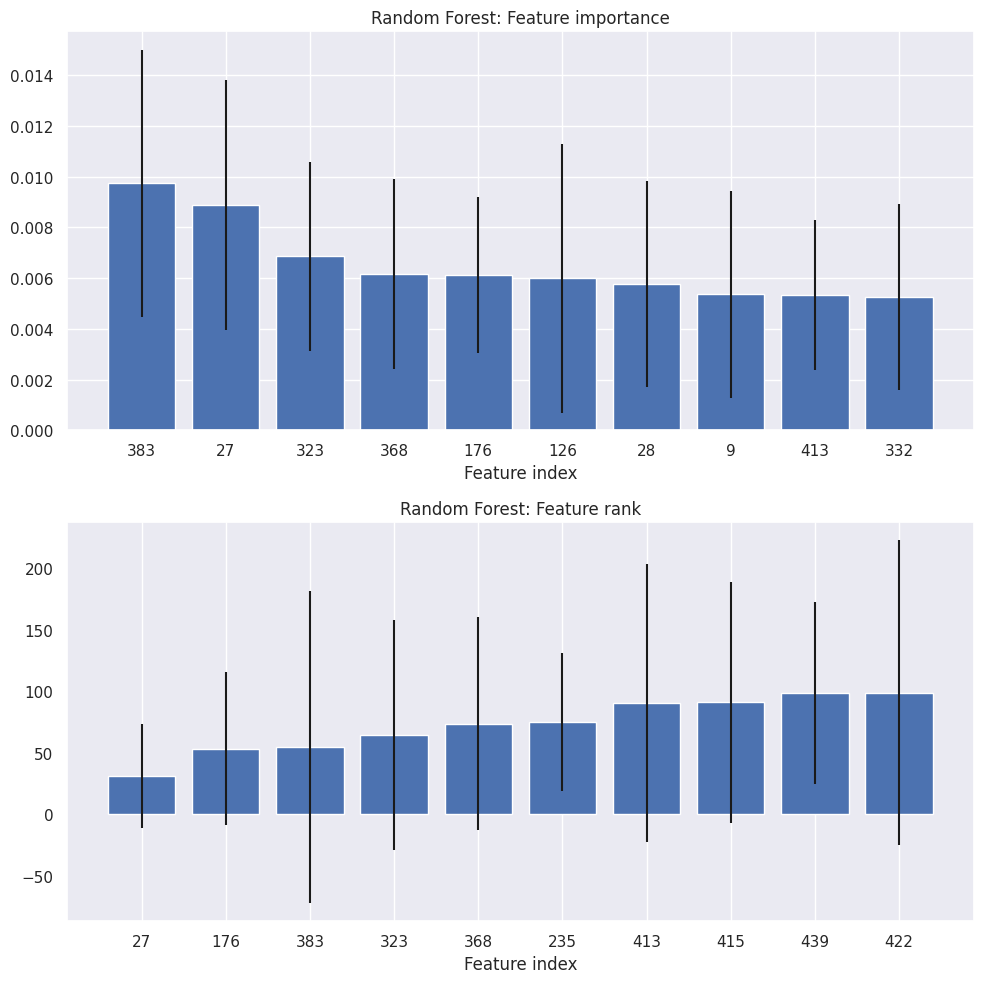

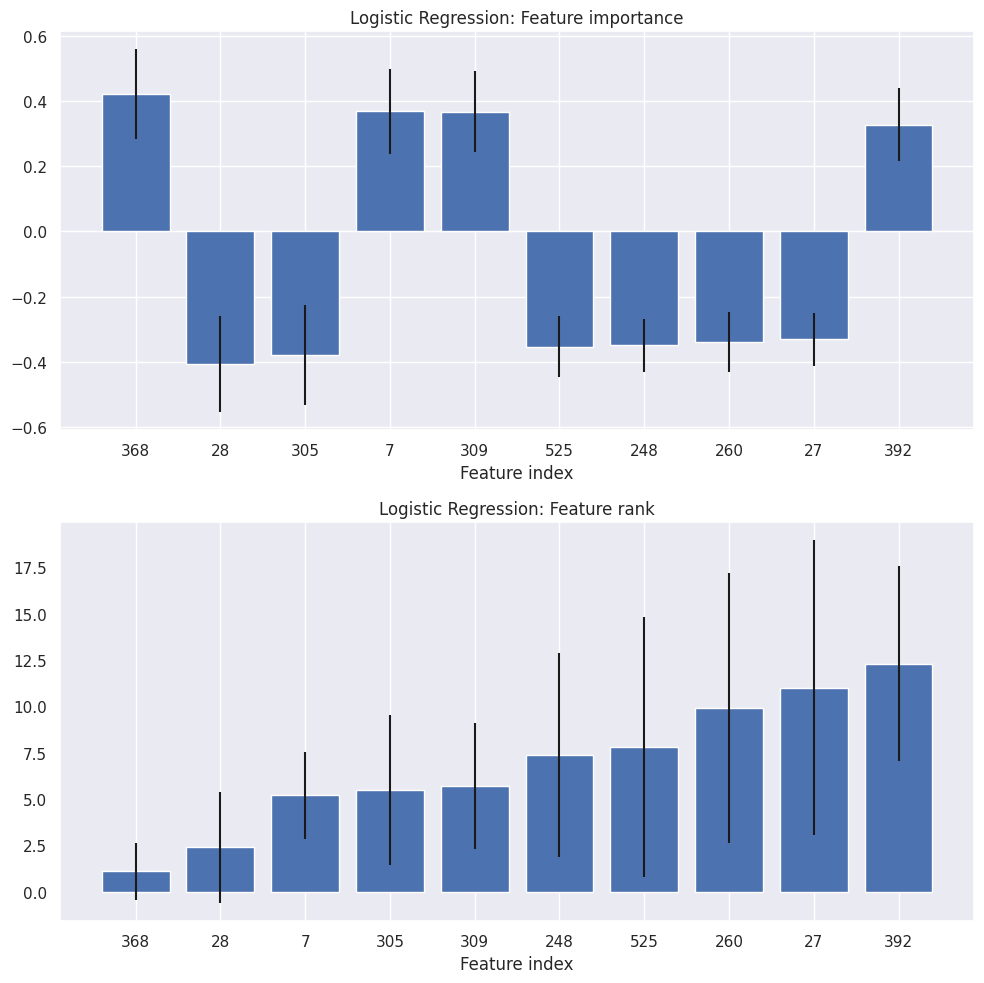

In [24]:
seed = ["opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]

run_all_R = run_poly(df_boot, data, seed)
run_all_R.plot_scores()
run_all_R.plot_features(ntop=10)

# 1 resting state scan

In [ ]:
def run(df_boot, data, seed):\n",
    #    df_bootstrap = pd.DataFrame()\n",
    #     for j in range(0, len(df_boot)):\n",
    #         index = random.randint(0, len(df_boot)-1)\n",
    "#         frames = [df_bootstrap, df_boot[index:index+1]]\n",
    "#         df_bootstrap = pd.concat(frames)\n",
    "\n",
    "#     df_bootstrap = df_bootstrap.drop(df_bootstrap.columns[0], axis=1)\n",
    "\n",
    "    # print(df_bootstrap[\"Gender\"])  # should have the whole list\n",
    "\n",
        x_correl = []\n",
        nb_subjects = len(df_boot)\n",
        subject_label = df_boot[\"subject_label\"][:nb_subjects]\n",
    \n",
        x_correl = []\n",
        for sub in tqdm(subject_label):\n",
            for seed_name in seed:\n",
                x_correl.append(data[sub, seed_name])\n",
    \n",
        x_correl = np.array(x_correl)\n",
        x_correl = x_correl.reshape(len(df_boot), len(seed)*148) # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds))\n",
        \n",
    
        y_sex = df_boot[\"Gender\"][:nb_subjects]  # maybe list(df[\"Gender\"])

        coef = poly(x_correl, y_sex, n_folds=10)
    
        return coef"
   

## REST1_LR

In [81]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-{rest_name}_seed-{seed_name}__voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)
rest = "REST1LR"
data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = rest)
        data[(sub, seed)] = img4d2vector(img_path, masker)

100%|█████████████████████████████████████████| 570/570 [02:08<00:00,  4.42it/s]


In [87]:
run_polyssifier = run_poly(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

2024-01-31 15:42:34,580 - polyssifier - INFO - Detected 2 classes in label
2024-01-31 15:42:34,580 - polyssifier - INFO - Building classifiers ...
2024-01-31 15:42:34,623 - polyssifier - INFO - Initialization, done.
2024-01-31 15:42:34,739 - polyssifier - INFO - Training Multilayer Perceptron 0
2024-01-31 15:42:37,556 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.85, 2.82 sec
2024-01-31 15:42:37,569 - polyssifier - INFO - Training Multilayer Perceptron 1
2024-01-31 15:42:41,072 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.85, 3.50 sec
2024-01-31 15:42:41,080 - polyssifier - INFO - Training Multilayer Perceptron 2
2024-01-31 15:42:44,273 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.81, 3.19 sec
2024-01-31 15:42:44,295 - polyssifier - INFO - Training Multilayer Perceptron 3
2024-01-31 15:42:47,450 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.86, 3.16 sec
2024-01-31 15:42:47,464 - polyss

predict proba return shape (57,)


2024-01-31 15:43:49,782 - polyssifier - INFO - Linear SVM                 1: Train 1.00/Test 0.83, 5.11 sec
2024-01-31 15:43:49,788 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2024-01-31 15:43:56,065 - polyssifier - INFO - Linear SVM                 2: Train 1.00/Test 0.88, 6.28 sec
2024-01-31 15:43:56,073 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2024-01-31 15:44:01,327 - polyssifier - INFO - Linear SVM                 3: Train 1.00/Test 0.88, 5.25 sec
2024-01-31 15:44:01,334 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2024-01-31 15:44:06,453 - polyssifier - INFO - Linear SVM                 4: Train 1.00/Test 0.83, 5.12 sec
2024-01-31 15:44:06,461 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2024-01-31 15:44:12,033 - polyssifier - INFO - Linear SVM                 5: Train 1.00/Test 0.83, 5.57 sec
2024-01-31 15:44:12,041 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2024-01-31 15:44:17,622 - polyssifier - INFO - Linear SVM                 6: Train 1.00/Test 0.85, 5.58 sec
2024-01-31 15:44:17,633 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2024-01-31 15:44:23,081 - polyssifier - INFO - Linear SVM                 7: Train 1.00/Test 0.86, 5.45 sec
2024-01-31 15:44:23,089 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2024-01-31 15:44:28,896 - polyssifier - INFO - Linear SVM                 8: Train 1.00/Test 0.92, 5.81 sec
2024-01-31 15:44:28,904 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2024-01-31 15:44:33,773 - polyssifier - INFO - Linear SVM                 9: Train 1.00/Test 0.92, 4.87 sec
2024-01-31 15:44:33,786 - polyssifier - INFO - Training Decision Tree 0
2024-01-31 15:44:33,940 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.44, 0.15 sec
2024-01-31 15:44:33,948 - polyssifier - INFO - Training Decision Tree 1


predict proba return shape (57,)


2024-01-31 15:44:33,981 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.58, 0.03 sec
2024-01-31 15:44:33,987 - polyssifier - INFO - Training Decision Tree 2
2024-01-31 15:44:34,015 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.56, 0.03 sec
2024-01-31 15:44:34,021 - polyssifier - INFO - Training Decision Tree 3
2024-01-31 15:44:34,047 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.51, 0.03 sec
2024-01-31 15:44:34,053 - polyssifier - INFO - Training Decision Tree 4
2024-01-31 15:44:34,077 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.60, 0.02 sec
2024-01-31 15:44:34,083 - polyssifier - INFO - Training Decision Tree 5
2024-01-31 15:44:34,107 - polyssifier - INFO - Decision Tree              5: Train 1.00/Test 0.57, 0.02 sec
2024-01-31 15:44:34,113 - polyssifier - INFO - Training Decision Tree 6
2024-01-31 15:44:34,137 - polyssifier - INFO - Decision Tree              6: Train 1.00/Test 0.65, 0

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.852792  0.030041  0.794045  0.892060
Nearest Neighbors     train  0.759620  0.005317  0.751231  0.765363
                      test   0.694066  0.047881  0.612346  0.746278
SVM                   train  0.985942  0.002029  0.982282  0.989335
                      test   0.823069  0.040253  0.771712  0.895062
Linear SVM            train  1.000000  0.000000  1.000000  1.000000
                      test   0.872582  0.034823  0.831266  0.921836
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.563480  0.055720  0.440741  0.649504
Random Forest         train  0.999551  0.001133  0.996346  1.000000
                      test   0.704415  0.058676  0.626543  0.827778
Logistic Regression   train  1.000000  0.000000  1.000000  1.000000
                      test   0.882996  0.032178 

## REST1_RL

In [90]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-{rest_name}_seed-{seed_name}__voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)
rest = "REST1RL"
data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = rest)
        data[(sub, seed)] = img4d2vector(img_path, masker)

100%|█████████████████████████████████████████| 570/570 [02:08<00:00,  4.44it/s]


In [91]:
run_polyssifier = run_poly(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

2024-01-31 16:37:10,462 - polyssifier - INFO - Detected 2 classes in label
2024-01-31 16:37:10,463 - polyssifier - INFO - Building classifiers ...
2024-01-31 16:37:10,469 - polyssifier - INFO - Initialization, done.
2024-01-31 16:37:10,528 - polyssifier - INFO - Training Multilayer Perceptron 0
2024-01-31 16:37:13,134 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.80, 2.61 sec
2024-01-31 16:37:13,144 - polyssifier - INFO - Training Multilayer Perceptron 1
2024-01-31 16:37:15,528 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.79, 2.38 sec
2024-01-31 16:37:15,537 - polyssifier - INFO - Training Multilayer Perceptron 2
2024-01-31 16:37:17,903 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.90, 2.37 sec
2024-01-31 16:37:17,911 - polyssifier - INFO - Training Multilayer Perceptron 3
2024-01-31 16:37:20,319 - polyssifier - INFO - Multilayer Perceptron      3: Train 1.00/Test 0.83, 2.41 sec
2024-01-31 16:37:20,328 - polyss

predict proba return shape (57,)


2024-01-31 16:38:20,410 - polyssifier - INFO - Linear SVM                 1: Train 1.00/Test 0.79, 5.28 sec
2024-01-31 16:38:20,418 - polyssifier - INFO - Training Linear SVM 2


predict proba return shape (57,)


2024-01-31 16:38:25,609 - polyssifier - INFO - Linear SVM                 2: Train 1.00/Test 0.94, 5.19 sec
2024-01-31 16:38:25,617 - polyssifier - INFO - Training Linear SVM 3


predict proba return shape (57,)


2024-01-31 16:38:30,095 - polyssifier - INFO - Linear SVM                 3: Train 1.00/Test 0.81, 4.48 sec
2024-01-31 16:38:30,103 - polyssifier - INFO - Training Linear SVM 4


predict proba return shape (57,)


2024-01-31 16:38:34,712 - polyssifier - INFO - Linear SVM                 4: Train 1.00/Test 0.81, 4.61 sec
2024-01-31 16:38:34,720 - polyssifier - INFO - Training Linear SVM 5


predict proba return shape (57,)


2024-01-31 16:38:39,917 - polyssifier - INFO - Linear SVM                 5: Train 1.00/Test 0.85, 5.20 sec
2024-01-31 16:38:39,924 - polyssifier - INFO - Training Linear SVM 6


predict proba return shape (57,)


2024-01-31 16:38:44,839 - polyssifier - INFO - Linear SVM                 6: Train 1.00/Test 0.89, 4.92 sec
2024-01-31 16:38:44,847 - polyssifier - INFO - Training Linear SVM 7


predict proba return shape (57,)


2024-01-31 16:38:49,650 - polyssifier - INFO - Linear SVM                 7: Train 1.00/Test 0.87, 4.80 sec
2024-01-31 16:38:49,658 - polyssifier - INFO - Training Linear SVM 8


predict proba return shape (57,)


2024-01-31 16:38:54,631 - polyssifier - INFO - Linear SVM                 8: Train 1.00/Test 0.85, 4.97 sec
2024-01-31 16:38:54,640 - polyssifier - INFO - Training Linear SVM 9


predict proba return shape (57,)


2024-01-31 16:38:59,345 - polyssifier - INFO - Linear SVM                 9: Train 1.00/Test 0.92, 4.71 sec
2024-01-31 16:38:59,353 - polyssifier - INFO - Training Decision Tree 0
2024-01-31 16:38:59,399 - polyssifier - INFO - Decision Tree              0: Train 1.00/Test 0.55, 0.05 sec
2024-01-31 16:38:59,408 - polyssifier - INFO - Training Decision Tree 1
2024-01-31 16:38:59,435 - polyssifier - INFO - Decision Tree              1: Train 1.00/Test 0.41, 0.03 sec
2024-01-31 16:38:59,440 - polyssifier - INFO - Training Decision Tree 2
2024-01-31 16:38:59,465 - polyssifier - INFO - Decision Tree              2: Train 1.00/Test 0.61, 0.02 sec
2024-01-31 16:38:59,471 - polyssifier - INFO - Training Decision Tree 3
2024-01-31 16:38:59,497 - polyssifier - INFO - Decision Tree              3: Train 1.00/Test 0.62, 0.03 sec
2024-01-31 16:38:59,504 - polyssifier - INFO - Training Decision Tree 4
2024-01-31 16:38:59,530 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.61, 0

predict proba return shape (57,)


2024-01-31 16:38:59,563 - polyssifier - INFO - Decision Tree              5: Train 1.00/Test 0.67, 0.03 sec
2024-01-31 16:38:59,570 - polyssifier - INFO - Training Decision Tree 6
2024-01-31 16:38:59,593 - polyssifier - INFO - Decision Tree              6: Train 1.00/Test 0.66, 0.02 sec
2024-01-31 16:38:59,599 - polyssifier - INFO - Training Decision Tree 7
2024-01-31 16:38:59,624 - polyssifier - INFO - Decision Tree              7: Train 1.00/Test 0.55, 0.02 sec
2024-01-31 16:38:59,629 - polyssifier - INFO - Training Decision Tree 8
2024-01-31 16:38:59,654 - polyssifier - INFO - Decision Tree              8: Train 1.00/Test 0.49, 0.02 sec
2024-01-31 16:38:59,660 - polyssifier - INFO - Training Decision Tree 9
2024-01-31 16:38:59,684 - polyssifier - INFO - Decision Tree              9: Train 1.00/Test 0.56, 0.02 sec
2024-01-31 16:38:59,690 - polyssifier - INFO - Training Random Forest 0
2024-01-31 16:39:02,419 - polyssifier - INFO - Random Forest              0: Train 1.00/Test 0.63, 2

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.834212  0.038588  0.786420  0.903704
Nearest Neighbors     train  0.769102  0.007009  0.756356  0.779039
                      test   0.707454  0.052355  0.626543  0.812035
SVM                   train  0.978561  0.001888  0.976203  0.981085
                      test   0.813676  0.050113  0.743210  0.872208
Linear SVM            train  1.000000  0.000000  1.000000  1.000000
                      test   0.858983  0.046661  0.793827  0.939506
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.573851  0.077931  0.414815  0.668734
Random Forest         train  0.999919  0.000087  0.999763  1.000000
                      test   0.689389  0.037710  0.632099  0.743827
Logistic Regression   train  1.000000  0.000000  1.000000  1.000000
                      test   0.863818  0.044462 

## REST2_LR

In [ ]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-{rest_name}_seed-{seed_name}__voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)
rest = "REST2LR"
data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = rest)
        data[(sub, seed)] = img4d2vector(img_path, masker)

## REST2_RL

In [ ]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-{rest_name}_seed-{seed_name}__voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)
rest = "REST2RL"
data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path = img_tpl.format(seed_name=seed, participant_id=sub, rest_name = rest)
        data[(sub, seed)] = img4d2vector(img_path, masker)